# Diffusion Fundamentals

## Diffusion and Score Based Models

### Introduction

In recent years, several methods have arisen for generative modeling of data such as Variational Autoencoders (VAEs), Generative Adversarial Networks (GANs), Autoregressive models, and Normalizing Flows just to name a few. But none really broke the internet quite like the way diffusion models did. Reason being, none could generate images with the same level of quality and diversity as diffusion models. GANs did come close but they were really painful to train and were really unstable. Autoregressive models were too slow. Normalizing Flows were too computationally expensive. VAEs were too blurry. 

### The Idea

The idea was that trying to train a model to generate an image in a single step was too hard, so why not instead let it model it in multiple steps? There were two approaches that were proposed to do this: Score based models and diffusion models. But in both, the idea was that our data could be thought of as a special complicated distribution that we could sample from, and that we could start from a simple distribution such as a normal distribution and find a way to transform samples from this simple distribution into those from the data distribution (or as close as we can get). 

Therefore, its a problem of going from a random high entropy point in the input space to a low entropy point where the scale of entropy is defined as a continous mapping from the data distribution to the simple normal distribution.

Thus we would start from a random sample from normal distribution aka some random gaussian noise, and iteratively try to find our way to gradually transform it into some sample that looks like it came from the data distribution. We do this in some defined time steps $t$. Thus we define a process of starting from a random noise sample at time $t=0$ and gradually removing the noise and finding some useful data at each time step $t$ until we reach $t=T$ where we have ideally no noise and only data left.

### How do we do this?

#### Score Based Models

The score based models tackle this by trying to estimate the gradient of the log-likelihood of the data distribution (don't get scared, just bear it for now) at each time step. This gradient basically points us in the direction of the data distribution from the current sample, and we can then take a step in that direction to remove some noise in kind of like a gradient decent style process. This process is repeated until we reach the final time step where we have ideally no noise left. This is the basic idea behind score based models. The noising and denoising processes are defined by stochastic differential equations (SDEs). We will learn about these formulations in later sections.

#### Diffusion Models

The way diffusion models work is by simply training a model that, given an intermediate noised sample, try to denoise the sample a bit at each discrete time step in an image-to-image manner rather than explicitly learning to estimate the gradient. The time step itself can also be provided to the model to assist it in the process. It has been shown that both score based and diffusion principles are equivalent, they only really differ in the way their objective loss functions are defined. 

In the original DDPM paper, diffusion processes were defined as a markov chain where in forward time, we would go from a sample $x_t$ with some amount of noise to a sample $x_{t+1}$ with more noise, and the reverse of this in reverse time, in discrete time steps $t$. This has been cited as the only major difference between score based models and diffusion models but if you think about it, they are basically the same thing. In discrete time steps, we have markov chains of states of DDPM, in continuous time steps (i.e, infinitesimal time steps), we have stochastic differential equations (SDEs) of score based models.

And thus, more recent papers use the more generalized approach of formulating the processes as SDEs and ODEs as finding solutions i.e, integrating differential equations is a very well studied field with several solvers available.

But we need to train the model as well right? and what exactly is this diffusion process? Well its pretty intuitive from what we have understood so far: We can simply take samples from our actual data distribution, and construct a set of samples with gradually increasing noise levels by adding gaussian noise at each time step, until we basically have a set of samples that are just noise. This gradual noising process is very similar to the process of diffusion from thermodynamics where particles move from low entropy to high entropy, hence the name. Score based models just stumbled upon the same idea independently.

## The Diffusion Process

The diffusion process (the forward diffusion process) can be described as a stochastic differential equation (SDE):

$dx_t = f(t, x_t) \, dt + g(t, x_t) \, dW_t $

where:
- $dx_t$ is the infinitesimal change in the data sample $x_t$ at time $t$,
- $f(t, x_t)$ is the drift term, which represents the deterministic part of the process,
- $g(t, x_t)$ is the diffusion term, which represents the stochastic part of the process,
- $dW_t$ is the infinitesimal increment of a Wiener process (or standard Brownian motion).

Don't get overwhelmed by the math, its just a fancy way of saying that the data sample at time $t$ is a function of the data sample at time $t-1$ and some noise. The drift term is the deterministic part of the process that tells us how the data sample changes over time, and the diffusion term is the stochastic part that tells us how the noise affects the data sample. We would soon look at how we can model these terms in the form of a defined noise schedule.

Given the above forward-time diffusion process SDE, We can also formulate the reverse-time diffusion process SDE (as found by Anderson (1982)):

$dx_t = [f(t, x_t) - g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t)] \, dt + g(t, x_t) \, d\bar{W}_t $

where:
- $ dx_t $ is the infinitesimal change in the data sample $ x_t $ at time $ t $,
- $ f(t, x_t) $ is the drift term from the forward process,
- $ g(t, x_t) $ is the diffusion term from the forward process,
- $ \nabla_{x_t} \log p_t(x_t) $ is the gradient of the log-density of the data at time $ t $,
- $ d\bar{W}_t $ is the infinitesimal increment of a reverse-time Wiener process (or standard Brownian motion).

Again, its nothing fancy and quite easy to understand when we will later try implementing these.

We will thus implement our forward diffusion process via a Noise schedule and our reverse diffusion process via a Sampler, which is essentially a SDE (or ODE) solver that finds a solution to the above differential equation.

An important thing to note is that Every reverse-time diffusion SDE has a corresponding probability flow ODE with the same marginal densities. This essentially means that we can find solutions to go from a noised sample to a denoised sample in a deterministic manner following an ODE as well. This is the difference between ancestral (like DDPM, Euler-A) and non anscestral samplers (like DDIM, Euler etc). Ancestral samplers solve the SDE, while non-ancestral samplers solve the ODE. The Probability Flow ODE is given by:

$ \frac{dx_t}{dt} = f(t, x_t) - \frac{1}{2} g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t) $

where:
- $\frac{dx_t}{dt}$ is the time derivative of the data sample $x_t$,
- $f(t, x_t)$ is the drift term from the forward process,
- $g(t, x_t)$ is the diffusion term from the forward process,
- $\nabla_{x_t} \log p_t(x_t)$ is the gradient of the log-density of the data at time $t$.

This ODE provides a deterministic trajectory that samples from the same distribution as the original stochastic process.

If we try to model this term $\nabla_{x_t} \log p_t(x_t)$ directly as a neural network $s_t(x_t)$, we get what is known as a score based model. But if we try to think of it as a kind of noise term $ \frac{\epsilon_{\theta}(x_t, t)}{\sigma_t} $, we get a diffusion model. Both of these are equivalent but just for brevity, we shall discuss what the original DDPM paper did.

### DDPM's original formulation for Diffusion

The DDPM paper defined the forward diffusion process as a markov chain of conditional distributions $q(x_t|x_{t−1})$:

$q(x_t|x_{t−1}) := \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t−1}, \beta_t I)$

where:
- $x_t$ is the data sample at time $t$,
- $x_{t−1}$ is the data sample at time $t-1$,
- $\beta_t$ is the noise level at time $t$,
- $I$ is the identity matrix.

And the reverse diffusion process was defined as:

$p_\theta(x_{t−1}|x_t) := \mathcal{N}(x_{t−1};\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$

where:
- $x_{t−1}$ is the data sample at time $t-1$,
- $x_t$ is the data sample at time $t$,
- $\mu_\theta(x_t, t)$ is the mean of the reverse distribution,
- $\Sigma_\theta(x_t, t)$ is the covariance of the reverse distribution.

The noise level $\beta_t$ was defined as a function of time $t$ and the number of time steps $T$ and the $\mu_\theta(x_t, t)$ was basically our neural network that we would train to denoise the sample at time $t$, with the wights being $\theta$.

But remember that this is just a discretized version of the diffusion differential equations we discussed above, and latest research papers use the more generalized version formulated as the SDEs and ODEs rather than the markov chain. But just for the sake of accuracy, we shall implement DDPM and DDIM with this markov chain formulation.

These are basically defined via noise schedules in FlaxDiff and thus using a discretized noise schedule vs a continuous one is what differentiates DDPM/DDIM from the latest techniques (and also score based methods but along with the loss function which is just slightly different).

# Imports

In [1]:
import tqdm
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
from flax.training import orbax_utils
import functools
import numpy as np

2024-07-08 23:09:44.658000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Some Important Utils

In [2]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

class RandomClass():
    def __init__(self, rng: jax.random.PRNGKey):
        self.rng = rng

    def get_random_key(self):
        self.rng, subkey = jax.random.split(self.rng)
        return subkey
    
    def get_sigmas(self, steps):
        return jnp.tan(self.theta_min + steps * (self.theta_max - self.theta_min)) / self.kappa

    def reset_random_key(self):
        self.rng = jax.random.PRNGKey(42)

class MarkovState(struct.PyTreeNode):
    pass

class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey

# Data Pipeline

For simplicity, we will use the oxford flowers dataset for this notebook. We will use the tensorflow datasets library to load the dataset.

In [3]:
def get_dataset(data_name="oxford_flowers102", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], tf.float32) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, 0.999, 1.05)
            image = tf.image.random_brightness(image, 0.2)

            image = tf.clip_by_value(image, -1.0, 1.0)
            return image
        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        .cache()  # Cache after augmenting to avoid recomputation
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .repeat()  # Repeats the dataset indefinitely
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    ).as_numpy_iterator()
    return final_data, len(data)


# Noise Schedulers

A Noise schedule governs how noise is added in the forward diffusion steps. Basically, given a time step $t$, it 
returns the signal rate $\alpha$ and noise rate $\sigma_t$ with which to scale the initial data sample $x_0$ and Gaussian noise $\epsilon$ as given by the equation:

$x_t = \alpha_t x_0 + \sigma_t \epsilon_0$

where $x_t$ is the data sample at time $t$, $x_0$ is the initial data sample, and $\epsilon$ is the Gaussian noise, and $\alpha$ and $\sigma_t$ are the signal and noise rates at time $t$ respectively.

In variance preserving diffusion, the noise schedule is such that the variance of the data sample remains constant across time steps. This basically means the following:

$\alpha_t^2 + \sigma_t^2 = 1$

The idea is that with increasing time step $t$, the signal rate $\alpha_t$ decreases and the noise rate $\sigma_t$ increases, decreasing the $%$ of the initial data sample and increasing the amount of noise, slowly diffusing the data sample smoothly to the target normal distribution.

Ofcourse there are many ways to schedule the noise, and the constraint of variance preserving isn't the only way to go about it either. There are Variance exploding and variance preserving schedules as well. In this notebook, we will be looking at the variance preserving noise schedules only.

In [4]:
class NoiseScheduler():
    def __init__(self, timesteps,
                    dtype=jnp.float32,
                    clip_min=-1.0,
                    clip_max=1.0,
                    *args, **kwargs):
        self.max_timesteps = timesteps
        self.dtype = dtype
        self.clip_min = clip_min
        self.clip_max = clip_max
        if type(timesteps) == int and timesteps > 1:
            timestep_generator = lambda rng, batch_size, max_timesteps = timesteps: jax.random.randint(rng, (batch_size,), 0, max_timesteps)
        else:
            timestep_generator = lambda rng, batch_size, max_timesteps = timesteps: jax.random.uniform(rng, (batch_size,), minval=0, maxval=max_timesteps)
        self.timestep_generator = timestep_generator

    def generate_timesteps(self, batch_size, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        timesteps = self.timestep_generator(rng, batch_size, self.max_timesteps)
        return timesteps, state
    
    def get_weights(self, steps):
        raise NotImplementedError
    
    def reshape_rates(self, rates:tuple[jnp.ndarray, jnp.ndarray], shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        signal_rates, noise_rates = rates
        signal_rates = jnp.reshape(signal_rates, shape)
        noise_rates = jnp.reshape(noise_rates, shape)
        return signal_rates, noise_rates
    
    def get_rates(self, steps, shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
    def add_noise(self, images, noise, steps) -> jnp.ndarray:
        signal_rates, noise_rates = self.get_rates(steps)
        return signal_rates * images + noise_rates * noise
    
    def remove_all_noise(self, noisy_images, noise, steps, clip_denoised=True, rates=None):
        signal_rates, noise_rates = self.get_rates(steps)
        x_0 = (noisy_images - noise * noise_rates) / signal_rates
        return x_0
    
    def transform_inputs(self, x, steps):
        return x, steps
    
    def get_max_variance(self):
        alpha_n, sigma_n = self.get_rates(self.max_timesteps)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return variance

## Cosine Noise Scheduler

Cosine Schedule is one of the most widely used noise schedules. Its a Variance Preserving noise schedule and can either be parameterized directly as the functions $\alpha(t)$ and $\sigma(t)$ defined directly as 

$\alpha(t) = cos(\dfrac{\pi t}{2 T})$ and $\sigma(t) = sin(\dfrac{\pi t}{2 T})$, 

which is simple to understand as $sin(x)^2 + cos(x)^2 = 1$, which satisfies the variance preserving constraint, 
or in terms of functions depending on a single time dependent function $\beta(t)$ as defined in the original DDPM paper and many more places. 

You see, as described before, In the original DDPM Paper, the forward diffusion step is defined as 

$q(x_t|x_{t−1}) := \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t−1}, \beta_t I)$

where $q(x_t|x_{t−1})$ is the forward diffusion step. It's the conditional distribution of the data sample $x_t$ given the previous data sample $x_{t-1}$, and the equation states that $x_t$ is normally distributed with mean $\sqrt{1-\beta_t}x_{t−1}$ and variance $\beta_t$.

In human speak, the forward diffusion is phrased as:

$x_t = \sqrt{1-\beta_t}x_{t−1} + \sqrt{\beta_t} \epsilon_t$

where $x_t$ is the data sample at time $t$, $x_{t-1}$ is the previous data sample, and $\epsilon_t$ is the Gaussian noise at time $t$. Notice that $x_t$ is phrased in terms of $x_{t-1}$ instead of the initial data sample $x_0$ as we did in the 'Noise Schedulers' section. 

To convert this formulation to the type we discussed above

$x_t = \alpha_t  x_0 + \sigma_t  \epsilon_0$,

we can find that our signal rate $\alpha_t$ and noise rate $\sigma_t$ can be defined as

$\alpha_t = \prod_t \sqrt{1-\beta_t}$

$\sigma_t = \sqrt{1-\alpha_t^2}$ 

**Note: The thing is, the maths in DDPM paper use the symbol $\alpha$ for a different thing, as an intermediate to denote the value $\alpha_t = 1-\beta_t$, so just be careful with the notation. We use $\alpha$ to denote the signal rate in this notebook.**

We shall thus define the Cosine Noise Scheduler twice: Once in terms of the $\beta(t)$ parameter aka the way its formulated in the DDPM paper, and then in a more simplified way directly in terms of $\alpha(t)$ and $\sigma(t)$.

### Cosine Noise Scheduler in terms of $\beta(t)$

In [5]:
def cosine_beta_schedule(timesteps, start_angle=0.008, end_angle=0.999):
    ts = np.linspace(0, 1, timesteps + 1, dtype=np.float64)
    alphas_bar = np.cos((ts + start_angle) / (1 + start_angle) * np.pi /2) ** 2
    alphas_bar = alphas_bar/alphas_bar[0]
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return np.clip(betas, 0, end_angle)

class CosineDiscreteNoiseSchedule(NoiseScheduler):
    """
    Variance Preserving Noise Scheduler
    signal_rate**2 + noise_rate**2 = 1
    """
    def __init__(self, timesteps,
                    beta_start=0.008, 
                    beta_end=0.999,
                    *args, **kwargs):
        super().__init__(timesteps, *args, **kwargs)
        betas = cosine_beta_schedule(timesteps, beta_start, beta_end)
        self.betas = jnp.array(betas)
        alphas = jnp.cumprod(jnp.sqrt(1 - betas))
        self.alphas = alphas            # This is not the same alpha as mentioned in the original paper!
        self.sigmas = jnp.sqrt(1 - alphas ** 2)
        
    def get_rates(self, steps, shape=(-1, 1, 1, 1)):
        steps = jnp.astype(steps, jnp.int32)
        alpha = self.alphas[steps]
        sigma = self.sigmas[steps]
        alpha = jnp.reshape(alpha, shape)
        sigma = jnp.reshape(sigma, shape)
        return alpha, sigma
    
    def get_weights(self, steps, shape=(-1, 1, 1, 1)):
        return 1 # For simplicity, we are not using weights in this case

### Cosine Noise Scheduler in terms of $\alpha(t)$ and $\sigma(t)$

In [6]:
class ContinuousNoiseScheduler(NoiseScheduler):
    """
    General Continuous Noise Scheduler
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
class CosineContinuousNoiseScheduler(ContinuousNoiseScheduler):
    def get_rates(self, steps, shape=(-1, 1, 1, 1)) -> tuple[jnp.ndarray, jnp.ndarray]:
        steps = jnp.float32(steps)
        signal_rates = jnp.cos((jnp.pi * steps) / (2 * self.max_timesteps))
        noise_rates = jnp.sin((jnp.pi * steps) / (2 * self.max_timesteps))
        return self.reshape_rates((signal_rates, noise_rates), shape=shape)
    
    def get_weights(self, steps):
        alpha, sigma = self.get_rates(steps, shape=())
        return 1 / (1 + (alpha ** 2 / sigma ** 2))
    

## Lets play with our Noise Schedulers
### Visualization of $\alpha(t)$ and $\sigma(t)$ with linear time steps $t$
to prove that both are equivalent.

Discrete Cosine Noise Schedule


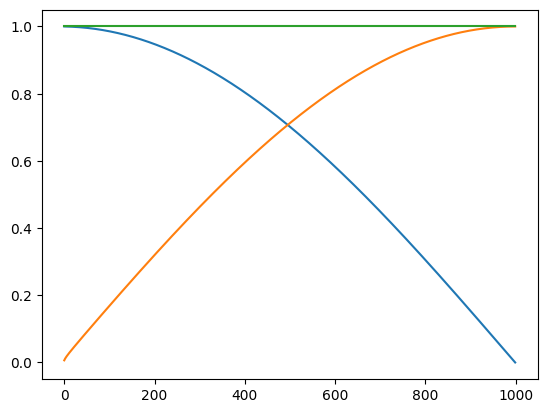

Continuous Cosine Noise Schedule


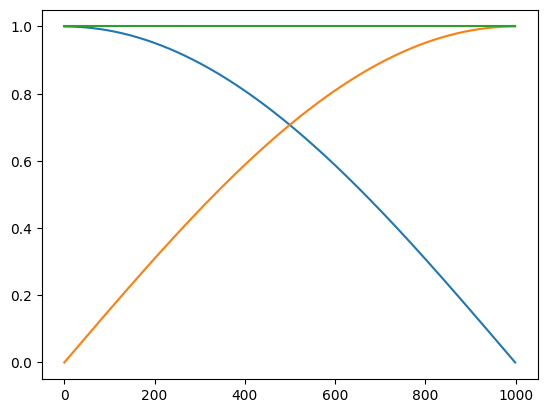

In [7]:
maxT = 1000
timesteps = jnp.linspace(0, maxT, 1000)
get_variance = lambda rates: rates[0] ** 2 + rates[1] ** 2
"""
Lets first plot the signal and noise rates for the discrete cosine noise schedule
"""
print("Discrete Cosine Noise Schedule")
schedule = CosineDiscreteNoiseSchedule(maxT)
plt.plot([schedule.get_rates(i, shape=()) for i in timesteps], label=["signal", "noise"])
plt.plot([get_variance(schedule.get_rates(i, shape=())) for i in timesteps], label="variance")
plt.show()

print("Continuous Cosine Noise Schedule")
schedule = CosineContinuousNoiseScheduler(maxT)
plt.plot([schedule.get_rates(i, shape=()) for i in timesteps], label=["signal", "noise"])
plt.plot([get_variance(schedule.get_rates(i, shape=())) for i in timesteps], label="variance")
plt.show()


### Now lets test the noise scheduler on some simple images

We shall first sample some images from our dataset, then apply some noise to them using the noise scheduler, and then visualize the images at different time steps to see how the noise is added, and then how it is removed.

I0000 00:00:1720460315.684936  202612 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720460315.695669  202612 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720460315.695858  202612 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720460315.696770  202612 cuda_executor.cc:1020] successful NUMA node read from SysFS ha

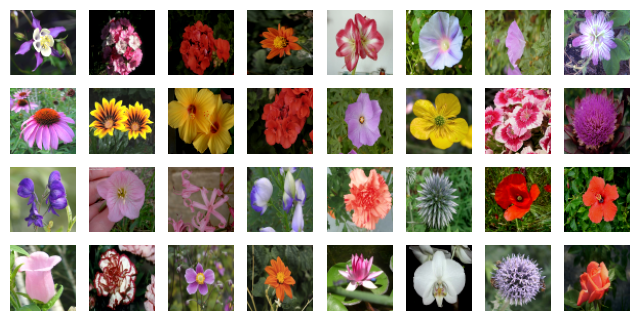

Rates: alpha=[[[[0.7071067]]]], sigma=[[[[0.7071068]]]]
Noisy Images


/tmp/ipykernel_202612/3433040840.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  noise = jax.random.normal(jax.random.PRNGKey(4), shape=images.shape, dtype=jnp.float64)


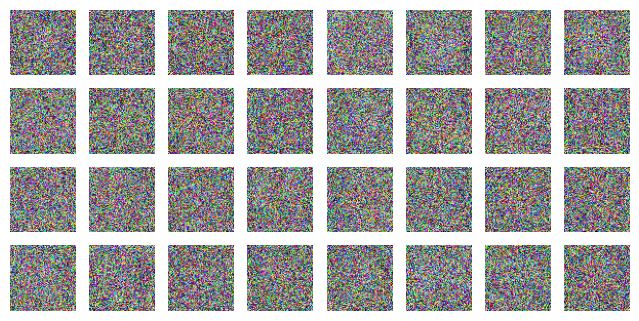

Reconstructed Images


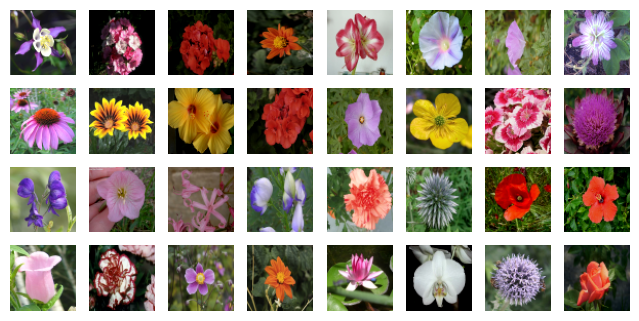

In [8]:
# Visualize adding some noise to some sample images and then removing it
data, _ = get_dataset("oxford_flowers102", batch_size=32, image_scale=64)
images = next(iter(data))
plotImages(images)
noise_level = 500
noise_level_max = 1000
schedule = CosineContinuousNoiseScheduler(noise_level_max)

alpha_t, sigma_t = schedule.get_rates(noise_level)
print(f"Rates: alpha={alpha_t}, sigma={sigma_t}") 
noise = jax.random.normal(jax.random.PRNGKey(4), shape=images.shape, dtype=jnp.float64)
noisy_images = schedule.add_noise(images, noise, noise_level)
print("Noisy Images")
plotImages(noisy_images)
print("Reconstructed Images")
reconstructed_images = schedule.remove_all_noise(noisy_images, noise, noise_level)
plotImages(reconstructed_images)

# Modeling

Neural network comes into play for learning to estimate the gradient $\nabla_{x_t} \log p_t(x_t)$ in the reverse diffusion process as described above:

$dx_t = [f(t, x_t) - g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t)] \, dt + g(t, x_t) \, d\bar{W}_t $

Score based models estimate the gradient $\nabla_{x_t} \log p_t(x_t)$ directly as

$ s_{\theta}(x_t) = \nabla_{x_t} \log p_t(x_t) $

where $s_{\theta}(x_t)$ is the score model, and $\theta$ are the parameters of the score model. But we can also model it in terms of a neural network that predicts the actual noise at time $t$ as well

$ \frac{\epsilon_{\theta}(x_t, t)}{\sigma_t} \approx - s_{\theta}(x_t) = \nabla_{x_t} \log p_t(x_t)  $

where $\epsilon_{\theta}(x_t, t)$ is the denoising model, and $\theta$ are the parameters of the denoising model.

*But why predict noise? Well we could also predict given a noisy sample, the original sample. That works too, but the first few original diffusion papers used the epsilon formulation and they argued that it was easier for a model to learn to predict the noise in an image rather than the original image itself. And anyway, once we have the noise, we can just subtract that from the noisy image to get the original image.*

In this notebook, we will be using this denoising model for solving the reverse diffusion process but there are other parameterizations as well that work really well. We will look into them in some other examples.

## Denoising Model

We will be using a simple UNet architecture for our denoising model. The UNet architecture is a popular architecture for image segmentation tasks, but it proves to be quite useful for denoising tasks as well. The architecture is quite simple and consists of an encoder and a decoder connected by skip connections. The encoder downsamples the input image and extracts features, while the decoder upsamples the features and reconstructs the image. The skip connections help in preserving spatial information and gradients.

We will also add some self attention blocks at each level of the UNet to help the model focus on finding clues in the image that are important for denoising.

The encoder and decoder blocks will be made of several resolution levels, and on each level will be made of several residual blocks, an attention block and a downsampling or upsampling block (for encoder and decoder respectively). There would also be a middle block of a single level of the same design but without downsampling or upsampling.

As our model $\epsilon_{\theta}(x_t, t)$ takes as input the time step $t$ as well, we will feed the model an additional input of the time step $t$ which would be added to each residual block after being embedded in a certain way and transformed and projected by few linear layers. The time step $t$ would be embedded in a way similar to how positional encodings are added in transformers. 

**We shall also use separable convolutions in our model to reduce the number of parameters and thus the memory required. If these models do not compile on your machine, try switching all blocks to separable convs and than further reducing the resolution wise feature level sizes.**

## The basic building blocks

In [7]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return nn.initializers.variance_scaling(scale=scale, mode="fan_avg", distribution="truncated_normal")

class NormalAttention(nn.Module):
    """
    Simple implementation of the normal attention.
    """
    query_dim: int
    heads: int = 4
    dim_head: int = 64
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGHEST
    use_bias: bool = True
    kernel_init: Callable = lambda : kernel_init(1.0)

    def setup(self):
        inner_dim = self.dim_head * self.heads
        dense = functools.partial(
            nn.DenseGeneral,
            features=[self.heads, self.dim_head], 
            axis=-1, 
            precision=self.precision, 
            use_bias=self.use_bias, 
            kernel_init=self.kernel_init(), 
            dtype=self.dtype
        )
        self.query = dense(name="to_q")
        self.key = dense(name="to_k")
        self.value = dense(name="to_v")

        self.proj_attn = nn.DenseGeneral(
            self.query_dim, 
            axis=(-2, -1), 
            precision=self.precision, 
            use_bias=self.use_bias, 
            dtype=self.dtype, 
            name="to_out_0",
            kernel_init=self.kernel_init()
            # kernel_init=jax.nn.initializers.xavier_uniform()
        )

    @nn.compact
    def __call__(self, x, context=None):
        # x has shape [B, H, W, C]
        context = x if context is None else context
        query = self.query(x)
        key = self.key(context)
        value = self.value(context)

        hidden_states = nn.dot_product_attention(
            query, key, value, dtype=self.dtype, broadcast_dropout=False, dropout_rng=None, precision=self.precision
        )
        proj = self.proj_attn(hidden_states)
        return proj

class AttentionBlock(nn.Module):
    heads: int = 4
    dim_head: int = 32
    use_linear_attention: bool = True
    dtype: Any = jnp.float32
    precision: Any = jax.lax.Precision.HIGH
    use_projection: bool = False

    @nn.compact
    def __call__(self, x):
        inner_dim = self.heads * self.dim_head
        B, H, W, C = x.shape
        normed_x = nn.RMSNorm(epsilon=1e-5, dtype=self.dtype)(x)
        projected_x = NormalAttention(
            query_dim=C,
            heads=self.heads,
            dim_head=self.dim_head,
            name=f'Attention',
            precision=self.precision,
            use_bias=False,
        )(normed_x)
        out = x + projected_x
        return out
    
class TimeEmbedding(nn.Module):
    features:int
    nax_positions:int=10000

    def setup(self):
        half_dim = self.features // 2
        emb = jnp.log(self.nax_positions) / (half_dim - 1)
        emb = jnp.exp(-emb * jnp.arange(half_dim, dtype=jnp.float32))
        self.embeddings = emb

    def __call__(self, x):
        x = jax.lax.convert_element_type(x, jnp.float32)
        emb = x[:, None] * self.embeddings[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb
    
class TimeProjection(nn.Module):
    features:int
    activation:Callable=jax.nn.gelu

    @nn.compact
    def __call__(self, x):
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        x = nn.DenseGeneral(self.features, kernel_init=kernel_init(1.0))(x)
        x = self.activation(x)
        return x

class SeparableConv(nn.Module):
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    use_bias:bool=False
    kernel_init:Callable=kernel_init(1.0)
    padding:str="SAME"

    @nn.compact
    def __call__(self, x):
        in_features = x.shape[-1]
        depthwise = nn.Conv(
            features=in_features, kernel_size=self.kernel_size,
            strides=self.strides, kernel_init=self.kernel_init,
            feature_group_count=in_features, use_bias=self.use_bias,
            padding=self.padding
        )(x)
        pointwise = nn.Conv(
            features=self.features, kernel_size=(1, 1),
            strides=(1, 1), kernel_init=self.kernel_init,
            use_bias=self.use_bias
        )(depthwise)
        return pointwise

class ConvLayer(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    kernel_init:Callable=kernel_init(1.0)

    def setup(self):
        if self.conv_type == "conv":
            self.conv = nn.Conv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )
        elif self.conv_type == "separable":
            self.conv = SeparableConv(
                features=self.features,
                kernel_size=self.kernel_size,
                strides=self.strides,
                kernel_init=self.kernel_init,
            )

    def __call__(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.swish

    @nn.compact
    def __call__(self, x, residual=None):
        out = x
        # out = PixelShuffle(scale=self.scale)(out)
        B, H, W, C = x.shape
        out = jax.image.resize(x, (B, H * self.scale, W * self.scale, C), method="nearest")
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(1, 1),
        )(out)
        if residual is not None:
            out = jnp.concatenate([out, residual], axis=-1)
        return out

class Downsample(nn.Module):
    features:int
    scale:int
    activation:Callable=jax.nn.swish

    @nn.compact
    def __call__(self, x, residual=None):
        out = ConvLayer(
            "conv",
            features=self.features,
            kernel_size=(3, 3),
            strides=(2, 2)
        )(x)
        if residual is not None:
            if residual.shape[1] > out.shape[1]:
                residual = nn.avg_pool(residual, window_shape=(2, 2), strides=(2, 2), padding="SAME")
            out = jnp.concatenate([out, residual], axis=-1)
        return out

class ResidualBlock(nn.Module):
    conv_type:str
    features:int
    kernel_size:tuple=(3, 3)
    strides:tuple=(1, 1)
    padding:str="SAME"
    activation:Callable=jax.nn.swish
    direction:str=None
    res:int=2
    norm_groups:int=8
    kernel_init:Callable=kernel_init(1.0)

    @nn.compact
    def __call__(self, x:jax.Array, temb:jax.Array, extra_features:jax.Array=None):
        residual = x
        out = nn.GroupNorm(self.norm_groups)(x)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv1"
        )(out)

        temb = nn.DenseGeneral(features=self.features, name="temb_projection")(temb)
        temb = jnp.expand_dims(jnp.expand_dims(temb, 1), 1)
        out = out + temb

        out = nn.GroupNorm(self.norm_groups)(out)
        out = self.activation(out)

        out = ConvLayer(
            self.conv_type,
            features=self.features,
            kernel_size=self.kernel_size,
            strides=self.strides,
            kernel_init=self.kernel_init,
            name="conv2"
        )(out)

        if residual.shape != out.shape:
            residual = ConvLayer(
                self.conv_type,
                features=self.features,
                kernel_size=(1, 1),
                strides=1,
                kernel_init=self.kernel_init,
                name="residual_conv"
            )(residual)
        out = out + residual

        out = jnp.concatenate([out, extra_features], axis=-1) if extra_features is not None else out

        return out

## Main UNet Model

In [8]:

class Unet(nn.Module):
    emb_features:int=64*4,
    feature_depths:list=[64, 128, 256, 512],
    attention_configs:list=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
    num_res_blocks:int=2,
    num_middle_res_blocks:int=1,
    activation:Callable = jax.nn.mish
    norm_groups:int=8
    major_conv_type:str="conv"
    mid_conv_type:str="conv"

    @nn.compact
    def __call__(self, x, temb):
        temb = TimeEmbedding(features=self.emb_features)(temb)
        temb = TimeProjection(features=self.emb_features)(temb)
        feature_depths = self.feature_depths
        attention_configs = self.attention_configs

        conv_type = "conv"
        up_conv_type = down_conv_type = self.major_conv_type
        middle_conv_type = self.mid_conv_type

        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0)
        )(x)
        downs = [x]

        # Downscaling blocks
        for i, (dim_out, attention_config) in enumerate(zip(feature_depths, attention_configs)):
            dim_in = x.shape[-1]
            # dim_in = dim_out
            for j in range(self.num_res_blocks):
                x = ResidualBlock(
                    down_conv_type,
                    name=f"down_{i}_residual_{j}",
                    features=dim_in,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_in // attention_config['heads'],
                                       name=f"down_{i}_attention_{j}")(x)
                downs.append(x)
            if i != len(feature_depths) - 1:
                x = Downsample(
                    features=dim_out,
                    scale=2,
                    activation=self.activation,
                    name=f"down_{i}_downsample"
                )(x)

        # Middle Blocks
        middle_dim_out = self.feature_depths[-1]
        middle_attention = self.attention_configs[-1]
        for j in range(self.num_middle_res_blocks):
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res1_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)
            if middle_attention is not None and j == self.num_middle_res_blocks - 1:   # Apply attention only on the last block
                x = AttentionBlock(heads=attention_config['heads'], 
                                   dim_head=middle_dim_out // attention_config['heads'],
                                   use_linear_attention=False, name=f"middle_attention_{j}")(x)
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res2_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)

        # Upscaling Blocks
        for i, (dim_out, attention_config) in enumerate(zip(reversed(feature_depths), reversed(attention_configs))):
            for j in range(self.num_res_blocks):
                x = jnp.concatenate([x, downs.pop()], axis=-1)
                kernel_size = (3, 3)
                x = ResidualBlock(
                    up_conv_type,
                    name=f"up_{i}_residual_{j}",
                    features=dim_out,
                    kernel_init=kernel_init(1.0),
                    kernel_size=kernel_size,
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_out // attention_config['heads'],
                                       name=f"up_{i}_attention_{j}")(x)
            if i != len(feature_depths) - 1:
                x = Upsample(
                    features=feature_depths[-i],
                    scale=2,
                    activation=self.activation,
                    name=f"up_{i}_upsample"
                )(x)
    
        x = jnp.concatenate([x, downs.pop()], axis=-1)

        x = ResidualBlock(
            conv_type,
            name="final_residual",
            features=self.feature_depths[0],
            kernel_init=kernel_init(1.0),
            kernel_size=(3,3),
            strides=(1, 1),
            activation=self.activation,
            norm_groups=self.norm_groups
        )(x, temb)

        x = nn.GroupNorm(self.norm_groups)(x)
        x = self.activation(x)

        noise_out = ConvLayer(
            conv_type,
            features=3,
            kernel_size=(3, 3),
            strides=(1, 1),
            # activation=jax.nn.mish
            kernel_init=kernel_init(0.0)
        )(x)
        return noise_out#, attentions

## Validate the model
**The output hasn't been rendered as it is too large to be rendered in the notebook.**

In [ ]:
model = Unet(emb_features=256,
             feature_depths=[64, 128, 256, 512],
             attention_configs=[None, None, None, {"heads": 4}],
             num_res_blocks=2,
             num_middle_res_blocks=1,
             major_conv_type="conv"
             )
inp = jnp.ones((1, 64, 64, 3))
temb = jnp.ones((1,))
print(model.tabulate(jax.random.key(0), inp, temb,
      console_kwargs={"width": 200, "force_jupyter": True, }))

# Training utils

We shall define some important utilities for training our model.
These are as follows:
- **Diffusion Prediction Transform**: Often the model's input and outputs need to be transformed to parameterize the model in the way we intend to. Although we are using the epsilon (denoising) formulation, using this general class to wrap the model can allow us to easily switch to other parameterizations as well.

- **TrainState**: This class will help us keep track of the training state of our model. It will keep track of the optimizer, the learning rate schedule, the model, the loss function, and the parameters of the model.

- **DiffusionTrainer**: This class will help us train our model. It will take in the train state and the training data and has the training loop defined in it. It would also periodically save the model parameters to disk

In [9]:
class DiffusionPredictionTransform():
    def pred_transform(self, x_t, preds, rates) -> jnp.ndarray:
        return preds
    
    def __call__(self, x_t, preds, current_step, noise_schedule:NoiseScheduler) -> Union[jnp.ndarray, jnp.ndarray]:
        rates = noise_schedule.get_rates(current_step)
        preds = self.pred_transform(x_t, preds, rates)
        x_0, epsilon = self.backward_diffusion(x_t, preds, rates)
        return x_0, epsilon
    
    def forward_diffusion(self, x_0, epsilon, rates: tuple[jnp.ndarray, jnp.ndarray]) -> Union[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        signal_rate, noise_rate = rates
        x_t = signal_rate * x_0 + noise_rate * epsilon
        expected_output = self.get_target(x_0, epsilon, (signal_rate, noise_rate))
        c_in = self.get_input_scale((signal_rate, noise_rate))
        return x_t, c_in, expected_output
    
    def backward_diffusion(self, x_t, preds, rates: tuple[jnp.ndarray, jnp.ndarray]) -> Union[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError
    
    def get_target(self, x_0, epsilon, rates) ->jnp.ndarray:
        return x_0
    
    def get_input_scale(self, rates: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        return 1

class EpsilonPredictionTransform(DiffusionPredictionTransform):
    def backward_diffusion(self, x_t, preds, rates: tuple[jnp.ndarray, jnp.ndarray]) -> Union[jnp.ndarray, jnp.ndarray]:
        # preds is the predicted noise
        epsilon = preds
        signal_rates, noise_rates = rates
        x_0 = (x_t - epsilon * noise_rates) / signal_rates
        return x_0, epsilon
    
    def get_target(self, x_0, epsilon, rates) ->jnp.ndarray:
        return epsilon


In [10]:
import orbax.checkpoint

@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss') # type: ignore

# Define the TrainState with EMA parameters
class TrainState(train_state.TrainState):
    rngs: jax.random.PRNGKey
    ema_params: dict

    def get_random_key(self):
        rngs, subkey = jax.random.split(self.rngs)
        return self.replace(rngs=rngs), subkey

    def apply_ema(self, decay: float=0.999):
        new_ema_params = jax.tree_util.tree_map(
            lambda ema, param: decay * ema + (1 - decay) * param,
            self.ema_params,
            self.params,
        )
        return self.replace(ema_params=new_ema_params)

class DiffusionTrainer:
    state : TrainState
    best_state : TrainState
    best_loss : float
    model : nn.Module
    noise_schedule : NoiseScheduler
    model_output_transform:DiffusionPredictionTransform
    ema_decay:float = 0.999
    
    def __init__(self, 
                 model:nn.Module, 
                 optimizer: optax.GradientTransformation,
                 noise_schedule:NoiseScheduler,
                 rngs:jax.random.PRNGKey,
                 train_state:TrainState=None,
                 name:str="Diffusion",
                 load_from_checkpoint:bool=False,
                 param_transforms:Callable=None,
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform(),
                 loss_fn=optax.l2_loss,
                 image_size=64
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.name = name
        self.model_output_transform = model_output_transform
        self.loss_fn = loss_fn
        self.image_size = image_size

        checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True)
        self.checkpointer = orbax.checkpoint.CheckpointManager(self.checkpoint_path(), checkpointer, options)

        if load_from_checkpoint:
            old_state, old_best_state = self.load()
        else:
            old_state, old_best_state = None, None

        if train_state == None:
            self.init_state(optimizer, rngs, existing_state=old_state, 
                            existing_best_state=old_best_state, 
                            model=model, param_transforms=param_transforms,
                            image_size=image_size
                            )
        else:
            self.state = train_state
            self.best_state = train_state
            self.best_loss = 1e9

    def init_state(self, 
                   optimizer: optax.GradientTransformation, 
                   rngs:jax.random.PRNGKey,
                   existing_state:dict=None,
                   existing_best_state:dict=None,
                   model:nn.Module=None,
                     param_transforms:Callable=None,
                     image_size=64
                   ):
        inp = jnp.ones((1, image_size, image_size, 3))
        temb = jnp.ones((1,))
        rngs, subkey = jax.random.split(rngs)

        if existing_state == None:
            params = model.init(subkey, inp, temb)
            existing_state = {"params":params, "ema_params":params}

        if param_transforms is not None:
            params = param_transforms(params)
        self.best_loss = 1e9
        self.state = TrainState.create(
            apply_fn=model.apply,
            params=existing_state['params'],
            ema_params=existing_state['ema_params'],
            tx=optimizer,
            rngs=rngs,
        )
        if existing_best_state is not None:
            self.best_state = self.state.replace(params=existing_best_state['params'], ema_params=existing_best_state['ema_params'])
        else:
            self.best_state = self.state

    def checkpoint_path(self):
        experiment_name = self.name
        path = os.path.join(os.path.abspath('./checkpoints'), experiment_name)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def load(self):
        step = self.checkpointer.latest_step()
        print("Loading model from checkpoint", step)
        ckpt = self.checkpointer.restore(step)
        state = ckpt['state']
        best_state = ckpt['best_state']
        # Convert the state to a TrainState
        self.best_loss = ckpt['best_loss']
        print(f"Loaded model from checkpoint at step {step}", ckpt['best_loss'])
        return state, best_state

    def save(self, epoch=0):
        print(f"Saving model at epoch {epoch}")
        # filename = os.path.join(self.checkpoint_path(), f'model_{epoch}' if not best else 'best_model')
        ckpt = {
            'model': self.model,
            'state': self.state,
            'best_state': self.best_state,
            'best_loss': self.best_loss
        }
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.checkpointer.save(epoch, ckpt, save_kwargs={'save_args': save_args})

    def summary(self):
        inp = jnp.ones((1, self.image_size, self.image_size, 3))
        temb = jnp.ones((1,))
        print(self.model.tabulate(jax.random.key(0), inp, temb, console_kwargs={"width": 200, "force_jupyter":True, }))

    def _define_train_step(self):
        noise_schedule = self.noise_schedule
        model = self.model
        model_output_transform = self.model_output_transform
        loss_fn = self.loss_fn
        @jax.jit
        def train_step(state:TrainState, batch):
            """Train for a single step."""
            images = batch
            noise_level, state = noise_schedule.generate_timesteps(images.shape[0], state)
            state, rngs = state.get_random_key()
            noise:jax.Array = jax.random.normal(rngs, shape=images.shape)
            rates = noise_schedule.get_rates(noise_level)
            noisy_images, c_in, expected_output = model_output_transform.forward_diffusion(images, noise, rates)
            def model_loss(params):
                preds = model.apply(params, *noise_schedule.transform_inputs(noisy_images*c_in, noise_level))
                preds = model_output_transform.pred_transform(noisy_images, preds, rates)
                nloss = loss_fn(preds, expected_output)
                nloss *= noise_schedule.get_weights(noise_level)
                nloss = jnp.mean(nloss)
                loss = nloss
                return loss
            loss, grads = jax.value_and_grad(model_loss)(state.params)
            state = state.apply_gradients(grads=grads) 
            state = state.apply_ema(self.ema_decay)
            return state, loss
        return train_step
    
    def _define_compute_metrics(self):
        @jax.jit
        def compute_metrics(state:TrainState, expected, pred):
            loss = jnp.mean(jnp.square(pred - expected))
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def fit(self, data, steps_per_epoch, epochs):
        data = iter(data)
        train_step = self._define_train_step()
        compute_metrics = self._define_compute_metrics()
        state = self.state
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            start_time = time.time()
            epoch_loss = 0
            with tqdm.tqdm(total=steps_per_epoch, desc=f'\t\tEpoch {epoch+1}', ncols=100, unit='step') as pbar:
                for i in range(steps_per_epoch):
                    batch = next(data)
                    state, loss = train_step(state, batch)
                    epoch_loss += loss
                    if i % 100 == 0:
                        pbar.set_postfix(loss=f'{loss:.4f}')
                        pbar.update(100)
            end_time = time.time()
            self.state = state
            total_time = end_time - start_time
            avg_time_per_step = total_time / steps_per_epoch
            avg_loss = epoch_loss / steps_per_epoch
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.best_state = state
                self.save(epoch)
            print(f"\n\tEpoch {epoch+1} completed. Avg Loss: {avg_loss}, Time: {total_time:.2f}s, Best Loss: {self.best_loss}")
        self.save(epochs)
        return self.state


# Training

We shall first define the schedules we would wanna use, and then the model, some params, the optimizer and the trainer,
and then start training the model.

In [11]:
cosine_schedule = CosineDiscreteNoiseSchedule(1000)

In [12]:
experiment_name = "{name}_{date}".format(
    name="Diffusion_SDE_VE", date=datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
)
print("Experiment_Name:", experiment_name)
unet = Unet(emb_features=256,
             feature_depths=[64, 128, 192, 256],
             attention_configs=[{"heads": 4}, {"heads": 4}, {"heads": 4}, {"heads": 4}],
             num_res_blocks=2,
             num_middle_res_blocks=1,
             major_conv_type="conv",
             mid_conv_type="separable"
)

BATCH_SIZE=16
IMAGE_SIZE=64

data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
batches = datalen // BATCH_SIZE

# Suggested configurations
total_epochs = 500
steps_per_epoch = batches
learning_rate = 2e-4

solver = optax.adam(learning_rate)

trainer = DiffusionTrainer(unet, optimizer=solver, 
                           noise_schedule=cosine_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name=experiment_name,
                           model_output_transform=EpsilonPredictionTransform(),
                           )

I0000 00:00:1720460527.705565  203306 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720460527.711493  203306 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720460527.711688  203306 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720460527.712900  203306 cuda_executor.cc:1020] successful NUMA node read from SysFS ha

Experiment_Name: Diffusion_SDE_VE_2024-07-08_23:12:07


In [ ]:
trainer.summary()

In [14]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=total_epochs)


Epoch 1/500


		Epoch 1: 600step [00:51, 11.69step/s, loss=0.0594]                                                


Saving model at epoch 0

	Epoch 1 completed. Avg Loss: 0.09080573171377182, Time: 51.33s, Best Loss: 0.09080573171377182

Epoch 2/500


		Epoch 2: 600step [00:27, 21.58step/s, loss=0.0239]                                                


Saving model at epoch 1

	Epoch 2 completed. Avg Loss: 0.04645586386322975, Time: 27.81s, Best Loss: 0.04645586386322975

Epoch 3/500


		Epoch 3: 600step [00:27, 21.73step/s, loss=0.0563]                                                


Saving model at epoch 2

	Epoch 3 completed. Avg Loss: 0.042779020965099335, Time: 27.62s, Best Loss: 0.042779020965099335

Epoch 4/500


		Epoch 4: 600step [00:27, 22.06step/s, loss=0.0189]                                                


Saving model at epoch 3

	Epoch 4 completed. Avg Loss: 0.040192410349845886, Time: 27.20s, Best Loss: 0.040192410349845886

Epoch 5/500


		Epoch 5: 600step [00:26, 22.81step/s, loss=0.0186]                                                


Saving model at epoch 4

	Epoch 5 completed. Avg Loss: 0.03994264826178551, Time: 26.30s, Best Loss: 0.03994264826178551

Epoch 6/500


		Epoch 6: 600step [00:26, 22.43step/s, loss=0.0245]                                                


Saving model at epoch 5

	Epoch 6 completed. Avg Loss: 0.03801179677248001, Time: 26.76s, Best Loss: 0.03801179677248001

Epoch 7/500


		Epoch 7: 600step [00:26, 22.46step/s, loss=0.0216]                                                


Saving model at epoch 6

	Epoch 7 completed. Avg Loss: 0.03678169101476669, Time: 26.71s, Best Loss: 0.03678169101476669

Epoch 8/500


		Epoch 8: 600step [00:26, 22.29step/s, loss=0.0740]                                                


Saving model at epoch 7

	Epoch 8 completed. Avg Loss: 0.036518700420856476, Time: 26.92s, Best Loss: 0.036518700420856476

Epoch 9/500


		Epoch 9: 600step [00:26, 22.34step/s, loss=0.0503]                                                


Saving model at epoch 8

	Epoch 9 completed. Avg Loss: 0.03589194267988205, Time: 26.85s, Best Loss: 0.03589194267988205

Epoch 10/500


		Epoch 10: 600step [00:27, 21.78step/s, loss=0.0533]                                               



	Epoch 10 completed. Avg Loss: 0.03621599078178406, Time: 27.54s, Best Loss: 0.03589194267988205

Epoch 11/500


		Epoch 11: 600step [00:26, 22.60step/s, loss=0.0402]                                               


Saving model at epoch 10

	Epoch 11 completed. Avg Loss: 0.03573783487081528, Time: 26.55s, Best Loss: 0.03573783487081528

Epoch 12/500


		Epoch 12: 600step [00:26, 22.64step/s, loss=0.0367]                                               


Saving model at epoch 11

	Epoch 12 completed. Avg Loss: 0.034702200442552567, Time: 26.51s, Best Loss: 0.034702200442552567

Epoch 13/500


		Epoch 13: 600step [00:26, 22.48step/s, loss=0.0246]                                               


Saving model at epoch 12

	Epoch 13 completed. Avg Loss: 0.03454558551311493, Time: 26.70s, Best Loss: 0.03454558551311493

Epoch 14/500


		Epoch 14: 600step [00:27, 22.10step/s, loss=0.0354]                                               



	Epoch 14 completed. Avg Loss: 0.035031046718358994, Time: 27.15s, Best Loss: 0.03454558551311493

Epoch 15/500


		Epoch 15: 600step [00:27, 21.99step/s, loss=0.0424]                                               



	Epoch 15 completed. Avg Loss: 0.035461414605379105, Time: 27.29s, Best Loss: 0.03454558551311493

Epoch 16/500


		Epoch 16: 600step [00:27, 22.03step/s, loss=0.0337]                                               


Saving model at epoch 15

	Epoch 16 completed. Avg Loss: 0.03424842655658722, Time: 27.23s, Best Loss: 0.03424842655658722

Epoch 17/500


		Epoch 17: 600step [00:26, 22.91step/s, loss=0.0222]                                               


Saving model at epoch 16

	Epoch 17 completed. Avg Loss: 0.033752940595149994, Time: 26.19s, Best Loss: 0.033752940595149994

Epoch 18/500


		Epoch 18: 600step [00:26, 22.51step/s, loss=0.0538]                                               



	Epoch 18 completed. Avg Loss: 0.03469432145357132, Time: 26.66s, Best Loss: 0.033752940595149994

Epoch 19/500


		Epoch 19: 600step [00:27, 22.12step/s, loss=0.0197]                                               



	Epoch 19 completed. Avg Loss: 0.034264132380485535, Time: 27.13s, Best Loss: 0.033752940595149994

Epoch 20/500


		Epoch 20: 600step [00:27, 21.63step/s, loss=0.0118]                                               


Saving model at epoch 19

	Epoch 20 completed. Avg Loss: 0.03256053477525711, Time: 27.74s, Best Loss: 0.03256053477525711

Epoch 21/500


		Epoch 21: 600step [00:27, 22.14step/s, loss=0.0198]                                               



	Epoch 21 completed. Avg Loss: 0.033350907266139984, Time: 27.10s, Best Loss: 0.03256053477525711

Epoch 22/500


		Epoch 22: 600step [00:26, 22.47step/s, loss=0.0218]                                               



	Epoch 22 completed. Avg Loss: 0.034185633063316345, Time: 26.70s, Best Loss: 0.03256053477525711

Epoch 23/500


		Epoch 23: 600step [00:27, 21.68step/s, loss=0.0411]                                               



	Epoch 23 completed. Avg Loss: 0.034173738211393356, Time: 27.67s, Best Loss: 0.03256053477525711

Epoch 24/500


		Epoch 24: 600step [00:27, 21.53step/s, loss=0.0406]                                               



	Epoch 24 completed. Avg Loss: 0.03313639014959335, Time: 27.87s, Best Loss: 0.03256053477525711

Epoch 25/500


		Epoch 25: 600step [00:18, 31.92step/s, loss=0.0241]                                               



	Epoch 25 completed. Avg Loss: 0.03290305286645889, Time: 18.80s, Best Loss: 0.03256053477525711

Epoch 26/500


		Epoch 26: 600step [00:21, 27.95step/s, loss=0.0206]                                               



	Epoch 26 completed. Avg Loss: 0.03345366567373276, Time: 21.47s, Best Loss: 0.03256053477525711

Epoch 27/500


		Epoch 27: 600step [00:25, 23.49step/s, loss=0.0299]                                               



	Epoch 27 completed. Avg Loss: 0.032624438405036926, Time: 25.54s, Best Loss: 0.03256053477525711

Epoch 28/500


		Epoch 28: 600step [00:23, 25.11step/s, loss=0.0473]                                               


Saving model at epoch 27

	Epoch 28 completed. Avg Loss: 0.03211237117648125, Time: 23.90s, Best Loss: 0.03211237117648125

Epoch 29/500


		Epoch 29: 600step [00:22, 26.20step/s, loss=0.0322]                                               



	Epoch 29 completed. Avg Loss: 0.03273330256342888, Time: 22.90s, Best Loss: 0.03211237117648125

Epoch 30/500


		Epoch 30: 600step [00:25, 23.53step/s, loss=0.0371]                                               


Saving model at epoch 29

	Epoch 30 completed. Avg Loss: 0.03202373906970024, Time: 25.50s, Best Loss: 0.03202373906970024

Epoch 31/500


		Epoch 31: 600step [00:24, 24.64step/s, loss=0.0211]                                               



	Epoch 31 completed. Avg Loss: 0.03251713141798973, Time: 24.35s, Best Loss: 0.03202373906970024

Epoch 32/500


		Epoch 32: 600step [00:22, 26.33step/s, loss=0.0689]                                               



	Epoch 32 completed. Avg Loss: 0.0334281325340271, Time: 22.79s, Best Loss: 0.03202373906970024

Epoch 33/500


		Epoch 33: 600step [00:22, 26.28step/s, loss=0.0466]                                               



	Epoch 33 completed. Avg Loss: 0.03295937180519104, Time: 22.83s, Best Loss: 0.03202373906970024

Epoch 34/500


		Epoch 34: 600step [00:27, 21.63step/s, loss=0.0171]                                               



	Epoch 34 completed. Avg Loss: 0.032456181943416595, Time: 27.75s, Best Loss: 0.03202373906970024

Epoch 35/500


		Epoch 35: 600step [00:25, 23.58step/s, loss=0.0297]                                               



	Epoch 35 completed. Avg Loss: 0.03269660845398903, Time: 25.45s, Best Loss: 0.03202373906970024

Epoch 36/500


		Epoch 36: 600step [00:24, 24.04step/s, loss=0.0572]                                               



	Epoch 36 completed. Avg Loss: 0.03425575792789459, Time: 24.96s, Best Loss: 0.03202373906970024

Epoch 37/500


		Epoch 37: 600step [00:26, 22.62step/s, loss=0.0235]                                               



	Epoch 37 completed. Avg Loss: 0.03270065784454346, Time: 26.52s, Best Loss: 0.03202373906970024

Epoch 38/500


		Epoch 38: 600step [00:24, 24.04step/s, loss=0.0510]                                               



	Epoch 38 completed. Avg Loss: 0.032990530133247375, Time: 24.96s, Best Loss: 0.03202373906970024

Epoch 39/500


		Epoch 39: 600step [00:22, 26.41step/s, loss=0.0302]                                               


Saving model at epoch 38

	Epoch 39 completed. Avg Loss: 0.03196239843964577, Time: 22.72s, Best Loss: 0.03196239843964577

Epoch 40/500


		Epoch 40: 600step [00:23, 25.78step/s, loss=0.0395]                                               



	Epoch 40 completed. Avg Loss: 0.03205239772796631, Time: 23.27s, Best Loss: 0.03196239843964577

Epoch 41/500


		Epoch 41: 600step [00:23, 25.37step/s, loss=0.0491]                                               



	Epoch 41 completed. Avg Loss: 0.033081263303756714, Time: 23.66s, Best Loss: 0.03196239843964577

Epoch 42/500


		Epoch 42: 600step [00:22, 26.68step/s, loss=0.0184]                                               



	Epoch 42 completed. Avg Loss: 0.03300606831908226, Time: 22.49s, Best Loss: 0.03196239843964577

Epoch 43/500


		Epoch 43: 600step [00:22, 26.73step/s, loss=0.0232]                                               



	Epoch 43 completed. Avg Loss: 0.03200429305434227, Time: 22.45s, Best Loss: 0.03196239843964577

Epoch 44/500


		Epoch 44: 600step [00:21, 27.29step/s, loss=0.0268]                                               



	Epoch 44 completed. Avg Loss: 0.033106084913015366, Time: 21.98s, Best Loss: 0.03196239843964577

Epoch 45/500


		Epoch 45: 600step [00:22, 27.24step/s, loss=0.0168]                                               



	Epoch 45 completed. Avg Loss: 0.03220209851861, Time: 22.03s, Best Loss: 0.03196239843964577

Epoch 46/500


		Epoch 46: 600step [00:22, 26.78step/s, loss=0.0212]                                               



	Epoch 46 completed. Avg Loss: 0.032359909266233444, Time: 22.41s, Best Loss: 0.03196239843964577

Epoch 47/500


		Epoch 47: 600step [00:22, 27.27step/s, loss=0.0318]                                               



	Epoch 47 completed. Avg Loss: 0.03270978108048439, Time: 22.01s, Best Loss: 0.03196239843964577

Epoch 48/500


		Epoch 48: 600step [00:22, 27.03step/s, loss=0.0259]                                               



	Epoch 48 completed. Avg Loss: 0.032479140907526016, Time: 22.20s, Best Loss: 0.03196239843964577

Epoch 49/500


		Epoch 49: 600step [00:21, 27.34step/s, loss=0.0499]                                               



	Epoch 49 completed. Avg Loss: 0.03310719132423401, Time: 21.95s, Best Loss: 0.03196239843964577

Epoch 50/500


		Epoch 50: 600step [00:21, 27.54step/s, loss=0.0396]                                               


Saving model at epoch 49

	Epoch 50 completed. Avg Loss: 0.031949710100889206, Time: 21.78s, Best Loss: 0.031949710100889206

Epoch 51/500


		Epoch 51: 600step [00:24, 24.89step/s, loss=0.0132]                                               



	Epoch 51 completed. Avg Loss: 0.0325763039290905, Time: 24.11s, Best Loss: 0.031949710100889206

Epoch 52/500


		Epoch 52: 600step [00:23, 25.14step/s, loss=0.0392]                                               



	Epoch 52 completed. Avg Loss: 0.03241783753037453, Time: 23.86s, Best Loss: 0.031949710100889206

Epoch 53/500


		Epoch 53: 600step [00:26, 22.95step/s, loss=0.0231]                                               


Saving model at epoch 52

	Epoch 53 completed. Avg Loss: 0.03191205859184265, Time: 26.15s, Best Loss: 0.03191205859184265

Epoch 54/500


		Epoch 54: 600step [00:26, 22.95step/s, loss=0.0502]                                               



	Epoch 54 completed. Avg Loss: 0.032294221222400665, Time: 26.14s, Best Loss: 0.03191205859184265

Epoch 55/500


		Epoch 55: 600step [00:22, 26.48step/s, loss=0.0344]                                               


Saving model at epoch 54

	Epoch 55 completed. Avg Loss: 0.03169962763786316, Time: 22.66s, Best Loss: 0.03169962763786316

Epoch 56/500


		Epoch 56: 600step [00:22, 27.05step/s, loss=0.0232]                                               



	Epoch 56 completed. Avg Loss: 0.03263591229915619, Time: 22.18s, Best Loss: 0.03169962763786316

Epoch 57/500


		Epoch 57: 600step [00:22, 26.93step/s, loss=0.0401]                                               



	Epoch 57 completed. Avg Loss: 0.031775712966918945, Time: 22.28s, Best Loss: 0.03169962763786316

Epoch 58/500


		Epoch 58: 600step [00:22, 27.26step/s, loss=0.0376]                                               



	Epoch 58 completed. Avg Loss: 0.03211182728409767, Time: 22.01s, Best Loss: 0.03169962763786316

Epoch 59/500


		Epoch 59: 600step [00:22, 27.23step/s, loss=0.0265]                                               



	Epoch 59 completed. Avg Loss: 0.03240136802196503, Time: 22.03s, Best Loss: 0.03169962763786316

Epoch 60/500


		Epoch 60: 600step [00:24, 24.07step/s, loss=0.0421]                                               


Saving model at epoch 59

	Epoch 60 completed. Avg Loss: 0.031421538442373276, Time: 24.93s, Best Loss: 0.031421538442373276

Epoch 61/500


		Epoch 61: 600step [00:23, 25.69step/s, loss=0.0281]                                               



	Epoch 61 completed. Avg Loss: 0.031802840530872345, Time: 23.36s, Best Loss: 0.031421538442373276

Epoch 62/500


		Epoch 62: 600step [00:22, 26.60step/s, loss=0.0312]                                               



	Epoch 62 completed. Avg Loss: 0.03187322989106178, Time: 22.56s, Best Loss: 0.031421538442373276

Epoch 63/500


		Epoch 63: 600step [00:23, 26.02step/s, loss=0.0141]                                               



	Epoch 63 completed. Avg Loss: 0.03185668960213661, Time: 23.06s, Best Loss: 0.031421538442373276

Epoch 64/500


		Epoch 64: 600step [00:23, 25.18step/s, loss=0.0558]                                               


Saving model at epoch 63

	Epoch 64 completed. Avg Loss: 0.031077852472662926, Time: 23.83s, Best Loss: 0.031077852472662926

Epoch 65/500


		Epoch 65: 600step [00:23, 25.11step/s, loss=0.0207]                                               



	Epoch 65 completed. Avg Loss: 0.031984418630599976, Time: 23.89s, Best Loss: 0.031077852472662926

Epoch 66/500


		Epoch 66: 600step [00:22, 26.59step/s, loss=0.0520]                                               



	Epoch 66 completed. Avg Loss: 0.03188655897974968, Time: 22.57s, Best Loss: 0.031077852472662926

Epoch 67/500


		Epoch 67: 600step [00:23, 25.07step/s, loss=0.0205]                                               



	Epoch 67 completed. Avg Loss: 0.03299045190215111, Time: 23.94s, Best Loss: 0.031077852472662926

Epoch 68/500


		Epoch 68: 600step [00:23, 25.12step/s, loss=0.0330]                                               



	Epoch 68 completed. Avg Loss: 0.03133696690201759, Time: 23.89s, Best Loss: 0.031077852472662926

Epoch 69/500


		Epoch 69: 600step [00:23, 25.99step/s, loss=0.0631]                                               


Saving model at epoch 68

	Epoch 69 completed. Avg Loss: 0.03065236657857895, Time: 23.09s, Best Loss: 0.03065236657857895

Epoch 70/500


		Epoch 70: 600step [00:23, 25.69step/s, loss=0.0546]                                               



	Epoch 70 completed. Avg Loss: 0.03172782063484192, Time: 23.36s, Best Loss: 0.03065236657857895

Epoch 71/500


		Epoch 71: 600step [00:23, 25.97step/s, loss=0.0438]                                               



	Epoch 71 completed. Avg Loss: 0.031718868762254715, Time: 23.11s, Best Loss: 0.03065236657857895

Epoch 72/500


		Epoch 72: 600step [00:23, 25.07step/s, loss=0.0269]                                               



	Epoch 72 completed. Avg Loss: 0.03231620788574219, Time: 23.94s, Best Loss: 0.03065236657857895

Epoch 73/500


		Epoch 73: 600step [00:23, 25.47step/s, loss=0.0182]                                               



	Epoch 73 completed. Avg Loss: 0.03190268576145172, Time: 23.56s, Best Loss: 0.03065236657857895

Epoch 74/500


		Epoch 74: 600step [00:27, 22.11step/s, loss=0.0326]                                               



	Epoch 74 completed. Avg Loss: 0.03146028146147728, Time: 27.15s, Best Loss: 0.03065236657857895

Epoch 75/500


		Epoch 75: 600step [00:25, 23.58step/s, loss=0.0228]                                               



	Epoch 75 completed. Avg Loss: 0.0313989520072937, Time: 25.45s, Best Loss: 0.03065236657857895

Epoch 76/500


		Epoch 76: 600step [00:23, 25.88step/s, loss=0.0330]                                               


Saving model at epoch 75

	Epoch 76 completed. Avg Loss: 0.030625171959400177, Time: 23.19s, Best Loss: 0.030625171959400177

Epoch 77/500


		Epoch 77: 600step [00:25, 23.69step/s, loss=0.0253]                                               



	Epoch 77 completed. Avg Loss: 0.03182491660118103, Time: 25.33s, Best Loss: 0.030625171959400177

Epoch 78/500


		Epoch 78: 600step [00:22, 26.10step/s, loss=0.0276]                                               



	Epoch 78 completed. Avg Loss: 0.031595341861248016, Time: 22.99s, Best Loss: 0.030625171959400177

Epoch 79/500


		Epoch 79: 600step [00:23, 25.78step/s, loss=0.0195]                                               



	Epoch 79 completed. Avg Loss: 0.031896837055683136, Time: 23.27s, Best Loss: 0.030625171959400177

Epoch 80/500


		Epoch 80: 600step [00:22, 26.57step/s, loss=0.0212]                                               



	Epoch 80 completed. Avg Loss: 0.031346891075372696, Time: 22.58s, Best Loss: 0.030625171959400177

Epoch 81/500


		Epoch 81: 600step [00:22, 27.17step/s, loss=0.0330]                                               



	Epoch 81 completed. Avg Loss: 0.03143094852566719, Time: 22.09s, Best Loss: 0.030625171959400177

Epoch 82/500


		Epoch 82: 600step [00:26, 22.94step/s, loss=0.0407]                                               



	Epoch 82 completed. Avg Loss: 0.030973270535469055, Time: 26.16s, Best Loss: 0.030625171959400177

Epoch 83/500


		Epoch 83: 600step [00:24, 24.84step/s, loss=0.0462]                                               



	Epoch 83 completed. Avg Loss: 0.0317712239921093, Time: 24.16s, Best Loss: 0.030625171959400177

Epoch 84/500


		Epoch 84: 600step [00:21, 28.47step/s, loss=0.0114]                                               



	Epoch 84 completed. Avg Loss: 0.03178401663899422, Time: 21.07s, Best Loss: 0.030625171959400177

Epoch 85/500


		Epoch 85: 600step [00:21, 28.07step/s, loss=0.0182]                                               



	Epoch 85 completed. Avg Loss: 0.03204609453678131, Time: 21.38s, Best Loss: 0.030625171959400177

Epoch 86/500


		Epoch 86: 600step [00:21, 28.54step/s, loss=0.0382]                                               



	Epoch 86 completed. Avg Loss: 0.03121379390358925, Time: 21.03s, Best Loss: 0.030625171959400177

Epoch 87/500


		Epoch 87: 600step [00:20, 28.65step/s, loss=0.0246]                                               



	Epoch 87 completed. Avg Loss: 0.03142351284623146, Time: 20.94s, Best Loss: 0.030625171959400177

Epoch 88/500


		Epoch 88: 600step [00:21, 28.47step/s, loss=0.0239]                                               



	Epoch 88 completed. Avg Loss: 0.03096529096364975, Time: 21.07s, Best Loss: 0.030625171959400177

Epoch 89/500


		Epoch 89: 600step [00:21, 28.33step/s, loss=0.0214]                                               



	Epoch 89 completed. Avg Loss: 0.031511031091213226, Time: 21.18s, Best Loss: 0.030625171959400177

Epoch 90/500


		Epoch 90: 600step [00:21, 28.21step/s, loss=0.0280]                                               



	Epoch 90 completed. Avg Loss: 0.03126688674092293, Time: 21.27s, Best Loss: 0.030625171959400177

Epoch 91/500


		Epoch 91: 600step [00:20, 28.58step/s, loss=0.0231]                                               



	Epoch 91 completed. Avg Loss: 0.03170185536146164, Time: 21.00s, Best Loss: 0.030625171959400177

Epoch 92/500


		Epoch 92: 600step [00:21, 28.55step/s, loss=0.0358]                                               



	Epoch 92 completed. Avg Loss: 0.030834142118692398, Time: 21.01s, Best Loss: 0.030625171959400177

Epoch 93/500


		Epoch 93: 600step [00:21, 28.38step/s, loss=0.0330]                                               



	Epoch 93 completed. Avg Loss: 0.031204644590616226, Time: 21.14s, Best Loss: 0.030625171959400177

Epoch 94/500


		Epoch 94: 600step [00:21, 27.96step/s, loss=0.0366]                                               



	Epoch 94 completed. Avg Loss: 0.031423285603523254, Time: 21.46s, Best Loss: 0.030625171959400177

Epoch 95/500


		Epoch 95: 600step [00:21, 28.16step/s, loss=0.0221]                                               



	Epoch 95 completed. Avg Loss: 0.03122376836836338, Time: 21.31s, Best Loss: 0.030625171959400177

Epoch 96/500


		Epoch 96: 600step [00:21, 28.39step/s, loss=0.0323]                                               



	Epoch 96 completed. Avg Loss: 0.03140410780906677, Time: 21.14s, Best Loss: 0.030625171959400177

Epoch 97/500


		Epoch 97: 600step [00:21, 28.26step/s, loss=0.0471]                                               



	Epoch 97 completed. Avg Loss: 0.03193888068199158, Time: 21.23s, Best Loss: 0.030625171959400177

Epoch 98/500


		Epoch 98: 600step [00:21, 28.33step/s, loss=0.0331]                                               


Saving model at epoch 97

	Epoch 98 completed. Avg Loss: 0.030622398480772972, Time: 21.18s, Best Loss: 0.030622398480772972

Epoch 99/500


		Epoch 99: 600step [00:21, 27.97step/s, loss=0.0350]                                               


Saving model at epoch 98

	Epoch 99 completed. Avg Loss: 0.0298920925706625, Time: 21.46s, Best Loss: 0.0298920925706625

Epoch 100/500


		Epoch 100: 600step [00:21, 27.45step/s, loss=0.0137]                                              



	Epoch 100 completed. Avg Loss: 0.030855681747198105, Time: 21.86s, Best Loss: 0.0298920925706625

Epoch 101/500


		Epoch 101: 600step [00:25, 23.18step/s, loss=0.0363]                                              



	Epoch 101 completed. Avg Loss: 0.03179168701171875, Time: 25.89s, Best Loss: 0.0298920925706625

Epoch 102/500


		Epoch 102: 600step [00:22, 26.83step/s, loss=0.0485]                                              



	Epoch 102 completed. Avg Loss: 0.03130820021033287, Time: 22.36s, Best Loss: 0.0298920925706625

Epoch 103/500


		Epoch 103: 600step [00:21, 27.65step/s, loss=0.0311]                                              



	Epoch 103 completed. Avg Loss: 0.03206488490104675, Time: 21.70s, Best Loss: 0.0298920925706625

Epoch 104/500


		Epoch 104: 600step [00:21, 27.72step/s, loss=0.0236]                                              



	Epoch 104 completed. Avg Loss: 0.031366076320409775, Time: 21.64s, Best Loss: 0.0298920925706625

Epoch 105/500


		Epoch 105: 600step [00:22, 26.34step/s, loss=0.0372]                                              



	Epoch 105 completed. Avg Loss: 0.031081004068255424, Time: 22.78s, Best Loss: 0.0298920925706625

Epoch 106/500


		Epoch 106: 600step [00:23, 25.59step/s, loss=0.0324]                                              



	Epoch 106 completed. Avg Loss: 0.03168484568595886, Time: 23.45s, Best Loss: 0.0298920925706625

Epoch 107/500


		Epoch 107: 600step [00:22, 26.54step/s, loss=0.0422]                                              



	Epoch 107 completed. Avg Loss: 0.03104880452156067, Time: 22.61s, Best Loss: 0.0298920925706625

Epoch 108/500


		Epoch 108: 600step [00:25, 23.83step/s, loss=0.0156]                                              



	Epoch 108 completed. Avg Loss: 0.03202491253614426, Time: 25.18s, Best Loss: 0.0298920925706625

Epoch 109/500


		Epoch 109: 600step [00:22, 27.04step/s, loss=0.0446]                                              



	Epoch 109 completed. Avg Loss: 0.032374314963817596, Time: 22.19s, Best Loss: 0.0298920925706625

Epoch 110/500


		Epoch 110: 600step [00:23, 25.12step/s, loss=0.0241]                                              



	Epoch 110 completed. Avg Loss: 0.03126741200685501, Time: 23.89s, Best Loss: 0.0298920925706625

Epoch 111/500


		Epoch 111: 600step [00:23, 25.31step/s, loss=0.0331]                                              



	Epoch 111 completed. Avg Loss: 0.030626872554421425, Time: 23.71s, Best Loss: 0.0298920925706625

Epoch 112/500


		Epoch 112: 600step [00:22, 26.43step/s, loss=0.0266]                                              



	Epoch 112 completed. Avg Loss: 0.031008537858724594, Time: 22.70s, Best Loss: 0.0298920925706625

Epoch 113/500


		Epoch 113: 600step [00:23, 25.16step/s, loss=0.0268]                                              



	Epoch 113 completed. Avg Loss: 0.030490227043628693, Time: 23.85s, Best Loss: 0.0298920925706625

Epoch 114/500


		Epoch 114: 600step [00:26, 23.02step/s, loss=0.0302]                                              



	Epoch 114 completed. Avg Loss: 0.03127073496580124, Time: 26.07s, Best Loss: 0.0298920925706625

Epoch 115/500


		Epoch 115: 600step [00:23, 25.61step/s, loss=0.0160]                                              



	Epoch 115 completed. Avg Loss: 0.030524272471666336, Time: 23.43s, Best Loss: 0.0298920925706625

Epoch 116/500


		Epoch 116: 600step [00:23, 25.82step/s, loss=0.0361]                                              



	Epoch 116 completed. Avg Loss: 0.031035978347063065, Time: 23.24s, Best Loss: 0.0298920925706625

Epoch 117/500


		Epoch 117: 600step [00:23, 25.70step/s, loss=0.0146]                                              



	Epoch 117 completed. Avg Loss: 0.03169717639684677, Time: 23.34s, Best Loss: 0.0298920925706625

Epoch 118/500


		Epoch 118: 600step [00:22, 26.99step/s, loss=0.0289]                                              



	Epoch 118 completed. Avg Loss: 0.030680254101753235, Time: 22.23s, Best Loss: 0.0298920925706625

Epoch 119/500


		Epoch 119: 600step [00:22, 26.85step/s, loss=0.0117]                                              



	Epoch 119 completed. Avg Loss: 0.03039366565644741, Time: 22.35s, Best Loss: 0.0298920925706625

Epoch 120/500


		Epoch 120: 600step [00:22, 26.09step/s, loss=0.0395]                                              



	Epoch 120 completed. Avg Loss: 0.031135018914937973, Time: 23.00s, Best Loss: 0.0298920925706625

Epoch 121/500


		Epoch 121: 600step [00:22, 26.41step/s, loss=0.0379]                                              



	Epoch 121 completed. Avg Loss: 0.03172043338418007, Time: 22.72s, Best Loss: 0.0298920925706625

Epoch 122/500


		Epoch 122: 600step [00:22, 26.42step/s, loss=0.0304]                                              



	Epoch 122 completed. Avg Loss: 0.03116608038544655, Time: 22.71s, Best Loss: 0.0298920925706625

Epoch 123/500


		Epoch 123: 600step [00:22, 26.42step/s, loss=0.0393]                                              



	Epoch 123 completed. Avg Loss: 0.031194454059004784, Time: 22.71s, Best Loss: 0.0298920925706625

Epoch 124/500


		Epoch 124: 600step [00:22, 26.27step/s, loss=0.0276]                                              



	Epoch 124 completed. Avg Loss: 0.030779557302594185, Time: 22.84s, Best Loss: 0.0298920925706625

Epoch 125/500


		Epoch 125: 600step [00:22, 27.07step/s, loss=0.0471]                                              



	Epoch 125 completed. Avg Loss: 0.03019583597779274, Time: 22.17s, Best Loss: 0.0298920925706625

Epoch 126/500


		Epoch 126: 600step [00:22, 26.74step/s, loss=0.0226]                                              



	Epoch 126 completed. Avg Loss: 0.03080889955163002, Time: 22.44s, Best Loss: 0.0298920925706625

Epoch 127/500


		Epoch 127: 600step [00:22, 26.49step/s, loss=0.0386]                                              



	Epoch 127 completed. Avg Loss: 0.030673792585730553, Time: 22.65s, Best Loss: 0.0298920925706625

Epoch 128/500


		Epoch 128: 600step [00:26, 22.33step/s, loss=0.0492]                                              



	Epoch 128 completed. Avg Loss: 0.031561076641082764, Time: 26.87s, Best Loss: 0.0298920925706625

Epoch 129/500


		Epoch 129: 600step [00:24, 24.31step/s, loss=0.0140]                                              



	Epoch 129 completed. Avg Loss: 0.031432755291461945, Time: 24.68s, Best Loss: 0.0298920925706625

Epoch 130/500


		Epoch 130: 600step [00:22, 26.40step/s, loss=0.0161]                                              



	Epoch 130 completed. Avg Loss: 0.03164326399564743, Time: 22.73s, Best Loss: 0.0298920925706625

Epoch 131/500


		Epoch 131: 600step [00:22, 26.14step/s, loss=0.0170]                                              



	Epoch 131 completed. Avg Loss: 0.03005044162273407, Time: 22.96s, Best Loss: 0.0298920925706625

Epoch 132/500


		Epoch 132: 600step [00:22, 26.31step/s, loss=0.0295]                                              



	Epoch 132 completed. Avg Loss: 0.030689632520079613, Time: 22.81s, Best Loss: 0.0298920925706625

Epoch 133/500


		Epoch 133: 600step [00:23, 25.72step/s, loss=0.0208]                                              



	Epoch 133 completed. Avg Loss: 0.03157074376940727, Time: 23.33s, Best Loss: 0.0298920925706625

Epoch 134/500


		Epoch 134: 600step [00:23, 25.85step/s, loss=0.0482]                                              



	Epoch 134 completed. Avg Loss: 0.03071059286594391, Time: 23.22s, Best Loss: 0.0298920925706625

Epoch 135/500


		Epoch 135: 600step [00:23, 25.49step/s, loss=0.0154]                                              



	Epoch 135 completed. Avg Loss: 0.03057778999209404, Time: 23.54s, Best Loss: 0.0298920925706625

Epoch 136/500


		Epoch 136: 600step [00:23, 26.01step/s, loss=0.0476]                                              



	Epoch 136 completed. Avg Loss: 0.030958708375692368, Time: 23.07s, Best Loss: 0.0298920925706625

Epoch 137/500


		Epoch 137: 600step [00:23, 25.76step/s, loss=0.0563]                                              



	Epoch 137 completed. Avg Loss: 0.030941111966967583, Time: 23.30s, Best Loss: 0.0298920925706625

Epoch 138/500


		Epoch 138: 600step [00:23, 25.47step/s, loss=0.0581]                                              



	Epoch 138 completed. Avg Loss: 0.03045061230659485, Time: 23.56s, Best Loss: 0.0298920925706625

Epoch 139/500


		Epoch 139: 600step [00:23, 26.08step/s, loss=0.0249]                                              



	Epoch 139 completed. Avg Loss: 0.030742166563868523, Time: 23.00s, Best Loss: 0.0298920925706625

Epoch 140/500


		Epoch 140: 600step [00:23, 25.93step/s, loss=0.0356]                                              



	Epoch 140 completed. Avg Loss: 0.03120078146457672, Time: 23.14s, Best Loss: 0.0298920925706625

Epoch 141/500


		Epoch 141: 600step [00:22, 26.26step/s, loss=0.0278]                                              



	Epoch 141 completed. Avg Loss: 0.031024526804685593, Time: 22.85s, Best Loss: 0.0298920925706625

Epoch 142/500


		Epoch 142: 600step [00:23, 25.97step/s, loss=0.0132]                                              



	Epoch 142 completed. Avg Loss: 0.031216904520988464, Time: 23.11s, Best Loss: 0.0298920925706625

Epoch 143/500


		Epoch 143: 600step [00:23, 25.85step/s, loss=0.0237]                                              



	Epoch 143 completed. Avg Loss: 0.03126555308699608, Time: 23.21s, Best Loss: 0.0298920925706625

Epoch 144/500


		Epoch 144: 600step [00:23, 25.69step/s, loss=0.0269]                                              



	Epoch 144 completed. Avg Loss: 0.030669977888464928, Time: 23.35s, Best Loss: 0.0298920925706625

Epoch 145/500


		Epoch 145: 600step [00:23, 25.55step/s, loss=0.0283]                                              



	Epoch 145 completed. Avg Loss: 0.030286889523267746, Time: 23.48s, Best Loss: 0.0298920925706625

Epoch 146/500


		Epoch 146: 600step [00:25, 23.39step/s, loss=0.0252]                                              



	Epoch 146 completed. Avg Loss: 0.03138629347085953, Time: 25.66s, Best Loss: 0.0298920925706625

Epoch 147/500


		Epoch 147: 600step [00:23, 25.41step/s, loss=0.0232]                                              



	Epoch 147 completed. Avg Loss: 0.03070307895541191, Time: 23.62s, Best Loss: 0.0298920925706625

Epoch 148/500


		Epoch 148: 600step [00:22, 26.76step/s, loss=0.0402]                                              



	Epoch 148 completed. Avg Loss: 0.03043060004711151, Time: 22.43s, Best Loss: 0.0298920925706625

Epoch 149/500


		Epoch 149: 600step [00:25, 23.93step/s, loss=0.0373]                                              



	Epoch 149 completed. Avg Loss: 0.0307303499430418, Time: 25.07s, Best Loss: 0.0298920925706625

Epoch 150/500


		Epoch 150: 600step [00:23, 25.63step/s, loss=0.0289]                                              



	Epoch 150 completed. Avg Loss: 0.030935684219002724, Time: 23.41s, Best Loss: 0.0298920925706625

Epoch 151/500


		Epoch 151: 600step [00:22, 26.20step/s, loss=0.0307]                                              



	Epoch 151 completed. Avg Loss: 0.03086274117231369, Time: 22.90s, Best Loss: 0.0298920925706625

Epoch 152/500


		Epoch 152: 600step [00:24, 24.58step/s, loss=0.0146]                                              



	Epoch 152 completed. Avg Loss: 0.0310970451682806, Time: 24.42s, Best Loss: 0.0298920925706625

Epoch 153/500


		Epoch 153: 600step [00:27, 22.13step/s, loss=0.0177]                                              



	Epoch 153 completed. Avg Loss: 0.030520562082529068, Time: 27.11s, Best Loss: 0.0298920925706625

Epoch 154/500


		Epoch 154: 600step [00:25, 23.39step/s, loss=0.0216]                                              



	Epoch 154 completed. Avg Loss: 0.030300742015242577, Time: 25.65s, Best Loss: 0.0298920925706625

Epoch 155/500


		Epoch 155: 600step [00:22, 26.96step/s, loss=0.0367]                                              



	Epoch 155 completed. Avg Loss: 0.030584856867790222, Time: 22.26s, Best Loss: 0.0298920925706625

Epoch 156/500


		Epoch 156: 600step [00:22, 26.31step/s, loss=0.0227]                                              



	Epoch 156 completed. Avg Loss: 0.030916517600417137, Time: 22.81s, Best Loss: 0.0298920925706625

Epoch 157/500


		Epoch 157: 600step [00:23, 25.72step/s, loss=0.0245]                                              



	Epoch 157 completed. Avg Loss: 0.030586332082748413, Time: 23.33s, Best Loss: 0.0298920925706625

Epoch 158/500


		Epoch 158: 600step [00:23, 25.97step/s, loss=0.0191]                                              



	Epoch 158 completed. Avg Loss: 0.031091608107089996, Time: 23.10s, Best Loss: 0.0298920925706625

Epoch 159/500


		Epoch 159: 600step [00:24, 24.99step/s, loss=0.0317]                                              



	Epoch 159 completed. Avg Loss: 0.03185242414474487, Time: 24.01s, Best Loss: 0.0298920925706625

Epoch 160/500


		Epoch 160: 600step [00:22, 26.24step/s, loss=0.0340]                                              



	Epoch 160 completed. Avg Loss: 0.030392343178391457, Time: 22.87s, Best Loss: 0.0298920925706625

Epoch 161/500


		Epoch 161: 600step [00:23, 25.83step/s, loss=0.0286]                                              



	Epoch 161 completed. Avg Loss: 0.0304632019251585, Time: 23.23s, Best Loss: 0.0298920925706625

Epoch 162/500


		Epoch 162: 600step [00:25, 23.75step/s, loss=0.0140]                                              



	Epoch 162 completed. Avg Loss: 0.03184927627444267, Time: 25.27s, Best Loss: 0.0298920925706625

Epoch 163/500


		Epoch 163: 600step [00:24, 24.10step/s, loss=0.0482]                                              



	Epoch 163 completed. Avg Loss: 0.030112819746136665, Time: 24.90s, Best Loss: 0.0298920925706625

Epoch 164/500


		Epoch 164: 600step [00:26, 23.02step/s, loss=0.0367]                                              



	Epoch 164 completed. Avg Loss: 0.03130125626921654, Time: 26.06s, Best Loss: 0.0298920925706625

Epoch 165/500


		Epoch 165: 600step [00:25, 23.71step/s, loss=0.0228]                                              



	Epoch 165 completed. Avg Loss: 0.03048659861087799, Time: 25.31s, Best Loss: 0.0298920925706625

Epoch 166/500


		Epoch 166: 600step [00:25, 23.94step/s, loss=0.0170]                                              



	Epoch 166 completed. Avg Loss: 0.030602067708969116, Time: 25.07s, Best Loss: 0.0298920925706625

Epoch 167/500


		Epoch 167: 600step [00:24, 24.73step/s, loss=0.0467]                                              



	Epoch 167 completed. Avg Loss: 0.030904268845915794, Time: 24.26s, Best Loss: 0.0298920925706625

Epoch 168/500


		Epoch 168: 600step [00:26, 22.66step/s, loss=0.0392]                                              


Saving model at epoch 167

	Epoch 168 completed. Avg Loss: 0.029834823682904243, Time: 26.48s, Best Loss: 0.029834823682904243

Epoch 169/500


		Epoch 169: 600step [00:25, 23.66step/s, loss=0.0174]                                              



	Epoch 169 completed. Avg Loss: 0.03110351599752903, Time: 25.36s, Best Loss: 0.029834823682904243

Epoch 170/500


		Epoch 170: 600step [00:23, 25.40step/s, loss=0.0253]                                              



	Epoch 170 completed. Avg Loss: 0.031386617571115494, Time: 23.63s, Best Loss: 0.029834823682904243

Epoch 171/500


		Epoch 171: 600step [00:26, 22.98step/s, loss=0.0361]                                              



	Epoch 171 completed. Avg Loss: 0.030754121020436287, Time: 26.11s, Best Loss: 0.029834823682904243

Epoch 172/500


		Epoch 172: 600step [00:27, 21.95step/s, loss=0.0404]                                              



	Epoch 172 completed. Avg Loss: 0.030754534527659416, Time: 27.34s, Best Loss: 0.029834823682904243

Epoch 173/500


		Epoch 173: 600step [00:25, 23.15step/s, loss=0.0240]                                              



	Epoch 173 completed. Avg Loss: 0.03044099733233452, Time: 25.92s, Best Loss: 0.029834823682904243

Epoch 174/500


		Epoch 174: 600step [00:28, 21.06step/s, loss=0.0243]                                              



	Epoch 174 completed. Avg Loss: 0.031532712280750275, Time: 28.50s, Best Loss: 0.029834823682904243

Epoch 175/500


		Epoch 175: 600step [00:25, 23.98step/s, loss=0.0387]                                              



	Epoch 175 completed. Avg Loss: 0.030652254819869995, Time: 25.03s, Best Loss: 0.029834823682904243

Epoch 176/500


		Epoch 176: 600step [00:24, 24.04step/s, loss=0.0272]                                              



	Epoch 176 completed. Avg Loss: 0.029988424852490425, Time: 24.96s, Best Loss: 0.029834823682904243

Epoch 177/500


		Epoch 177: 600step [00:24, 24.60step/s, loss=0.0379]                                              



	Epoch 177 completed. Avg Loss: 0.030592622235417366, Time: 24.40s, Best Loss: 0.029834823682904243

Epoch 178/500


		Epoch 178: 600step [00:25, 23.78step/s, loss=0.0438]                                              



	Epoch 178 completed. Avg Loss: 0.030984899029135704, Time: 25.23s, Best Loss: 0.029834823682904243

Epoch 179/500


		Epoch 179: 600step [00:25, 23.41step/s, loss=0.0469]                                              



	Epoch 179 completed. Avg Loss: 0.029900571331381798, Time: 25.63s, Best Loss: 0.029834823682904243

Epoch 180/500


		Epoch 180: 600step [00:25, 23.69step/s, loss=0.0168]                                              



	Epoch 180 completed. Avg Loss: 0.030912701040506363, Time: 25.33s, Best Loss: 0.029834823682904243

Epoch 181/500


		Epoch 181: 600step [00:26, 22.91step/s, loss=0.0251]                                              



	Epoch 181 completed. Avg Loss: 0.03021235018968582, Time: 26.20s, Best Loss: 0.029834823682904243

Epoch 182/500


		Epoch 182: 600step [00:27, 21.80step/s, loss=0.0286]                                              



	Epoch 182 completed. Avg Loss: 0.030836468562483788, Time: 27.52s, Best Loss: 0.029834823682904243

Epoch 183/500


		Epoch 183: 600step [00:25, 23.50step/s, loss=0.0452]                                              



	Epoch 183 completed. Avg Loss: 0.031009651720523834, Time: 25.54s, Best Loss: 0.029834823682904243

Epoch 184/500


		Epoch 184: 600step [00:22, 26.90step/s, loss=0.0409]                                              



	Epoch 184 completed. Avg Loss: 0.030340110883116722, Time: 22.31s, Best Loss: 0.029834823682904243

Epoch 185/500


		Epoch 185: 600step [00:24, 24.00step/s, loss=0.0237]                                              



	Epoch 185 completed. Avg Loss: 0.030099017545580864, Time: 25.00s, Best Loss: 0.029834823682904243

Epoch 186/500


		Epoch 186: 600step [00:25, 23.92step/s, loss=0.0345]                                              



	Epoch 186 completed. Avg Loss: 0.030865279957652092, Time: 25.09s, Best Loss: 0.029834823682904243

Epoch 187/500


		Epoch 187: 600step [00:22, 26.22step/s, loss=0.0336]                                              



	Epoch 187 completed. Avg Loss: 0.03092220425605774, Time: 22.88s, Best Loss: 0.029834823682904243

Epoch 188/500


		Epoch 188: 600step [00:22, 27.27step/s, loss=0.0389]                                              



	Epoch 188 completed. Avg Loss: 0.030810778960585594, Time: 22.01s, Best Loss: 0.029834823682904243

Epoch 189/500


		Epoch 189: 600step [00:19, 30.28step/s, loss=0.0355]                                              


Saving model at epoch 188

	Epoch 189 completed. Avg Loss: 0.02911863848567009, Time: 19.82s, Best Loss: 0.02911863848567009

Epoch 190/500


		Epoch 190: 600step [00:19, 30.03step/s, loss=0.0549]                                              



	Epoch 190 completed. Avg Loss: 0.031167929992079735, Time: 19.98s, Best Loss: 0.02911863848567009

Epoch 191/500


		Epoch 191: 600step [00:20, 29.81step/s, loss=0.0253]                                              



	Epoch 191 completed. Avg Loss: 0.030371375381946564, Time: 20.13s, Best Loss: 0.02911863848567009

Epoch 192/500


		Epoch 192: 600step [00:20, 29.23step/s, loss=0.0347]                                              



	Epoch 192 completed. Avg Loss: 0.03068062663078308, Time: 20.53s, Best Loss: 0.02911863848567009

Epoch 193/500


		Epoch 193: 600step [00:20, 28.99step/s, loss=0.0416]                                              



	Epoch 193 completed. Avg Loss: 0.030108770355582237, Time: 20.70s, Best Loss: 0.02911863848567009

Epoch 194/500


		Epoch 194: 600step [00:20, 28.96step/s, loss=0.0178]                                              



	Epoch 194 completed. Avg Loss: 0.030193457379937172, Time: 20.72s, Best Loss: 0.02911863848567009

Epoch 195/500


		Epoch 195: 600step [00:20, 29.86step/s, loss=0.0293]                                              



	Epoch 195 completed. Avg Loss: 0.03137557953596115, Time: 20.10s, Best Loss: 0.02911863848567009

Epoch 196/500


		Epoch 196: 600step [00:21, 27.79step/s, loss=0.0274]                                              



	Epoch 196 completed. Avg Loss: 0.030947834253311157, Time: 21.59s, Best Loss: 0.02911863848567009

Epoch 197/500


		Epoch 197: 600step [00:20, 29.48step/s, loss=0.0274]                                              



	Epoch 197 completed. Avg Loss: 0.031006354838609695, Time: 20.35s, Best Loss: 0.02911863848567009

Epoch 198/500


		Epoch 198: 600step [00:20, 29.10step/s, loss=0.0138]                                              



	Epoch 198 completed. Avg Loss: 0.031136009842157364, Time: 20.62s, Best Loss: 0.02911863848567009

Epoch 199/500


		Epoch 199: 600step [00:21, 28.12step/s, loss=0.0359]                                              



	Epoch 199 completed. Avg Loss: 0.030296465381979942, Time: 21.34s, Best Loss: 0.02911863848567009

Epoch 200/500


		Epoch 200: 600step [00:20, 29.85step/s, loss=0.0443]                                              



	Epoch 200 completed. Avg Loss: 0.030657414346933365, Time: 20.10s, Best Loss: 0.02911863848567009

Epoch 201/500


		Epoch 201: 600step [00:20, 28.76step/s, loss=0.0229]                                              



	Epoch 201 completed. Avg Loss: 0.03059197962284088, Time: 20.86s, Best Loss: 0.02911863848567009

Epoch 202/500


		Epoch 202: 600step [00:20, 28.78step/s, loss=0.0175]                                              



	Epoch 202 completed. Avg Loss: 0.030891722068190575, Time: 20.85s, Best Loss: 0.02911863848567009

Epoch 203/500


		Epoch 203: 600step [00:20, 29.47step/s, loss=0.0454]                                              



	Epoch 203 completed. Avg Loss: 0.030515819787979126, Time: 20.36s, Best Loss: 0.02911863848567009

Epoch 204/500


		Epoch 204: 600step [00:20, 29.51step/s, loss=0.0491]                                              



	Epoch 204 completed. Avg Loss: 0.03112410381436348, Time: 20.34s, Best Loss: 0.02911863848567009

Epoch 205/500


		Epoch 205: 600step [00:20, 28.82step/s, loss=0.0167]                                              



	Epoch 205 completed. Avg Loss: 0.031512875109910965, Time: 20.82s, Best Loss: 0.02911863848567009

Epoch 206/500


		Epoch 206: 600step [00:20, 29.32step/s, loss=0.0279]                                              



	Epoch 206 completed. Avg Loss: 0.029946276918053627, Time: 20.47s, Best Loss: 0.02911863848567009

Epoch 207/500


		Epoch 207: 600step [00:20, 28.64step/s, loss=0.0235]                                              



	Epoch 207 completed. Avg Loss: 0.029766127467155457, Time: 20.95s, Best Loss: 0.02911863848567009

Epoch 208/500


		Epoch 208: 600step [00:20, 29.07step/s, loss=0.0206]                                              



	Epoch 208 completed. Avg Loss: 0.030870771035552025, Time: 20.64s, Best Loss: 0.02911863848567009

Epoch 209/500


		Epoch 209: 600step [00:20, 29.93step/s, loss=0.0502]                                              



	Epoch 209 completed. Avg Loss: 0.03100993111729622, Time: 20.05s, Best Loss: 0.02911863848567009

Epoch 210/500


		Epoch 210: 600step [00:20, 29.88step/s, loss=0.0215]                                              



	Epoch 210 completed. Avg Loss: 0.03065209835767746, Time: 20.08s, Best Loss: 0.02911863848567009

Epoch 211/500


		Epoch 211: 600step [00:21, 28.51step/s, loss=0.0383]                                              



	Epoch 211 completed. Avg Loss: 0.031462348997592926, Time: 21.05s, Best Loss: 0.02911863848567009

Epoch 212/500


		Epoch 212: 600step [00:21, 28.31step/s, loss=0.0377]                                              



	Epoch 212 completed. Avg Loss: 0.029879948124289513, Time: 21.20s, Best Loss: 0.02911863848567009

Epoch 213/500


		Epoch 213: 600step [00:21, 28.25step/s, loss=0.0291]                                              



	Epoch 213 completed. Avg Loss: 0.03128215670585632, Time: 21.24s, Best Loss: 0.02911863848567009

Epoch 214/500


		Epoch 214: 600step [00:21, 28.21step/s, loss=0.0177]                                              



	Epoch 214 completed. Avg Loss: 0.03068498894572258, Time: 21.27s, Best Loss: 0.02911863848567009

Epoch 215/500


		Epoch 215: 600step [00:21, 28.07step/s, loss=0.0154]                                              



	Epoch 215 completed. Avg Loss: 0.030377749353647232, Time: 21.38s, Best Loss: 0.02911863848567009

Epoch 216/500


		Epoch 216: 600step [00:21, 28.45step/s, loss=0.0387]                                              



	Epoch 216 completed. Avg Loss: 0.030554519966244698, Time: 21.09s, Best Loss: 0.02911863848567009

Epoch 217/500


		Epoch 217: 600step [00:21, 27.92step/s, loss=0.0195]                                              



	Epoch 217 completed. Avg Loss: 0.029797246679663658, Time: 21.49s, Best Loss: 0.02911863848567009

Epoch 218/500


		Epoch 218: 600step [00:21, 28.50step/s, loss=0.0367]                                              



	Epoch 218 completed. Avg Loss: 0.029915928840637207, Time: 21.06s, Best Loss: 0.02911863848567009

Epoch 219/500


		Epoch 219: 600step [00:19, 30.38step/s, loss=0.0350]                                              



	Epoch 219 completed. Avg Loss: 0.03033987432718277, Time: 19.75s, Best Loss: 0.02911863848567009

Epoch 220/500


		Epoch 220: 600step [00:20, 28.64step/s, loss=0.0602]                                              



	Epoch 220 completed. Avg Loss: 0.030266499146819115, Time: 20.95s, Best Loss: 0.02911863848567009

Epoch 221/500


		Epoch 221: 600step [00:20, 28.93step/s, loss=0.0303]                                              



	Epoch 221 completed. Avg Loss: 0.03022736683487892, Time: 20.74s, Best Loss: 0.02911863848567009

Epoch 222/500


		Epoch 222: 600step [00:20, 28.71step/s, loss=0.0281]                                              



	Epoch 222 completed. Avg Loss: 0.031702592968940735, Time: 20.90s, Best Loss: 0.02911863848567009

Epoch 223/500


		Epoch 223: 600step [00:21, 28.46step/s, loss=0.0138]                                              



	Epoch 223 completed. Avg Loss: 0.030798694118857384, Time: 21.08s, Best Loss: 0.02911863848567009

Epoch 224/500


		Epoch 224: 600step [00:20, 29.95step/s, loss=0.0582]                                              



	Epoch 224 completed. Avg Loss: 0.03008972480893135, Time: 20.03s, Best Loss: 0.02911863848567009

Epoch 225/500


		Epoch 225: 600step [00:20, 29.44step/s, loss=0.0370]                                              



	Epoch 225 completed. Avg Loss: 0.029286356642842293, Time: 20.38s, Best Loss: 0.02911863848567009

Epoch 226/500


		Epoch 226: 600step [00:20, 29.35step/s, loss=0.0269]                                              



	Epoch 226 completed. Avg Loss: 0.03143226355314255, Time: 20.44s, Best Loss: 0.02911863848567009

Epoch 227/500


		Epoch 227: 600step [00:20, 29.35step/s, loss=0.0173]                                              



	Epoch 227 completed. Avg Loss: 0.031141705811023712, Time: 20.45s, Best Loss: 0.02911863848567009

Epoch 228/500


		Epoch 228: 600step [00:20, 29.24step/s, loss=0.0245]                                              



	Epoch 228 completed. Avg Loss: 0.030557889491319656, Time: 20.52s, Best Loss: 0.02911863848567009

Epoch 229/500


		Epoch 229: 600step [00:20, 29.63step/s, loss=0.0288]                                              



	Epoch 229 completed. Avg Loss: 0.02997661754488945, Time: 20.25s, Best Loss: 0.02911863848567009

Epoch 230/500


		Epoch 230: 600step [00:21, 27.93step/s, loss=0.0154]                                              



	Epoch 230 completed. Avg Loss: 0.030890755355358124, Time: 21.48s, Best Loss: 0.02911863848567009

Epoch 231/500


		Epoch 231: 600step [00:21, 28.02step/s, loss=0.0221]                                              



	Epoch 231 completed. Avg Loss: 0.029879407957196236, Time: 21.41s, Best Loss: 0.02911863848567009

Epoch 232/500


		Epoch 232: 600step [00:20, 29.00step/s, loss=0.0302]                                              



	Epoch 232 completed. Avg Loss: 0.031005728989839554, Time: 20.69s, Best Loss: 0.02911863848567009

Epoch 233/500


		Epoch 233: 600step [00:20, 28.77step/s, loss=0.0239]                                              



	Epoch 233 completed. Avg Loss: 0.030774911865592003, Time: 20.85s, Best Loss: 0.02911863848567009

Epoch 234/500


		Epoch 234: 600step [00:20, 29.54step/s, loss=0.0151]                                              



	Epoch 234 completed. Avg Loss: 0.029269268736243248, Time: 20.31s, Best Loss: 0.02911863848567009

Epoch 235/500


		Epoch 235: 600step [00:20, 29.18step/s, loss=0.0296]                                              



	Epoch 235 completed. Avg Loss: 0.030035896226763725, Time: 20.56s, Best Loss: 0.02911863848567009

Epoch 236/500


		Epoch 236: 600step [00:20, 29.17step/s, loss=0.0147]                                              



	Epoch 236 completed. Avg Loss: 0.030141755938529968, Time: 20.57s, Best Loss: 0.02911863848567009

Epoch 237/500


		Epoch 237: 600step [00:20, 28.97step/s, loss=0.0403]                                              



	Epoch 237 completed. Avg Loss: 0.03023518994450569, Time: 20.71s, Best Loss: 0.02911863848567009

Epoch 238/500


		Epoch 238: 600step [00:20, 29.03step/s, loss=0.0431]                                              



	Epoch 238 completed. Avg Loss: 0.029967201873660088, Time: 20.67s, Best Loss: 0.02911863848567009

Epoch 239/500


		Epoch 239: 600step [00:20, 29.77step/s, loss=0.0297]                                              



	Epoch 239 completed. Avg Loss: 0.03024066798388958, Time: 20.15s, Best Loss: 0.02911863848567009

Epoch 240/500


		Epoch 240: 600step [00:20, 28.97step/s, loss=0.0308]                                              



	Epoch 240 completed. Avg Loss: 0.029853347688913345, Time: 20.71s, Best Loss: 0.02911863848567009

Epoch 241/500


		Epoch 241: 600step [00:20, 28.92step/s, loss=0.0225]                                              



	Epoch 241 completed. Avg Loss: 0.029862258583307266, Time: 20.75s, Best Loss: 0.02911863848567009

Epoch 242/500


		Epoch 242: 600step [00:21, 28.07step/s, loss=0.0456]                                              



	Epoch 242 completed. Avg Loss: 0.030556395649909973, Time: 21.38s, Best Loss: 0.02911863848567009

Epoch 243/500


		Epoch 243: 600step [00:21, 28.35step/s, loss=0.0220]                                              



	Epoch 243 completed. Avg Loss: 0.031456153839826584, Time: 21.17s, Best Loss: 0.02911863848567009

Epoch 244/500


		Epoch 244: 600step [00:20, 28.64step/s, loss=0.0269]                                              



	Epoch 244 completed. Avg Loss: 0.029869651421904564, Time: 20.95s, Best Loss: 0.02911863848567009

Epoch 245/500


		Epoch 245: 600step [00:20, 29.57step/s, loss=0.0352]                                              



	Epoch 245 completed. Avg Loss: 0.030350862070918083, Time: 20.29s, Best Loss: 0.02911863848567009

Epoch 246/500


		Epoch 246: 600step [00:20, 29.44step/s, loss=0.0639]                                              



	Epoch 246 completed. Avg Loss: 0.0302216075360775, Time: 20.38s, Best Loss: 0.02911863848567009

Epoch 247/500


		Epoch 247: 600step [00:20, 29.86step/s, loss=0.0327]                                              



	Epoch 247 completed. Avg Loss: 0.029878510162234306, Time: 20.10s, Best Loss: 0.02911863848567009

Epoch 248/500


		Epoch 248: 600step [00:20, 29.62step/s, loss=0.0334]                                              



	Epoch 248 completed. Avg Loss: 0.03063737414777279, Time: 20.26s, Best Loss: 0.02911863848567009

Epoch 249/500


		Epoch 249: 600step [00:20, 29.84step/s, loss=0.0346]                                              



	Epoch 249 completed. Avg Loss: 0.030474552884697914, Time: 20.11s, Best Loss: 0.02911863848567009

Epoch 250/500


		Epoch 250: 600step [00:20, 28.66step/s, loss=0.0253]                                              



	Epoch 250 completed. Avg Loss: 0.030552174896001816, Time: 20.94s, Best Loss: 0.02911863848567009

Epoch 251/500


		Epoch 251: 600step [00:19, 30.28step/s, loss=0.0221]                                              



	Epoch 251 completed. Avg Loss: 0.02930343523621559, Time: 19.82s, Best Loss: 0.02911863848567009

Epoch 252/500


		Epoch 252: 600step [00:20, 28.75step/s, loss=0.0402]                                              



	Epoch 252 completed. Avg Loss: 0.029680443927645683, Time: 20.87s, Best Loss: 0.02911863848567009

Epoch 253/500


		Epoch 253: 600step [00:20, 28.62step/s, loss=0.0140]                                              



	Epoch 253 completed. Avg Loss: 0.030639704316854477, Time: 20.97s, Best Loss: 0.02911863848567009

Epoch 254/500


		Epoch 254: 600step [00:20, 29.12step/s, loss=0.0363]                                              



	Epoch 254 completed. Avg Loss: 0.029463477432727814, Time: 20.60s, Best Loss: 0.02911863848567009

Epoch 255/500


		Epoch 255: 600step [00:20, 29.22step/s, loss=0.0191]                                              



	Epoch 255 completed. Avg Loss: 0.03154565021395683, Time: 20.53s, Best Loss: 0.02911863848567009

Epoch 256/500


		Epoch 256: 600step [00:21, 27.80step/s, loss=0.0394]                                              



	Epoch 256 completed. Avg Loss: 0.02973053604364395, Time: 21.58s, Best Loss: 0.02911863848567009

Epoch 257/500


		Epoch 257: 600step [00:20, 29.81step/s, loss=0.0243]                                              



	Epoch 257 completed. Avg Loss: 0.030894488096237183, Time: 20.13s, Best Loss: 0.02911863848567009

Epoch 258/500


		Epoch 258: 600step [00:20, 29.26step/s, loss=0.0312]                                              



	Epoch 258 completed. Avg Loss: 0.03097139485180378, Time: 20.51s, Best Loss: 0.02911863848567009

Epoch 259/500


		Epoch 259: 600step [00:20, 28.79step/s, loss=0.0589]                                              



	Epoch 259 completed. Avg Loss: 0.029975291341543198, Time: 20.84s, Best Loss: 0.02911863848567009

Epoch 260/500


		Epoch 260: 600step [00:20, 29.79step/s, loss=0.0248]                                              



	Epoch 260 completed. Avg Loss: 0.03074849396944046, Time: 20.14s, Best Loss: 0.02911863848567009

Epoch 261/500


		Epoch 261: 600step [00:20, 29.40step/s, loss=0.0368]                                              



	Epoch 261 completed. Avg Loss: 0.03127008676528931, Time: 20.41s, Best Loss: 0.02911863848567009

Epoch 262/500


		Epoch 262: 600step [00:20, 28.85step/s, loss=0.0454]                                              



	Epoch 262 completed. Avg Loss: 0.030147749930620193, Time: 20.80s, Best Loss: 0.02911863848567009

Epoch 263/500


		Epoch 263: 600step [00:20, 29.61step/s, loss=0.0247]                                              



	Epoch 263 completed. Avg Loss: 0.030923856422305107, Time: 20.26s, Best Loss: 0.02911863848567009

Epoch 264/500


		Epoch 264: 600step [00:20, 29.70step/s, loss=0.0466]                                              



	Epoch 264 completed. Avg Loss: 0.030110353603959084, Time: 20.20s, Best Loss: 0.02911863848567009

Epoch 265/500


		Epoch 265: 600step [00:20, 28.70step/s, loss=0.0189]                                              



	Epoch 265 completed. Avg Loss: 0.030306534841656685, Time: 20.91s, Best Loss: 0.02911863848567009

Epoch 266/500


		Epoch 266: 600step [00:21, 28.26step/s, loss=0.0191]                                              



	Epoch 266 completed. Avg Loss: 0.02932608872652054, Time: 21.24s, Best Loss: 0.02911863848567009

Epoch 267/500


		Epoch 267: 600step [00:20, 28.90step/s, loss=0.0459]                                              



	Epoch 267 completed. Avg Loss: 0.030413834378123283, Time: 20.77s, Best Loss: 0.02911863848567009

Epoch 268/500


		Epoch 268: 600step [00:20, 28.95step/s, loss=0.0102]                                              



	Epoch 268 completed. Avg Loss: 0.029550213366746902, Time: 20.73s, Best Loss: 0.02911863848567009

Epoch 269/500


		Epoch 269: 600step [00:20, 29.31step/s, loss=0.0158]                                              



	Epoch 269 completed. Avg Loss: 0.030407404527068138, Time: 20.47s, Best Loss: 0.02911863848567009

Epoch 270/500


		Epoch 270: 600step [00:20, 28.70step/s, loss=0.0359]                                              



	Epoch 270 completed. Avg Loss: 0.02956535294651985, Time: 20.91s, Best Loss: 0.02911863848567009

Epoch 271/500


		Epoch 271: 600step [00:20, 28.73step/s, loss=0.0159]                                              



	Epoch 271 completed. Avg Loss: 0.02983720600605011, Time: 20.88s, Best Loss: 0.02911863848567009

Epoch 272/500


		Epoch 272: 600step [00:20, 29.15step/s, loss=0.0231]                                              



	Epoch 272 completed. Avg Loss: 0.030363643541932106, Time: 20.58s, Best Loss: 0.02911863848567009

Epoch 273/500


		Epoch 273: 600step [00:21, 28.34step/s, loss=0.0296]                                              



	Epoch 273 completed. Avg Loss: 0.030253378674387932, Time: 21.17s, Best Loss: 0.02911863848567009

Epoch 274/500


		Epoch 274: 600step [00:20, 29.46step/s, loss=0.0121]                                              



	Epoch 274 completed. Avg Loss: 0.030917268246412277, Time: 20.37s, Best Loss: 0.02911863848567009

Epoch 275/500


		Epoch 275: 600step [00:20, 29.32step/s, loss=0.0518]                                              



	Epoch 275 completed. Avg Loss: 0.030820336192846298, Time: 20.46s, Best Loss: 0.02911863848567009

Epoch 276/500


		Epoch 276: 600step [00:20, 29.73step/s, loss=0.0183]                                              



	Epoch 276 completed. Avg Loss: 0.031120145693421364, Time: 20.18s, Best Loss: 0.02911863848567009

Epoch 277/500


		Epoch 277: 600step [00:20, 28.88step/s, loss=0.0338]                                              



	Epoch 277 completed. Avg Loss: 0.030239492654800415, Time: 20.78s, Best Loss: 0.02911863848567009

Epoch 278/500


		Epoch 278: 600step [00:20, 29.24step/s, loss=0.0222]                                              



	Epoch 278 completed. Avg Loss: 0.031044285744428635, Time: 20.52s, Best Loss: 0.02911863848567009

Epoch 279/500


		Epoch 279: 600step [00:20, 29.75step/s, loss=0.0470]                                              



	Epoch 279 completed. Avg Loss: 0.030430959537625313, Time: 20.17s, Best Loss: 0.02911863848567009

Epoch 280/500


		Epoch 280: 600step [00:21, 27.89step/s, loss=0.0263]                                              



	Epoch 280 completed. Avg Loss: 0.030406493693590164, Time: 21.52s, Best Loss: 0.02911863848567009

Epoch 281/500


		Epoch 281: 600step [00:20, 28.78step/s, loss=0.0704]                                              



	Epoch 281 completed. Avg Loss: 0.030351663008332253, Time: 20.85s, Best Loss: 0.02911863848567009

Epoch 282/500


		Epoch 282: 600step [00:19, 30.44step/s, loss=0.0385]                                              



	Epoch 282 completed. Avg Loss: 0.030156703665852547, Time: 19.71s, Best Loss: 0.02911863848567009

Epoch 283/500


		Epoch 283: 600step [00:20, 29.18step/s, loss=0.0740]                                              



	Epoch 283 completed. Avg Loss: 0.02955285646021366, Time: 20.56s, Best Loss: 0.02911863848567009

Epoch 284/500


		Epoch 284: 600step [00:20, 28.87step/s, loss=0.0382]                                              



	Epoch 284 completed. Avg Loss: 0.0296962708234787, Time: 20.78s, Best Loss: 0.02911863848567009

Epoch 285/500


		Epoch 285: 600step [00:21, 28.47step/s, loss=0.0317]                                              



	Epoch 285 completed. Avg Loss: 0.03034166991710663, Time: 21.08s, Best Loss: 0.02911863848567009

Epoch 286/500


		Epoch 286: 600step [00:21, 28.08step/s, loss=0.0231]                                              



	Epoch 286 completed. Avg Loss: 0.029358938336372375, Time: 21.37s, Best Loss: 0.02911863848567009

Epoch 287/500


		Epoch 287: 600step [00:21, 28.09step/s, loss=0.0349]                                              



	Epoch 287 completed. Avg Loss: 0.03014751896262169, Time: 21.36s, Best Loss: 0.02911863848567009

Epoch 288/500


		Epoch 288: 600step [00:20, 29.49step/s, loss=0.0142]                                              



	Epoch 288 completed. Avg Loss: 0.029915982857346535, Time: 20.35s, Best Loss: 0.02911863848567009

Epoch 289/500


		Epoch 289: 600step [00:20, 29.99step/s, loss=0.0335]                                              



	Epoch 289 completed. Avg Loss: 0.02998582273721695, Time: 20.01s, Best Loss: 0.02911863848567009

Epoch 290/500


		Epoch 290: 600step [00:20, 28.97step/s, loss=0.0297]                                              



	Epoch 290 completed. Avg Loss: 0.029476497322320938, Time: 20.71s, Best Loss: 0.02911863848567009

Epoch 291/500


		Epoch 291: 600step [00:21, 28.27step/s, loss=0.0260]                                              



	Epoch 291 completed. Avg Loss: 0.030181851238012314, Time: 21.23s, Best Loss: 0.02911863848567009

Epoch 292/500


		Epoch 292: 600step [00:21, 28.18step/s, loss=0.0260]                                              



	Epoch 292 completed. Avg Loss: 0.030212005600333214, Time: 21.29s, Best Loss: 0.02911863848567009

Epoch 293/500


		Epoch 293: 600step [00:20, 29.79step/s, loss=0.0129]                                              



	Epoch 293 completed. Avg Loss: 0.03067186288535595, Time: 20.14s, Best Loss: 0.02911863848567009

Epoch 294/500


		Epoch 294: 600step [00:20, 29.47step/s, loss=0.0101]                                              



	Epoch 294 completed. Avg Loss: 0.02944846637547016, Time: 20.36s, Best Loss: 0.02911863848567009

Epoch 295/500


		Epoch 295: 600step [00:20, 28.69step/s, loss=0.0264]                                              



	Epoch 295 completed. Avg Loss: 0.030761005356907845, Time: 20.92s, Best Loss: 0.02911863848567009

Epoch 296/500


		Epoch 296: 600step [00:20, 28.84step/s, loss=0.0317]                                              



	Epoch 296 completed. Avg Loss: 0.03056473284959793, Time: 20.81s, Best Loss: 0.02911863848567009

Epoch 297/500


		Epoch 297: 600step [00:20, 29.19step/s, loss=0.0288]                                              



	Epoch 297 completed. Avg Loss: 0.030081303790211678, Time: 20.55s, Best Loss: 0.02911863848567009

Epoch 298/500


		Epoch 298: 600step [00:20, 29.03step/s, loss=0.0319]                                              



	Epoch 298 completed. Avg Loss: 0.030031388625502586, Time: 20.67s, Best Loss: 0.02911863848567009

Epoch 299/500


		Epoch 299: 600step [00:21, 28.27step/s, loss=0.0135]                                              



	Epoch 299 completed. Avg Loss: 0.02981877140700817, Time: 21.23s, Best Loss: 0.02911863848567009

Epoch 300/500


		Epoch 300:  59%|███████████████████▎             | 300/511 [00:08<00:06, 34.21step/s, loss=0.0200]

In [17]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=total_epochs)


Epoch 1/500


		Epoch 1: 600step [00:37, 15.88step/s, loss=0.0658]                                                


Saving model at epoch 0

	Epoch 1 completed. Avg Loss: 0.09530043601989746, Time: 37.80s, Best Loss: 0.09530043601989746

Epoch 2/500


		Epoch 2: 600step [00:20, 29.60step/s, loss=0.0272]                                                


Saving model at epoch 1

	Epoch 2 completed. Avg Loss: 0.04699888080358505, Time: 20.27s, Best Loss: 0.04699888080358505

Epoch 3/500


		Epoch 3: 600step [00:20, 29.62step/s, loss=0.0489]                                                


Saving model at epoch 2

	Epoch 3 completed. Avg Loss: 0.04311850294470787, Time: 20.26s, Best Loss: 0.04311850294470787

Epoch 4/500


		Epoch 4: 600step [00:20, 29.61step/s, loss=0.0191]                                                


Saving model at epoch 3

	Epoch 4 completed. Avg Loss: 0.04083302244544029, Time: 20.26s, Best Loss: 0.04083302244544029

Epoch 5/500


		Epoch 5: 600step [00:20, 29.64step/s, loss=0.0230]                                                


Saving model at epoch 4

	Epoch 5 completed. Avg Loss: 0.04068293049931526, Time: 20.24s, Best Loss: 0.04068293049931526

Epoch 6/500


		Epoch 6: 600step [00:20, 29.64step/s, loss=0.0294]                                                


Saving model at epoch 5

	Epoch 6 completed. Avg Loss: 0.03884599730372429, Time: 20.24s, Best Loss: 0.03884599730372429

Epoch 7/500


		Epoch 7: 600step [00:20, 29.64step/s, loss=0.0233]                                                


Saving model at epoch 6

	Epoch 7 completed. Avg Loss: 0.037430182099342346, Time: 20.24s, Best Loss: 0.037430182099342346

Epoch 8/500


		Epoch 8: 600step [00:20, 29.63step/s, loss=0.0774]                                                


Saving model at epoch 7

	Epoch 8 completed. Avg Loss: 0.0367351770401001, Time: 20.25s, Best Loss: 0.0367351770401001

Epoch 9/500


		Epoch 9: 600step [00:20, 29.68step/s, loss=0.0474]                                                


Saving model at epoch 8

	Epoch 9 completed. Avg Loss: 0.03631763532757759, Time: 20.21s, Best Loss: 0.03631763532757759

Epoch 10/500


		Epoch 10: 600step [00:20, 29.64step/s, loss=0.0422]                                               



	Epoch 10 completed. Avg Loss: 0.03647514432668686, Time: 20.25s, Best Loss: 0.03631763532757759

Epoch 11/500


		Epoch 11: 600step [00:20, 29.63step/s, loss=0.0397]                                               


Saving model at epoch 10

	Epoch 11 completed. Avg Loss: 0.03625284135341644, Time: 20.25s, Best Loss: 0.03625284135341644

Epoch 12/500


		Epoch 12: 600step [00:20, 29.63step/s, loss=0.0390]                                               


Saving model at epoch 11

	Epoch 12 completed. Avg Loss: 0.03540940582752228, Time: 20.25s, Best Loss: 0.03540940582752228

Epoch 13/500


		Epoch 13: 600step [00:20, 29.65step/s, loss=0.0272]                                               


Saving model at epoch 12

	Epoch 13 completed. Avg Loss: 0.035355038940906525, Time: 20.24s, Best Loss: 0.035355038940906525

Epoch 14/500


		Epoch 14: 600step [00:20, 29.64step/s, loss=0.0375]                                               



	Epoch 14 completed. Avg Loss: 0.03581375256180763, Time: 20.24s, Best Loss: 0.035355038940906525

Epoch 15/500


		Epoch 15: 600step [00:20, 29.65step/s, loss=0.0300]                                               



	Epoch 15 completed. Avg Loss: 0.03569070249795914, Time: 20.24s, Best Loss: 0.035355038940906525

Epoch 16/500


		Epoch 16: 600step [00:20, 29.62step/s, loss=0.0440]                                               


Saving model at epoch 15

	Epoch 16 completed. Avg Loss: 0.03510424494743347, Time: 20.26s, Best Loss: 0.03510424494743347

Epoch 17/500


		Epoch 17: 600step [00:20, 29.65step/s, loss=0.0228]                                               


Saving model at epoch 16

	Epoch 17 completed. Avg Loss: 0.034206826239824295, Time: 20.23s, Best Loss: 0.034206826239824295

Epoch 18/500


		Epoch 18: 600step [00:20, 29.67step/s, loss=0.0411]                                               



	Epoch 18 completed. Avg Loss: 0.03482402116060257, Time: 20.22s, Best Loss: 0.034206826239824295

Epoch 19/500


		Epoch 19: 600step [00:20, 29.47step/s, loss=0.0253]                                               



	Epoch 19 completed. Avg Loss: 0.035183217376470566, Time: 20.36s, Best Loss: 0.034206826239824295

Epoch 20/500


		Epoch 20: 600step [00:20, 29.32step/s, loss=0.0126]                                               


Saving model at epoch 19

	Epoch 20 completed. Avg Loss: 0.03321126848459244, Time: 20.47s, Best Loss: 0.03321126848459244

Epoch 21/500


		Epoch 21: 600step [00:22, 26.28step/s, loss=0.0224]                                               



	Epoch 21 completed. Avg Loss: 0.033967118710279465, Time: 22.84s, Best Loss: 0.03321126848459244

Epoch 22/500


		Epoch 22: 600step [00:20, 29.48step/s, loss=0.0308]                                               



	Epoch 22 completed. Avg Loss: 0.03479321300983429, Time: 20.35s, Best Loss: 0.03321126848459244

Epoch 23/500


		Epoch 23: 600step [00:20, 29.63step/s, loss=0.0385]                                               



	Epoch 23 completed. Avg Loss: 0.03436010330915451, Time: 20.25s, Best Loss: 0.03321126848459244

Epoch 24/500


		Epoch 24: 600step [00:20, 29.46step/s, loss=0.0378]                                               



	Epoch 24 completed. Avg Loss: 0.033786628395318985, Time: 20.37s, Best Loss: 0.03321126848459244

Epoch 25/500


		Epoch 25: 600step [00:20, 29.62step/s, loss=0.0247]                                               



	Epoch 25 completed. Avg Loss: 0.03345024213194847, Time: 20.26s, Best Loss: 0.03321126848459244

Epoch 26/500


		Epoch 26: 600step [00:20, 29.63step/s, loss=0.0165]                                               



	Epoch 26 completed. Avg Loss: 0.034053243696689606, Time: 20.25s, Best Loss: 0.03321126848459244

Epoch 27/500


		Epoch 27: 600step [00:20, 29.64step/s, loss=0.0323]                                               



	Epoch 27 completed. Avg Loss: 0.033349812030792236, Time: 20.25s, Best Loss: 0.03321126848459244

Epoch 28/500


		Epoch 28: 600step [00:20, 29.63step/s, loss=0.0447]                                               


Saving model at epoch 27

	Epoch 28 completed. Avg Loss: 0.03274911269545555, Time: 20.25s, Best Loss: 0.03274911269545555

Epoch 29/500


		Epoch 29: 600step [00:20, 29.68step/s, loss=0.0389]                                               



	Epoch 29 completed. Avg Loss: 0.033387456089258194, Time: 20.22s, Best Loss: 0.03274911269545555

Epoch 30/500


		Epoch 30: 600step [00:20, 29.48step/s, loss=0.0270]                                               


Saving model at epoch 29

	Epoch 30 completed. Avg Loss: 0.032265808433294296, Time: 20.35s, Best Loss: 0.032265808433294296

Epoch 31/500


		Epoch 31: 600step [00:20, 29.63step/s, loss=0.0237]                                               



	Epoch 31 completed. Avg Loss: 0.03343774750828743, Time: 20.25s, Best Loss: 0.032265808433294296

Epoch 32/500


		Epoch 32: 600step [00:20, 29.60step/s, loss=0.0575]                                               



	Epoch 32 completed. Avg Loss: 0.033950455486774445, Time: 20.27s, Best Loss: 0.032265808433294296

Epoch 33/500


		Epoch 33: 600step [00:20, 29.64step/s, loss=0.0425]                                               



	Epoch 33 completed. Avg Loss: 0.033508747816085815, Time: 20.24s, Best Loss: 0.032265808433294296

Epoch 34/500


		Epoch 34: 600step [00:20, 29.66step/s, loss=0.0224]                                               



	Epoch 34 completed. Avg Loss: 0.03271264582872391, Time: 20.23s, Best Loss: 0.032265808433294296

Epoch 35/500


		Epoch 35: 600step [00:20, 29.49step/s, loss=0.0333]                                               



	Epoch 35 completed. Avg Loss: 0.033474989235401154, Time: 20.35s, Best Loss: 0.032265808433294296

Epoch 36/500


		Epoch 36: 600step [00:20, 29.65step/s, loss=0.0598]                                               



	Epoch 36 completed. Avg Loss: 0.034867580980062485, Time: 20.24s, Best Loss: 0.032265808433294296

Epoch 37/500


		Epoch 37: 600step [00:20, 29.65step/s, loss=0.0210]                                               



	Epoch 37 completed. Avg Loss: 0.03322865441441536, Time: 20.24s, Best Loss: 0.032265808433294296

Epoch 38/500


		Epoch 38: 600step [00:20, 29.68step/s, loss=0.0567]                                               



	Epoch 38 completed. Avg Loss: 0.03318646550178528, Time: 20.21s, Best Loss: 0.032265808433294296

Epoch 39/500


		Epoch 39: 600step [00:20, 29.65step/s, loss=0.0300]                                               



	Epoch 39 completed. Avg Loss: 0.03251750394701958, Time: 20.24s, Best Loss: 0.032265808433294296

Epoch 40/500


		Epoch 40: 600step [00:20, 29.49step/s, loss=0.0445]                                               



	Epoch 40 completed. Avg Loss: 0.032724857330322266, Time: 20.35s, Best Loss: 0.032265808433294296

Epoch 41/500


		Epoch 41: 600step [00:20, 29.61step/s, loss=0.0562]                                               



	Epoch 41 completed. Avg Loss: 0.03374466672539711, Time: 20.27s, Best Loss: 0.032265808433294296

Epoch 42/500


		Epoch 42: 600step [00:20, 29.67step/s, loss=0.0203]                                               



	Epoch 42 completed. Avg Loss: 0.033679187297821045, Time: 20.22s, Best Loss: 0.032265808433294296

Epoch 43/500


		Epoch 43: 600step [00:20, 29.67step/s, loss=0.0240]                                               


Saving model at epoch 42

	Epoch 43 completed. Avg Loss: 0.031980711966753006, Time: 20.22s, Best Loss: 0.031980711966753006

Epoch 44/500


		Epoch 44: 600step [00:20, 29.66step/s, loss=0.0306]                                               



	Epoch 44 completed. Avg Loss: 0.03360818326473236, Time: 20.23s, Best Loss: 0.031980711966753006

Epoch 45/500


		Epoch 45: 600step [00:20, 29.66step/s, loss=0.0203]                                               



	Epoch 45 completed. Avg Loss: 0.03289838507771492, Time: 20.23s, Best Loss: 0.031980711966753006

Epoch 46/500


		Epoch 46: 600step [00:20, 29.65step/s, loss=0.0280]                                               



	Epoch 46 completed. Avg Loss: 0.032540760934352875, Time: 20.24s, Best Loss: 0.031980711966753006

Epoch 47/500


		Epoch 47: 600step [00:20, 29.68step/s, loss=0.0186]                                               



	Epoch 47 completed. Avg Loss: 0.03319598734378815, Time: 20.22s, Best Loss: 0.031980711966753006

Epoch 48/500


		Epoch 48: 600step [00:20, 29.61step/s, loss=0.0218]                                               



	Epoch 48 completed. Avg Loss: 0.03340769186615944, Time: 20.27s, Best Loss: 0.031980711966753006

Epoch 49/500


		Epoch 49: 600step [00:20, 29.49step/s, loss=0.0473]                                               



	Epoch 49 completed. Avg Loss: 0.03335951268672943, Time: 20.35s, Best Loss: 0.031980711966753006

Epoch 50/500


		Epoch 50: 600step [00:20, 29.68step/s, loss=0.0403]                                               



	Epoch 50 completed. Avg Loss: 0.03252718597650528, Time: 20.21s, Best Loss: 0.031980711966753006

Epoch 51/500


		Epoch 51: 600step [00:20, 29.68step/s, loss=0.0143]                                               



	Epoch 51 completed. Avg Loss: 0.03286975622177124, Time: 20.21s, Best Loss: 0.031980711966753006

Epoch 52/500


		Epoch 52: 600step [00:20, 29.65step/s, loss=0.0429]                                               



	Epoch 52 completed. Avg Loss: 0.03286522254347801, Time: 20.24s, Best Loss: 0.031980711966753006

Epoch 53/500


		Epoch 53: 600step [00:20, 29.68step/s, loss=0.0225]                                               



	Epoch 53 completed. Avg Loss: 0.032463476061820984, Time: 20.22s, Best Loss: 0.031980711966753006

Epoch 54/500


		Epoch 54: 600step [00:20, 29.69step/s, loss=0.0459]                                               



	Epoch 54 completed. Avg Loss: 0.0323941633105278, Time: 20.21s, Best Loss: 0.031980711966753006

Epoch 55/500


		Epoch 55: 600step [00:20, 29.51step/s, loss=0.0344]                                               



	Epoch 55 completed. Avg Loss: 0.03204753249883652, Time: 20.33s, Best Loss: 0.031980711966753006

Epoch 56/500


		Epoch 56: 600step [00:20, 29.64step/s, loss=0.0234]                                               



	Epoch 56 completed. Avg Loss: 0.03259636461734772, Time: 20.25s, Best Loss: 0.031980711966753006

Epoch 57/500


		Epoch 57: 600step [00:20, 29.64step/s, loss=0.0400]                                               



	Epoch 57 completed. Avg Loss: 0.03248714655637741, Time: 20.24s, Best Loss: 0.031980711966753006

Epoch 58/500


		Epoch 58: 600step [00:20, 29.69step/s, loss=0.0386]                                               



	Epoch 58 completed. Avg Loss: 0.03271866217255592, Time: 20.21s, Best Loss: 0.031980711966753006

Epoch 59/500


		Epoch 59: 600step [00:20, 29.63step/s, loss=0.0293]                                               



	Epoch 59 completed. Avg Loss: 0.03259775787591934, Time: 20.25s, Best Loss: 0.031980711966753006

Epoch 60/500


		Epoch 60: 600step [00:20, 29.51step/s, loss=0.0464]                                               


Saving model at epoch 59

	Epoch 60 completed. Avg Loss: 0.031816888600587845, Time: 20.33s, Best Loss: 0.031816888600587845

Epoch 61/500


		Epoch 61: 600step [00:20, 29.67step/s, loss=0.0271]                                               



	Epoch 61 completed. Avg Loss: 0.03256729245185852, Time: 20.23s, Best Loss: 0.031816888600587845

Epoch 62/500


		Epoch 62: 600step [00:20, 29.69step/s, loss=0.0329]                                               



	Epoch 62 completed. Avg Loss: 0.032114177942276, Time: 20.21s, Best Loss: 0.031816888600587845

Epoch 63/500


		Epoch 63: 600step [00:20, 29.44step/s, loss=0.0146]                                               



	Epoch 63 completed. Avg Loss: 0.03182991221547127, Time: 20.38s, Best Loss: 0.031816888600587845

Epoch 64/500


		Epoch 64: 600step [00:20, 29.67step/s, loss=0.0665]                                               


Saving model at epoch 63

	Epoch 64 completed. Avg Loss: 0.031448207795619965, Time: 20.23s, Best Loss: 0.031448207795619965

Epoch 65/500


		Epoch 65: 600step [00:20, 29.50step/s, loss=0.0274]                                               



	Epoch 65 completed. Avg Loss: 0.03229273110628128, Time: 20.34s, Best Loss: 0.031448207795619965

Epoch 66/500


		Epoch 66: 600step [00:20, 29.67step/s, loss=0.0579]                                               



	Epoch 66 completed. Avg Loss: 0.03208388015627861, Time: 20.23s, Best Loss: 0.031448207795619965

Epoch 67/500


		Epoch 67: 600step [00:20, 29.65step/s, loss=0.0227]                                               



	Epoch 67 completed. Avg Loss: 0.033524855971336365, Time: 20.24s, Best Loss: 0.031448207795619965

Epoch 68/500


		Epoch 68: 600step [00:20, 29.65step/s, loss=0.0281]                                               



	Epoch 68 completed. Avg Loss: 0.0317026786506176, Time: 20.24s, Best Loss: 0.031448207795619965

Epoch 69/500


		Epoch 69: 600step [00:20, 29.68step/s, loss=0.0509]                                               


Saving model at epoch 68

	Epoch 69 completed. Avg Loss: 0.031208181753754616, Time: 20.22s, Best Loss: 0.031208181753754616

Epoch 70/500


		Epoch 70: 600step [00:20, 29.67step/s, loss=0.0456]                                               



	Epoch 70 completed. Avg Loss: 0.03237591311335564, Time: 20.23s, Best Loss: 0.031208181753754616

Epoch 71/500


		Epoch 71: 600step [00:20, 29.66step/s, loss=0.0518]                                               



	Epoch 71 completed. Avg Loss: 0.032085295766592026, Time: 20.23s, Best Loss: 0.031208181753754616

Epoch 72/500


		Epoch 72: 600step [00:20, 29.64step/s, loss=0.0350]                                               



	Epoch 72 completed. Avg Loss: 0.03286508098244667, Time: 20.24s, Best Loss: 0.031208181753754616

Epoch 73/500


		Epoch 73: 600step [00:20, 29.68step/s, loss=0.0227]                                               



	Epoch 73 completed. Avg Loss: 0.032204195857048035, Time: 20.22s, Best Loss: 0.031208181753754616

Epoch 74/500


		Epoch 74: 600step [00:20, 29.46step/s, loss=0.0287]                                               



	Epoch 74 completed. Avg Loss: 0.03188260272145271, Time: 20.37s, Best Loss: 0.031208181753754616

Epoch 75/500


		Epoch 75: 600step [00:20, 29.67step/s, loss=0.0162]                                               



	Epoch 75 completed. Avg Loss: 0.031516481190919876, Time: 20.23s, Best Loss: 0.031208181753754616

Epoch 76/500


		Epoch 76: 600step [00:20, 29.70step/s, loss=0.0443]                                               


Saving model at epoch 75

	Epoch 76 completed. Avg Loss: 0.030981091782450676, Time: 20.21s, Best Loss: 0.030981091782450676

Epoch 77/500


		Epoch 77: 600step [00:20, 29.63step/s, loss=0.0225]                                               



	Epoch 77 completed. Avg Loss: 0.03232009336352348, Time: 20.25s, Best Loss: 0.030981091782450676

Epoch 78/500


		Epoch 78: 600step [00:20, 29.69step/s, loss=0.0291]                                               



	Epoch 78 completed. Avg Loss: 0.0317656584084034, Time: 20.21s, Best Loss: 0.030981091782450676

Epoch 79/500


		Epoch 79: 600step [00:20, 29.68step/s, loss=0.0148]                                               



	Epoch 79 completed. Avg Loss: 0.03255554661154747, Time: 20.22s, Best Loss: 0.030981091782450676

Epoch 80/500


		Epoch 80: 600step [00:20, 29.67step/s, loss=0.0205]                                               



	Epoch 80 completed. Avg Loss: 0.03183011710643768, Time: 20.23s, Best Loss: 0.030981091782450676

Epoch 81/500


		Epoch 81: 600step [00:20, 29.65step/s, loss=0.0320]                                               



	Epoch 81 completed. Avg Loss: 0.031806934624910355, Time: 20.24s, Best Loss: 0.030981091782450676

Epoch 82/500


		Epoch 82: 600step [00:20, 29.49step/s, loss=0.0425]                                               


Saving model at epoch 81

	Epoch 82 completed. Avg Loss: 0.030963843688368797, Time: 20.35s, Best Loss: 0.030963843688368797

Epoch 83/500


		Epoch 83: 600step [00:20, 29.60step/s, loss=0.0373]                                               



	Epoch 83 completed. Avg Loss: 0.03225099667906761, Time: 20.27s, Best Loss: 0.030963843688368797

Epoch 84/500


		Epoch 84: 600step [00:20, 29.66step/s, loss=0.0158]                                               



	Epoch 84 completed. Avg Loss: 0.03214145451784134, Time: 20.23s, Best Loss: 0.030963843688368797

Epoch 85/500


		Epoch 85: 600step [00:20, 29.68step/s, loss=0.0252]                                               



	Epoch 85 completed. Avg Loss: 0.0323488749563694, Time: 20.21s, Best Loss: 0.030963843688368797

Epoch 86/500


		Epoch 86: 600step [00:20, 29.66step/s, loss=0.0485]                                               



	Epoch 86 completed. Avg Loss: 0.031953245401382446, Time: 20.23s, Best Loss: 0.030963843688368797

Epoch 87/500


		Epoch 87: 600step [00:20, 29.51step/s, loss=0.0293]                                               



	Epoch 87 completed. Avg Loss: 0.031708210706710815, Time: 20.34s, Best Loss: 0.030963843688368797

Epoch 88/500


		Epoch 88: 600step [00:20, 29.65step/s, loss=0.0240]                                               



	Epoch 88 completed. Avg Loss: 0.03167856112122536, Time: 20.23s, Best Loss: 0.030963843688368797

Epoch 89/500


		Epoch 89: 600step [00:20, 29.63step/s, loss=0.0267]                                               



	Epoch 89 completed. Avg Loss: 0.032187752425670624, Time: 20.25s, Best Loss: 0.030963843688368797

Epoch 90/500


		Epoch 90: 600step [00:20, 29.70step/s, loss=0.0278]                                               



	Epoch 90 completed. Avg Loss: 0.03153388574719429, Time: 20.20s, Best Loss: 0.030963843688368797

Epoch 91/500


		Epoch 91: 600step [00:20, 29.67step/s, loss=0.0218]                                               



	Epoch 91 completed. Avg Loss: 0.03193328529596329, Time: 20.23s, Best Loss: 0.030963843688368797

Epoch 92/500


		Epoch 92: 600step [00:20, 29.40step/s, loss=0.0383]                                               



	Epoch 92 completed. Avg Loss: 0.031220411881804466, Time: 20.41s, Best Loss: 0.030963843688368797

Epoch 93/500


		Epoch 93: 600step [00:20, 29.69step/s, loss=0.0250]                                               



	Epoch 93 completed. Avg Loss: 0.03146734833717346, Time: 20.21s, Best Loss: 0.030963843688368797

Epoch 94/500


		Epoch 94: 600step [00:20, 29.65step/s, loss=0.0355]                                               



	Epoch 94 completed. Avg Loss: 0.03176034614443779, Time: 20.24s, Best Loss: 0.030963843688368797

Epoch 95/500


		Epoch 95: 600step [00:20, 29.67step/s, loss=0.0233]                                               



	Epoch 95 completed. Avg Loss: 0.03154290094971657, Time: 20.22s, Best Loss: 0.030963843688368797

Epoch 96/500


		Epoch 96: 600step [00:20, 29.68step/s, loss=0.0362]                                               



	Epoch 96 completed. Avg Loss: 0.03174120560288429, Time: 20.22s, Best Loss: 0.030963843688368797

Epoch 97/500


		Epoch 97: 600step [00:20, 29.69step/s, loss=0.0461]                                               



	Epoch 97 completed. Avg Loss: 0.031998321413993835, Time: 20.21s, Best Loss: 0.030963843688368797

Epoch 98/500


		Epoch 98: 600step [00:20, 29.48step/s, loss=0.0421]                                               



	Epoch 98 completed. Avg Loss: 0.03137883171439171, Time: 20.36s, Best Loss: 0.030963843688368797

Epoch 99/500


		Epoch 99: 600step [00:20, 29.66step/s, loss=0.0343]                                               


Saving model at epoch 98

	Epoch 99 completed. Avg Loss: 0.030450064688920975, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 100/500


		Epoch 100: 600step [00:20, 29.68step/s, loss=0.0115]                                              



	Epoch 100 completed. Avg Loss: 0.031063761562108994, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 101/500


		Epoch 101: 600step [00:20, 29.70step/s, loss=0.0408]                                              



	Epoch 101 completed. Avg Loss: 0.032285455614328384, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 102/500


		Epoch 102: 600step [00:20, 29.71step/s, loss=0.0518]                                              



	Epoch 102 completed. Avg Loss: 0.03111320361495018, Time: 20.20s, Best Loss: 0.030450064688920975

Epoch 103/500


		Epoch 103: 600step [00:20, 29.51step/s, loss=0.0312]                                              



	Epoch 103 completed. Avg Loss: 0.03262113779783249, Time: 20.33s, Best Loss: 0.030450064688920975

Epoch 104/500


		Epoch 104: 600step [00:20, 29.66step/s, loss=0.0234]                                              



	Epoch 104 completed. Avg Loss: 0.03177681937813759, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 105/500


		Epoch 105: 600step [00:20, 29.61step/s, loss=0.0344]                                              



	Epoch 105 completed. Avg Loss: 0.03146500512957573, Time: 20.26s, Best Loss: 0.030450064688920975

Epoch 106/500


		Epoch 106: 600step [00:20, 29.67step/s, loss=0.0353]                                              



	Epoch 106 completed. Avg Loss: 0.03177684172987938, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 107/500


		Epoch 107: 600step [00:20, 29.67step/s, loss=0.0307]                                              



	Epoch 107 completed. Avg Loss: 0.031418636441230774, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 108/500


		Epoch 108: 600step [00:20, 29.67step/s, loss=0.0209]                                              



	Epoch 108 completed. Avg Loss: 0.032220203429460526, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 109/500


		Epoch 109: 600step [00:20, 29.49step/s, loss=0.0491]                                              



	Epoch 109 completed. Avg Loss: 0.0321478471159935, Time: 20.35s, Best Loss: 0.030450064688920975

Epoch 110/500


		Epoch 110: 600step [00:20, 29.66step/s, loss=0.0308]                                              



	Epoch 110 completed. Avg Loss: 0.03169253095984459, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 111/500


		Epoch 111: 600step [00:20, 29.66step/s, loss=0.0346]                                              



	Epoch 111 completed. Avg Loss: 0.03081304021179676, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 112/500


		Epoch 112: 600step [00:20, 29.61step/s, loss=0.0278]                                              



	Epoch 112 completed. Avg Loss: 0.03151797503232956, Time: 20.27s, Best Loss: 0.030450064688920975

Epoch 113/500


		Epoch 113: 600step [00:20, 29.69step/s, loss=0.0192]                                              



	Epoch 113 completed. Avg Loss: 0.030605195090174675, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 114/500


		Epoch 114: 600step [00:20, 29.66step/s, loss=0.0386]                                              



	Epoch 114 completed. Avg Loss: 0.031336355954408646, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 115/500


		Epoch 115: 600step [00:20, 29.49step/s, loss=0.0153]                                              



	Epoch 115 completed. Avg Loss: 0.0309490654617548, Time: 20.35s, Best Loss: 0.030450064688920975

Epoch 116/500


		Epoch 116: 600step [00:20, 29.63step/s, loss=0.0490]                                              



	Epoch 116 completed. Avg Loss: 0.03142203018069267, Time: 20.25s, Best Loss: 0.030450064688920975

Epoch 117/500


		Epoch 117: 600step [00:20, 29.66step/s, loss=0.0181]                                              



	Epoch 117 completed. Avg Loss: 0.032046519219875336, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 118/500


		Epoch 118: 600step [00:20, 29.67step/s, loss=0.0223]                                              



	Epoch 118 completed. Avg Loss: 0.03085378371179104, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 119/500


		Epoch 119: 600step [00:20, 29.66step/s, loss=0.0115]                                              



	Epoch 119 completed. Avg Loss: 0.031034430488944054, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 120/500


		Epoch 120: 600step [00:20, 29.51step/s, loss=0.0367]                                              



	Epoch 120 completed. Avg Loss: 0.0314088799059391, Time: 20.33s, Best Loss: 0.030450064688920975

Epoch 121/500


		Epoch 121: 600step [00:20, 29.64step/s, loss=0.0317]                                              



	Epoch 121 completed. Avg Loss: 0.031997088342905045, Time: 20.24s, Best Loss: 0.030450064688920975

Epoch 122/500


		Epoch 122: 600step [00:20, 29.65step/s, loss=0.0271]                                              



	Epoch 122 completed. Avg Loss: 0.03129863366484642, Time: 20.24s, Best Loss: 0.030450064688920975

Epoch 123/500


		Epoch 123: 600step [00:20, 29.66step/s, loss=0.0482]                                              



	Epoch 123 completed. Avg Loss: 0.03167450800538063, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 124/500


		Epoch 124: 600step [00:20, 29.69step/s, loss=0.0318]                                              



	Epoch 124 completed. Avg Loss: 0.031062355265021324, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 125/500


		Epoch 125: 600step [00:20, 29.69step/s, loss=0.0587]                                              



	Epoch 125 completed. Avg Loss: 0.030484633520245552, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 126/500


		Epoch 126: 600step [00:20, 29.48step/s, loss=0.0216]                                              



	Epoch 126 completed. Avg Loss: 0.0312766470015049, Time: 20.35s, Best Loss: 0.030450064688920975

Epoch 127/500


		Epoch 127: 600step [00:20, 29.67step/s, loss=0.0422]                                              



	Epoch 127 completed. Avg Loss: 0.03109811060130596, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 128/500


		Epoch 128: 600step [00:20, 29.63step/s, loss=0.0494]                                              



	Epoch 128 completed. Avg Loss: 0.03161472827196121, Time: 20.25s, Best Loss: 0.030450064688920975

Epoch 129/500


		Epoch 129: 600step [00:20, 29.60step/s, loss=0.0145]                                              



	Epoch 129 completed. Avg Loss: 0.03128086403012276, Time: 20.27s, Best Loss: 0.030450064688920975

Epoch 130/500


		Epoch 130: 600step [00:20, 29.67step/s, loss=0.0198]                                              



	Epoch 130 completed. Avg Loss: 0.03183329850435257, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 131/500


		Epoch 131: 600step [00:20, 29.63step/s, loss=0.0241]                                              



	Epoch 131 completed. Avg Loss: 0.03045319765806198, Time: 20.25s, Best Loss: 0.030450064688920975

Epoch 132/500


		Epoch 132: 600step [00:20, 29.51step/s, loss=0.0433]                                              



	Epoch 132 completed. Avg Loss: 0.030806276947259903, Time: 20.33s, Best Loss: 0.030450064688920975

Epoch 133/500


		Epoch 133: 600step [00:20, 29.66step/s, loss=0.0201]                                              



	Epoch 133 completed. Avg Loss: 0.03191966935992241, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 134/500


		Epoch 134: 600step [00:20, 29.67step/s, loss=0.0492]                                              



	Epoch 134 completed. Avg Loss: 0.031003350391983986, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 135/500


		Epoch 135: 600step [00:20, 29.70step/s, loss=0.0155]                                              



	Epoch 135 completed. Avg Loss: 0.030652694404125214, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 136/500


		Epoch 136: 600step [00:20, 29.69step/s, loss=0.0396]                                              



	Epoch 136 completed. Avg Loss: 0.031008118763566017, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 137/500


		Epoch 137: 600step [00:20, 29.51step/s, loss=0.0537]                                              



	Epoch 137 completed. Avg Loss: 0.03161795064806938, Time: 20.33s, Best Loss: 0.030450064688920975

Epoch 138/500


		Epoch 138: 600step [00:20, 29.66step/s, loss=0.0537]                                              



	Epoch 138 completed. Avg Loss: 0.030612632632255554, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 139/500


		Epoch 139: 600step [00:20, 29.65step/s, loss=0.0318]                                              



	Epoch 139 completed. Avg Loss: 0.03103107586503029, Time: 20.24s, Best Loss: 0.030450064688920975

Epoch 140/500


		Epoch 140: 600step [00:20, 29.62step/s, loss=0.0381]                                              



	Epoch 140 completed. Avg Loss: 0.031352028250694275, Time: 20.26s, Best Loss: 0.030450064688920975

Epoch 141/500


		Epoch 141: 600step [00:20, 29.68step/s, loss=0.0263]                                              



	Epoch 141 completed. Avg Loss: 0.03111973963677883, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 142/500


		Epoch 142: 600step [00:20, 29.67step/s, loss=0.0122]                                              



	Epoch 142 completed. Avg Loss: 0.03129563480615616, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 143/500


		Epoch 143: 600step [00:20, 29.47step/s, loss=0.0281]                                              



	Epoch 143 completed. Avg Loss: 0.03148762881755829, Time: 20.36s, Best Loss: 0.030450064688920975

Epoch 144/500


		Epoch 144: 600step [00:20, 29.69step/s, loss=0.0259]                                              



	Epoch 144 completed. Avg Loss: 0.0310310460627079, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 145/500


		Epoch 145: 600step [00:20, 29.67step/s, loss=0.0267]                                              



	Epoch 145 completed. Avg Loss: 0.030544638633728027, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 146/500


		Epoch 146: 600step [00:20, 29.67step/s, loss=0.0246]                                              



	Epoch 146 completed. Avg Loss: 0.03136858344078064, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 147/500


		Epoch 147: 600step [00:20, 29.66step/s, loss=0.0236]                                              



	Epoch 147 completed. Avg Loss: 0.030832406133413315, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 148/500


		Epoch 148: 600step [00:20, 29.48step/s, loss=0.0353]                                              



	Epoch 148 completed. Avg Loss: 0.030915088951587677, Time: 20.36s, Best Loss: 0.030450064688920975

Epoch 149/500


		Epoch 149: 600step [00:20, 29.68step/s, loss=0.0303]                                              



	Epoch 149 completed. Avg Loss: 0.031077178195118904, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 150/500


		Epoch 150: 600step [00:20, 29.68step/s, loss=0.0262]                                              



	Epoch 150 completed. Avg Loss: 0.03132897615432739, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 151/500


		Epoch 151: 600step [00:20, 29.67step/s, loss=0.0256]                                              



	Epoch 151 completed. Avg Loss: 0.03108382038772106, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 152/500


		Epoch 152: 600step [00:20, 29.71step/s, loss=0.0131]                                              



	Epoch 152 completed. Avg Loss: 0.030948171392083168, Time: 20.19s, Best Loss: 0.030450064688920975

Epoch 153/500


		Epoch 153: 600step [00:20, 29.67step/s, loss=0.0192]                                              



	Epoch 153 completed. Avg Loss: 0.030760932713747025, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 154/500


		Epoch 154: 600step [00:20, 29.55step/s, loss=0.0190]                                              



	Epoch 154 completed. Avg Loss: 0.030864320695400238, Time: 20.31s, Best Loss: 0.030450064688920975

Epoch 155/500


		Epoch 155: 600step [00:20, 29.74step/s, loss=0.0409]                                              



	Epoch 155 completed. Avg Loss: 0.03095826879143715, Time: 20.18s, Best Loss: 0.030450064688920975

Epoch 156/500


		Epoch 156: 600step [00:20, 29.65step/s, loss=0.0276]                                              



	Epoch 156 completed. Avg Loss: 0.031223740428686142, Time: 20.23s, Best Loss: 0.030450064688920975

Epoch 157/500


		Epoch 157: 600step [00:20, 29.69step/s, loss=0.0229]                                              



	Epoch 157 completed. Avg Loss: 0.03109019063413143, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 158/500


		Epoch 158: 600step [00:20, 29.67step/s, loss=0.0229]                                              



	Epoch 158 completed. Avg Loss: 0.031344689428806305, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 159/500


		Epoch 159: 600step [00:20, 29.67step/s, loss=0.0318]                                              



	Epoch 159 completed. Avg Loss: 0.03225040063261986, Time: 20.22s, Best Loss: 0.030450064688920975

Epoch 160/500


		Epoch 160: 600step [00:20, 29.50step/s, loss=0.0375]                                              



	Epoch 160 completed. Avg Loss: 0.03051716648042202, Time: 20.34s, Best Loss: 0.030450064688920975

Epoch 161/500


		Epoch 161: 600step [00:20, 29.63step/s, loss=0.0295]                                              



	Epoch 161 completed. Avg Loss: 0.031220657750964165, Time: 20.25s, Best Loss: 0.030450064688920975

Epoch 162/500


		Epoch 162: 600step [00:20, 29.69step/s, loss=0.0121]                                              



	Epoch 162 completed. Avg Loss: 0.03204917535185814, Time: 20.21s, Best Loss: 0.030450064688920975

Epoch 163/500


		Epoch 163: 600step [00:20, 29.67step/s, loss=0.0415]                                              


Saving model at epoch 162

	Epoch 163 completed. Avg Loss: 0.030276300385594368, Time: 20.22s, Best Loss: 0.030276300385594368

Epoch 164/500


		Epoch 164: 600step [00:20, 29.65step/s, loss=0.0376]                                              



	Epoch 164 completed. Avg Loss: 0.03167974203824997, Time: 20.24s, Best Loss: 0.030276300385594368

Epoch 165/500


		Epoch 165: 600step [00:20, 29.50step/s, loss=0.0247]                                              



	Epoch 165 completed. Avg Loss: 0.030759846791625023, Time: 20.34s, Best Loss: 0.030276300385594368

Epoch 166/500


		Epoch 166: 600step [00:20, 29.68step/s, loss=0.0171]                                              



	Epoch 166 completed. Avg Loss: 0.03068189136683941, Time: 20.21s, Best Loss: 0.030276300385594368

Epoch 167/500


		Epoch 167: 600step [00:20, 29.68step/s, loss=0.0407]                                              



	Epoch 167 completed. Avg Loss: 0.03113667480647564, Time: 20.22s, Best Loss: 0.030276300385594368

Epoch 168/500


		Epoch 168: 600step [00:20, 29.65step/s, loss=0.0408]                                              


Saving model at epoch 167

	Epoch 168 completed. Avg Loss: 0.02999717928469181, Time: 20.24s, Best Loss: 0.02999717928469181

Epoch 169/500


		Epoch 169: 600step [00:20, 29.67step/s, loss=0.0148]                                              



	Epoch 169 completed. Avg Loss: 0.03110688179731369, Time: 20.22s, Best Loss: 0.02999717928469181

Epoch 170/500


		Epoch 170: 600step [00:20, 29.55step/s, loss=0.0339]                                              



	Epoch 170 completed. Avg Loss: 0.03176135569810867, Time: 20.30s, Best Loss: 0.02999717928469181

Epoch 171/500


		Epoch 171: 600step [00:20, 29.66step/s, loss=0.0324]                                              



	Epoch 171 completed. Avg Loss: 0.03114188462495804, Time: 20.23s, Best Loss: 0.02999717928469181

Epoch 172/500


		Epoch 172: 600step [00:20, 29.66step/s, loss=0.0374]                                              



	Epoch 172 completed. Avg Loss: 0.03080458752810955, Time: 20.23s, Best Loss: 0.02999717928469181

Epoch 173/500


		Epoch 173: 600step [00:20, 29.66step/s, loss=0.0301]                                              



	Epoch 173 completed. Avg Loss: 0.03100414015352726, Time: 20.23s, Best Loss: 0.02999717928469181

Epoch 174/500


		Epoch 174: 600step [00:20, 29.65step/s, loss=0.0366]                                              



	Epoch 174 completed. Avg Loss: 0.03161708638072014, Time: 20.24s, Best Loss: 0.02999717928469181

Epoch 175/500


		Epoch 175: 600step [00:20, 29.57step/s, loss=0.0444]                                              



	Epoch 175 completed. Avg Loss: 0.030554620549082756, Time: 20.30s, Best Loss: 0.02999717928469181

Epoch 176/500


		Epoch 176: 600step [00:20, 29.47step/s, loss=0.0285]                                              



	Epoch 176 completed. Avg Loss: 0.03028039075434208, Time: 20.36s, Best Loss: 0.02999717928469181

Epoch 177/500


		Epoch 177: 600step [00:20, 29.66step/s, loss=0.0348]                                              



	Epoch 177 completed. Avg Loss: 0.030624041333794594, Time: 20.23s, Best Loss: 0.02999717928469181

Epoch 178/500


		Epoch 178: 600step [00:20, 29.67step/s, loss=0.0396]                                              



	Epoch 178 completed. Avg Loss: 0.031265344470739365, Time: 20.22s, Best Loss: 0.02999717928469181

Epoch 179/500


		Epoch 179: 600step [00:20, 29.69step/s, loss=0.0469]                                              



	Epoch 179 completed. Avg Loss: 0.03023332916200161, Time: 20.21s, Best Loss: 0.02999717928469181

Epoch 180/500


		Epoch 180: 600step [00:20, 29.64step/s, loss=0.0185]                                              



	Epoch 180 completed. Avg Loss: 0.031086396425962448, Time: 20.25s, Best Loss: 0.02999717928469181

Epoch 181/500


		Epoch 181: 600step [00:20, 29.48step/s, loss=0.0327]                                              



	Epoch 181 completed. Avg Loss: 0.03009835258126259, Time: 20.35s, Best Loss: 0.02999717928469181

Epoch 182/500


		Epoch 182: 600step [00:20, 29.67step/s, loss=0.0411]                                              



	Epoch 182 completed. Avg Loss: 0.031215166673064232, Time: 20.22s, Best Loss: 0.02999717928469181

Epoch 183/500


		Epoch 183: 600step [00:20, 29.68step/s, loss=0.0532]                                              



	Epoch 183 completed. Avg Loss: 0.03140467777848244, Time: 20.22s, Best Loss: 0.02999717928469181

Epoch 184/500


		Epoch 184: 600step [00:20, 29.65step/s, loss=0.0442]                                              



	Epoch 184 completed. Avg Loss: 0.030718978494405746, Time: 20.24s, Best Loss: 0.02999717928469181

Epoch 185/500


		Epoch 185: 600step [00:20, 29.66step/s, loss=0.0290]                                              



	Epoch 185 completed. Avg Loss: 0.030524982139468193, Time: 20.23s, Best Loss: 0.02999717928469181

Epoch 186/500


		Epoch 186: 600step [00:20, 29.66step/s, loss=0.0422]                                              



	Epoch 186 completed. Avg Loss: 0.031483858823776245, Time: 20.23s, Best Loss: 0.02999717928469181

Epoch 187/500


		Epoch 187: 600step [00:20, 29.53step/s, loss=0.0300]                                              



	Epoch 187 completed. Avg Loss: 0.03072422929108143, Time: 20.32s, Best Loss: 0.02999717928469181

Epoch 188/500


		Epoch 188: 600step [00:20, 29.69step/s, loss=0.0429]                                              



	Epoch 188 completed. Avg Loss: 0.030975138768553734, Time: 20.21s, Best Loss: 0.02999717928469181

Epoch 189/500


		Epoch 189: 600step [00:20, 29.68step/s, loss=0.0379]                                              


Saving model at epoch 188

	Epoch 189 completed. Avg Loss: 0.029338151216506958, Time: 20.21s, Best Loss: 0.029338151216506958

Epoch 190/500


		Epoch 190: 600step [00:20, 29.52step/s, loss=0.0586]                                              



	Epoch 190 completed. Avg Loss: 0.030992986634373665, Time: 20.33s, Best Loss: 0.029338151216506958

Epoch 191/500


		Epoch 191: 600step [00:20, 29.63step/s, loss=0.0345]                                              



	Epoch 191 completed. Avg Loss: 0.03028373047709465, Time: 20.25s, Best Loss: 0.029338151216506958

Epoch 192/500


		Epoch 192: 600step [00:20, 29.63step/s, loss=0.0262]                                              



	Epoch 192 completed. Avg Loss: 0.03131867200136185, Time: 20.25s, Best Loss: 0.029338151216506958

Epoch 193/500


		Epoch 193: 600step [00:20, 29.66step/s, loss=0.0426]                                              



	Epoch 193 completed. Avg Loss: 0.030310537666082382, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 194/500


		Epoch 194: 600step [00:20, 29.69step/s, loss=0.0132]                                              



	Epoch 194 completed. Avg Loss: 0.03020300343632698, Time: 20.21s, Best Loss: 0.029338151216506958

Epoch 195/500


		Epoch 195: 600step [00:20, 29.47step/s, loss=0.0318]                                              



	Epoch 195 completed. Avg Loss: 0.031904999166727066, Time: 20.36s, Best Loss: 0.029338151216506958

Epoch 196/500


		Epoch 196: 600step [00:20, 29.68step/s, loss=0.0219]                                              



	Epoch 196 completed. Avg Loss: 0.03082573041319847, Time: 20.22s, Best Loss: 0.029338151216506958

Epoch 197/500


		Epoch 197: 600step [00:20, 29.66step/s, loss=0.0294]                                              



	Epoch 197 completed. Avg Loss: 0.03106689453125, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 198/500


		Epoch 198: 600step [00:20, 29.65step/s, loss=0.0112]                                              



	Epoch 198 completed. Avg Loss: 0.031142549589276314, Time: 20.24s, Best Loss: 0.029338151216506958

Epoch 199/500


		Epoch 199: 600step [00:20, 29.65step/s, loss=0.0425]                                              



	Epoch 199 completed. Avg Loss: 0.030402643606066704, Time: 20.24s, Best Loss: 0.029338151216506958

Epoch 200/500


		Epoch 200: 600step [00:20, 29.65step/s, loss=0.0451]                                              



	Epoch 200 completed. Avg Loss: 0.03085118532180786, Time: 20.24s, Best Loss: 0.029338151216506958

Epoch 201/500


		Epoch 201: 600step [00:20, 29.47step/s, loss=0.0270]                                              



	Epoch 201 completed. Avg Loss: 0.03065781481564045, Time: 20.36s, Best Loss: 0.029338151216506958

Epoch 202/500


		Epoch 202: 600step [00:20, 29.66step/s, loss=0.0160]                                              



	Epoch 202 completed. Avg Loss: 0.030789414420723915, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 203/500


		Epoch 203: 600step [00:20, 29.69step/s, loss=0.0352]                                              



	Epoch 203 completed. Avg Loss: 0.03083418682217598, Time: 20.21s, Best Loss: 0.029338151216506958

Epoch 204/500


		Epoch 204: 600step [00:20, 29.68step/s, loss=0.0418]                                              



	Epoch 204 completed. Avg Loss: 0.0314827486872673, Time: 20.22s, Best Loss: 0.029338151216506958

Epoch 205/500


		Epoch 205: 600step [00:20, 29.70step/s, loss=0.0150]                                              



	Epoch 205 completed. Avg Loss: 0.03157590702176094, Time: 20.21s, Best Loss: 0.029338151216506958

Epoch 206/500


		Epoch 206: 600step [00:20, 29.47step/s, loss=0.0239]                                              



	Epoch 206 completed. Avg Loss: 0.029904458671808243, Time: 20.36s, Best Loss: 0.029338151216506958

Epoch 207/500


		Epoch 207: 600step [00:20, 29.64step/s, loss=0.0219]                                              



	Epoch 207 completed. Avg Loss: 0.0299559123814106, Time: 20.25s, Best Loss: 0.029338151216506958

Epoch 208/500


		Epoch 208: 600step [00:20, 29.67step/s, loss=0.0179]                                              



	Epoch 208 completed. Avg Loss: 0.031320296227931976, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 209/500


		Epoch 209: 600step [00:20, 29.66step/s, loss=0.0441]                                              



	Epoch 209 completed. Avg Loss: 0.031056277453899384, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 210/500


		Epoch 210: 600step [00:20, 29.66step/s, loss=0.0190]                                              



	Epoch 210 completed. Avg Loss: 0.03080473653972149, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 211/500


		Epoch 211: 600step [00:20, 29.66step/s, loss=0.0293]                                              



	Epoch 211 completed. Avg Loss: 0.03164330869913101, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 212/500


		Epoch 212: 600step [00:20, 29.52step/s, loss=0.0405]                                              



	Epoch 212 completed. Avg Loss: 0.030117234215140343, Time: 20.33s, Best Loss: 0.029338151216506958

Epoch 213/500


		Epoch 213: 600step [00:20, 29.60step/s, loss=0.0317]                                              



	Epoch 213 completed. Avg Loss: 0.03156420215964317, Time: 20.27s, Best Loss: 0.029338151216506958

Epoch 214/500


		Epoch 214: 600step [00:20, 29.70step/s, loss=0.0138]                                              



	Epoch 214 completed. Avg Loss: 0.030791930854320526, Time: 20.20s, Best Loss: 0.029338151216506958

Epoch 215/500


		Epoch 215: 600step [00:20, 29.70step/s, loss=0.0142]                                              



	Epoch 215 completed. Avg Loss: 0.030205754563212395, Time: 20.20s, Best Loss: 0.029338151216506958

Epoch 216/500


		Epoch 216: 600step [00:20, 29.66step/s, loss=0.0371]                                              



	Epoch 216 completed. Avg Loss: 0.031339094042778015, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 217/500


		Epoch 217: 600step [00:20, 29.63step/s, loss=0.0214]                                              



	Epoch 217 completed. Avg Loss: 0.029831066727638245, Time: 20.25s, Best Loss: 0.029338151216506958

Epoch 218/500


		Epoch 218: 600step [00:20, 29.51step/s, loss=0.0416]                                              



	Epoch 218 completed. Avg Loss: 0.030668821185827255, Time: 20.34s, Best Loss: 0.029338151216506958

Epoch 219/500


		Epoch 219: 600step [00:20, 29.68step/s, loss=0.0369]                                              



	Epoch 219 completed. Avg Loss: 0.030495766550302505, Time: 20.22s, Best Loss: 0.029338151216506958

Epoch 220/500


		Epoch 220: 600step [00:20, 29.66step/s, loss=0.0704]                                              



	Epoch 220 completed. Avg Loss: 0.030253896489739418, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 221/500


		Epoch 221: 600step [00:20, 29.67step/s, loss=0.0354]                                              



	Epoch 221 completed. Avg Loss: 0.030438469722867012, Time: 20.22s, Best Loss: 0.029338151216506958

Epoch 222/500


		Epoch 222: 600step [00:20, 29.65step/s, loss=0.0392]                                              



	Epoch 222 completed. Avg Loss: 0.03165050223469734, Time: 20.24s, Best Loss: 0.029338151216506958

Epoch 223/500


		Epoch 223: 600step [00:20, 29.50step/s, loss=0.0145]                                              



	Epoch 223 completed. Avg Loss: 0.03109469637274742, Time: 20.34s, Best Loss: 0.029338151216506958

Epoch 224/500


		Epoch 224: 600step [00:20, 29.65step/s, loss=0.0613]                                              



	Epoch 224 completed. Avg Loss: 0.030826754868030548, Time: 20.24s, Best Loss: 0.029338151216506958

Epoch 225/500


		Epoch 225: 600step [00:20, 29.65step/s, loss=0.0434]                                              



	Epoch 225 completed. Avg Loss: 0.02945655584335327, Time: 20.24s, Best Loss: 0.029338151216506958

Epoch 226/500


		Epoch 226: 600step [00:20, 29.67step/s, loss=0.0333]                                              



	Epoch 226 completed. Avg Loss: 0.03143331781029701, Time: 20.22s, Best Loss: 0.029338151216506958

Epoch 227/500


		Epoch 227: 600step [00:20, 29.68step/s, loss=0.0230]                                              



	Epoch 227 completed. Avg Loss: 0.03109121136367321, Time: 20.22s, Best Loss: 0.029338151216506958

Epoch 228/500


		Epoch 228: 600step [00:20, 29.66step/s, loss=0.0200]                                              



	Epoch 228 completed. Avg Loss: 0.030780093744397163, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 229/500


		Epoch 229: 600step [00:20, 29.51step/s, loss=0.0239]                                              



	Epoch 229 completed. Avg Loss: 0.030133076012134552, Time: 20.34s, Best Loss: 0.029338151216506958

Epoch 230/500


		Epoch 230: 600step [00:20, 29.66step/s, loss=0.0113]                                              



	Epoch 230 completed. Avg Loss: 0.03112972527742386, Time: 20.23s, Best Loss: 0.029338151216506958

Epoch 231/500


		Epoch 231: 600step [00:20, 29.62step/s, loss=0.0187]                                              



	Epoch 231 completed. Avg Loss: 0.03019564040005207, Time: 20.26s, Best Loss: 0.029338151216506958

Epoch 232/500


		Epoch 232: 600step [00:20, 29.65step/s, loss=0.0392]                                              



	Epoch 232 completed. Avg Loss: 0.030951855704188347, Time: 20.24s, Best Loss: 0.029338151216506958

Epoch 233/500


		Epoch 233: 600step [00:20, 29.65step/s, loss=0.0207]                                              



	Epoch 233 completed. Avg Loss: 0.03085329756140709, Time: 20.24s, Best Loss: 0.029338151216506958

Epoch 234/500


		Epoch 234: 600step [00:20, 29.68step/s, loss=0.0154]                                              


Saving model at epoch 233

	Epoch 234 completed. Avg Loss: 0.029250502586364746, Time: 20.22s, Best Loss: 0.029250502586364746

Epoch 235/500


		Epoch 235: 600step [00:20, 29.61step/s, loss=0.0356]                                              



	Epoch 235 completed. Avg Loss: 0.030712267383933067, Time: 20.26s, Best Loss: 0.029250502586364746

Epoch 236/500


		Epoch 236: 600step [00:20, 29.67step/s, loss=0.0175]                                              



	Epoch 236 completed. Avg Loss: 0.030073070898652077, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 237/500


		Epoch 237: 600step [00:20, 29.57step/s, loss=0.0404]                                              



	Epoch 237 completed. Avg Loss: 0.030199747532606125, Time: 20.29s, Best Loss: 0.029250502586364746

Epoch 238/500


		Epoch 238: 600step [00:20, 29.50step/s, loss=0.0467]                                              



	Epoch 238 completed. Avg Loss: 0.02992619015276432, Time: 20.34s, Best Loss: 0.029250502586364746

Epoch 239/500


		Epoch 239: 600step [00:20, 29.67step/s, loss=0.0294]                                              



	Epoch 239 completed. Avg Loss: 0.03047097474336624, Time: 20.22s, Best Loss: 0.029250502586364746

Epoch 240/500


		Epoch 240: 600step [00:20, 29.67step/s, loss=0.0290]                                              



	Epoch 240 completed. Avg Loss: 0.02972564287483692, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 241/500


		Epoch 241: 600step [00:20, 29.65step/s, loss=0.0219]                                              



	Epoch 241 completed. Avg Loss: 0.03002425655722618, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 242/500


		Epoch 242: 600step [00:20, 29.69step/s, loss=0.0402]                                              



	Epoch 242 completed. Avg Loss: 0.030544299632310867, Time: 20.21s, Best Loss: 0.029250502586364746

Epoch 243/500


		Epoch 243: 600step [00:20, 29.47step/s, loss=0.0174]                                              



	Epoch 243 completed. Avg Loss: 0.03148267790675163, Time: 20.36s, Best Loss: 0.029250502586364746

Epoch 244/500


		Epoch 244: 600step [00:20, 29.66step/s, loss=0.0200]                                              



	Epoch 244 completed. Avg Loss: 0.030480854213237762, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 245/500


		Epoch 245: 600step [00:20, 29.66step/s, loss=0.0374]                                              



	Epoch 245 completed. Avg Loss: 0.030293624848127365, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 246/500


		Epoch 246: 600step [00:20, 29.64step/s, loss=0.0641]                                              



	Epoch 246 completed. Avg Loss: 0.030544759705662727, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 247/500


		Epoch 247: 600step [00:20, 29.65step/s, loss=0.0409]                                              



	Epoch 247 completed. Avg Loss: 0.029931146651506424, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 248/500


		Epoch 248: 600step [00:20, 29.64step/s, loss=0.0312]                                              



	Epoch 248 completed. Avg Loss: 0.03064011037349701, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 249/500


		Epoch 249: 600step [00:20, 29.53step/s, loss=0.0366]                                              



	Epoch 249 completed. Avg Loss: 0.030548354610800743, Time: 20.32s, Best Loss: 0.029250502586364746

Epoch 250/500


		Epoch 250: 600step [00:20, 29.68step/s, loss=0.0233]                                              



	Epoch 250 completed. Avg Loss: 0.03057653270661831, Time: 20.22s, Best Loss: 0.029250502586364746

Epoch 251/500


		Epoch 251: 600step [00:20, 29.65step/s, loss=0.0235]                                              



	Epoch 251 completed. Avg Loss: 0.029391491785645485, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 252/500


		Epoch 252: 600step [00:20, 29.69step/s, loss=0.0517]                                              



	Epoch 252 completed. Avg Loss: 0.02995195798575878, Time: 20.21s, Best Loss: 0.029250502586364746

Epoch 253/500


		Epoch 253: 600step [00:20, 29.69step/s, loss=0.0157]                                              



	Epoch 253 completed. Avg Loss: 0.03063412569463253, Time: 20.21s, Best Loss: 0.029250502586364746

Epoch 254/500


		Epoch 254: 600step [00:20, 29.44step/s, loss=0.0332]                                              



	Epoch 254 completed. Avg Loss: 0.029975678771734238, Time: 20.38s, Best Loss: 0.029250502586364746

Epoch 255/500


		Epoch 255: 600step [00:20, 29.72step/s, loss=0.0159]                                              



	Epoch 255 completed. Avg Loss: 0.031599920243024826, Time: 20.19s, Best Loss: 0.029250502586364746

Epoch 256/500


		Epoch 256: 600step [00:20, 29.70step/s, loss=0.0378]                                              



	Epoch 256 completed. Avg Loss: 0.03004552610218525, Time: 20.20s, Best Loss: 0.029250502586364746

Epoch 257/500


		Epoch 257: 600step [00:20, 29.66step/s, loss=0.0217]                                              



	Epoch 257 completed. Avg Loss: 0.030892403796315193, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 258/500


		Epoch 258: 600step [00:20, 29.66step/s, loss=0.0308]                                              



	Epoch 258 completed. Avg Loss: 0.031101044267416, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 259/500


		Epoch 259: 600step [00:20, 29.65step/s, loss=0.0429]                                              



	Epoch 259 completed. Avg Loss: 0.02995268814265728, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 260/500


		Epoch 260: 600step [00:20, 29.50step/s, loss=0.0259]                                              



	Epoch 260 completed. Avg Loss: 0.030846579000353813, Time: 20.34s, Best Loss: 0.029250502586364746

Epoch 261/500


		Epoch 261: 600step [00:20, 29.66step/s, loss=0.0357]                                              



	Epoch 261 completed. Avg Loss: 0.031017141416668892, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 262/500


		Epoch 262: 600step [00:20, 29.66step/s, loss=0.0403]                                              



	Epoch 262 completed. Avg Loss: 0.03025844320654869, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 263/500


		Epoch 263: 600step [00:20, 29.67step/s, loss=0.0290]                                              



	Epoch 263 completed. Avg Loss: 0.031109333038330078, Time: 20.22s, Best Loss: 0.029250502586364746

Epoch 264/500


		Epoch 264: 600step [00:20, 29.64step/s, loss=0.0365]                                              



	Epoch 264 completed. Avg Loss: 0.030226243659853935, Time: 20.25s, Best Loss: 0.029250502586364746

Epoch 265/500


		Epoch 265: 600step [00:20, 29.64step/s, loss=0.0167]                                              



	Epoch 265 completed. Avg Loss: 0.030695658177137375, Time: 20.25s, Best Loss: 0.029250502586364746

Epoch 266/500


		Epoch 266: 600step [00:20, 29.48step/s, loss=0.0306]                                              



	Epoch 266 completed. Avg Loss: 0.029673902317881584, Time: 20.35s, Best Loss: 0.029250502586364746

Epoch 267/500


		Epoch 267: 600step [00:20, 29.70step/s, loss=0.0481]                                              



	Epoch 267 completed. Avg Loss: 0.030821258202195168, Time: 20.21s, Best Loss: 0.029250502586364746

Epoch 268/500


		Epoch 268: 600step [00:20, 29.65step/s, loss=0.0136]                                              



	Epoch 268 completed. Avg Loss: 0.02935795485973358, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 269/500


		Epoch 269: 600step [00:20, 29.59step/s, loss=0.0149]                                              



	Epoch 269 completed. Avg Loss: 0.030453383922576904, Time: 20.28s, Best Loss: 0.029250502586364746

Epoch 270/500


		Epoch 270: 600step [00:20, 29.65step/s, loss=0.0345]                                              



	Epoch 270 completed. Avg Loss: 0.029719732701778412, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 271/500


		Epoch 271: 600step [00:20, 29.58step/s, loss=0.0237]                                              



	Epoch 271 completed. Avg Loss: 0.02952219359576702, Time: 20.28s, Best Loss: 0.029250502586364746

Epoch 272/500


		Epoch 272: 600step [00:20, 29.46step/s, loss=0.0289]                                              



	Epoch 272 completed. Avg Loss: 0.0303119495511055, Time: 20.37s, Best Loss: 0.029250502586364746

Epoch 273/500


		Epoch 273: 600step [00:20, 29.68step/s, loss=0.0364]                                              



	Epoch 273 completed. Avg Loss: 0.0300150066614151, Time: 20.21s, Best Loss: 0.029250502586364746

Epoch 274/500


		Epoch 274: 600step [00:20, 29.65step/s, loss=0.0138]                                              



	Epoch 274 completed. Avg Loss: 0.03118181601166725, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 275/500


		Epoch 275: 600step [00:20, 29.66step/s, loss=0.0345]                                              



	Epoch 275 completed. Avg Loss: 0.03069533221423626, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 276/500


		Epoch 276: 600step [00:20, 29.65step/s, loss=0.0231]                                              



	Epoch 276 completed. Avg Loss: 0.030821161344647408, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 277/500


		Epoch 277: 600step [00:20, 29.49step/s, loss=0.0334]                                              



	Epoch 277 completed. Avg Loss: 0.030307363718748093, Time: 20.34s, Best Loss: 0.029250502586364746

Epoch 278/500


		Epoch 278: 600step [00:20, 29.69step/s, loss=0.0146]                                              



	Epoch 278 completed. Avg Loss: 0.03105442225933075, Time: 20.21s, Best Loss: 0.029250502586364746

Epoch 279/500


		Epoch 279: 600step [00:20, 29.66step/s, loss=0.0371]                                              



	Epoch 279 completed. Avg Loss: 0.03041158616542816, Time: 20.23s, Best Loss: 0.029250502586364746

Epoch 280/500


		Epoch 280: 600step [00:20, 29.64step/s, loss=0.0205]                                              



	Epoch 280 completed. Avg Loss: 0.030529562383890152, Time: 20.25s, Best Loss: 0.029250502586364746

Epoch 281/500


		Epoch 281: 600step [00:20, 29.68step/s, loss=0.0619]                                              



	Epoch 281 completed. Avg Loss: 0.030314752832055092, Time: 20.22s, Best Loss: 0.029250502586364746

Epoch 282/500


		Epoch 282: 600step [00:20, 29.65step/s, loss=0.0409]                                              



	Epoch 282 completed. Avg Loss: 0.030465636402368546, Time: 20.24s, Best Loss: 0.029250502586364746

Epoch 283/500


		Epoch 283: 600step [00:20, 29.50step/s, loss=0.0763]                                              



	Epoch 283 completed. Avg Loss: 0.029689792543649673, Time: 20.34s, Best Loss: 0.029250502586364746

Epoch 284/500


		Epoch 284: 600step [00:20, 29.67step/s, loss=0.0396]                                              



	Epoch 284 completed. Avg Loss: 0.029929276555776596, Time: 20.22s, Best Loss: 0.029250502586364746

Epoch 285/500


		Epoch 285: 600step [00:20, 29.70step/s, loss=0.0359]                                              



	Epoch 285 completed. Avg Loss: 0.03053354099392891, Time: 20.21s, Best Loss: 0.029250502586364746

Epoch 286/500


		Epoch 286: 600step [00:20, 29.60step/s, loss=0.0261]                                              


Saving model at epoch 285

	Epoch 286 completed. Avg Loss: 0.029105640947818756, Time: 20.27s, Best Loss: 0.029105640947818756

Epoch 287/500


		Epoch 287: 600step [00:20, 29.65step/s, loss=0.0256]                                              



	Epoch 287 completed. Avg Loss: 0.029963748529553413, Time: 20.24s, Best Loss: 0.029105640947818756

Epoch 288/500


		Epoch 288: 600step [00:20, 29.67step/s, loss=0.0172]                                              



	Epoch 288 completed. Avg Loss: 0.02973833866417408, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 289/500


		Epoch 289: 600step [00:20, 29.66step/s, loss=0.0328]                                              



	Epoch 289 completed. Avg Loss: 0.029932040721178055, Time: 20.23s, Best Loss: 0.029105640947818756

Epoch 290/500


		Epoch 290: 600step [00:20, 29.60step/s, loss=0.0214]                                              



	Epoch 290 completed. Avg Loss: 0.02955380640923977, Time: 20.28s, Best Loss: 0.029105640947818756

Epoch 291/500


		Epoch 291: 600step [00:20, 29.48step/s, loss=0.0438]                                              



	Epoch 291 completed. Avg Loss: 0.030690250918269157, Time: 20.35s, Best Loss: 0.029105640947818756

Epoch 292/500


		Epoch 292: 600step [00:20, 29.65step/s, loss=0.0285]                                              



	Epoch 292 completed. Avg Loss: 0.03014344535768032, Time: 20.24s, Best Loss: 0.029105640947818756

Epoch 293/500


		Epoch 293: 600step [00:20, 29.65step/s, loss=0.0188]                                              



	Epoch 293 completed. Avg Loss: 0.03096112422645092, Time: 20.24s, Best Loss: 0.029105640947818756

Epoch 294/500


		Epoch 294: 600step [00:20, 29.70step/s, loss=0.0112]                                              



	Epoch 294 completed. Avg Loss: 0.0292877908796072, Time: 20.20s, Best Loss: 0.029105640947818756

Epoch 295/500


		Epoch 295: 600step [00:20, 29.62step/s, loss=0.0169]                                              



	Epoch 295 completed. Avg Loss: 0.030883491039276123, Time: 20.26s, Best Loss: 0.029105640947818756

Epoch 296/500


		Epoch 296: 600step [00:20, 29.67step/s, loss=0.0284]                                              



	Epoch 296 completed. Avg Loss: 0.03029485233128071, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 297/500


		Epoch 297: 600step [00:20, 29.49step/s, loss=0.0297]                                              



	Epoch 297 completed. Avg Loss: 0.029847607016563416, Time: 20.35s, Best Loss: 0.029105640947818756

Epoch 298/500


		Epoch 298: 600step [00:20, 29.68step/s, loss=0.0333]                                              



	Epoch 298 completed. Avg Loss: 0.030276170000433922, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 299/500


		Epoch 299: 600step [00:20, 29.63step/s, loss=0.0143]                                              



	Epoch 299 completed. Avg Loss: 0.02992003783583641, Time: 20.25s, Best Loss: 0.029105640947818756

Epoch 300/500


		Epoch 300: 600step [00:20, 29.67step/s, loss=0.0268]                                              



	Epoch 300 completed. Avg Loss: 0.030077103525400162, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 301/500


		Epoch 301: 600step [00:20, 29.66step/s, loss=0.0148]                                              



	Epoch 301 completed. Avg Loss: 0.030745334923267365, Time: 20.23s, Best Loss: 0.029105640947818756

Epoch 302/500


		Epoch 302: 600step [00:20, 29.66step/s, loss=0.0268]                                              



	Epoch 302 completed. Avg Loss: 0.03096975013613701, Time: 20.23s, Best Loss: 0.029105640947818756

Epoch 303/500


		Epoch 303: 600step [00:20, 29.49step/s, loss=0.0204]                                              



	Epoch 303 completed. Avg Loss: 0.02986377291381359, Time: 20.35s, Best Loss: 0.029105640947818756

Epoch 304/500


		Epoch 304: 600step [00:20, 29.65step/s, loss=0.0166]                                              



	Epoch 304 completed. Avg Loss: 0.02970358543097973, Time: 20.24s, Best Loss: 0.029105640947818756

Epoch 305/500


		Epoch 305: 600step [00:20, 29.66step/s, loss=0.0288]                                              



	Epoch 305 completed. Avg Loss: 0.029287967830896378, Time: 20.23s, Best Loss: 0.029105640947818756

Epoch 306/500


		Epoch 306: 600step [00:20, 29.69step/s, loss=0.0242]                                              



	Epoch 306 completed. Avg Loss: 0.030191853642463684, Time: 20.21s, Best Loss: 0.029105640947818756

Epoch 307/500


		Epoch 307: 600step [00:20, 29.68step/s, loss=0.0520]                                              



	Epoch 307 completed. Avg Loss: 0.030154986307024956, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 308/500


		Epoch 308: 600step [00:20, 29.51step/s, loss=0.0411]                                              



	Epoch 308 completed. Avg Loss: 0.030831962823867798, Time: 20.33s, Best Loss: 0.029105640947818756

Epoch 309/500


		Epoch 309: 600step [00:20, 29.65step/s, loss=0.0511]                                              



	Epoch 309 completed. Avg Loss: 0.03039371222257614, Time: 20.24s, Best Loss: 0.029105640947818756

Epoch 310/500


		Epoch 310: 600step [00:20, 29.65step/s, loss=0.0226]                                              



	Epoch 310 completed. Avg Loss: 0.03034801222383976, Time: 20.24s, Best Loss: 0.029105640947818756

Epoch 311/500


		Epoch 311: 600step [00:20, 29.69step/s, loss=0.0267]                                              



	Epoch 311 completed. Avg Loss: 0.031138939782977104, Time: 20.21s, Best Loss: 0.029105640947818756

Epoch 312/500


		Epoch 312: 600step [00:20, 29.67step/s, loss=0.0331]                                              



	Epoch 312 completed. Avg Loss: 0.029414687305688858, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 313/500


		Epoch 313: 600step [00:20, 29.65step/s, loss=0.0243]                                              



	Epoch 313 completed. Avg Loss: 0.030483361333608627, Time: 20.24s, Best Loss: 0.029105640947818756

Epoch 314/500


		Epoch 314: 600step [00:20, 29.53step/s, loss=0.0280]                                              



	Epoch 314 completed. Avg Loss: 0.029768219217658043, Time: 20.32s, Best Loss: 0.029105640947818756

Epoch 315/500


		Epoch 315: 600step [00:20, 29.71step/s, loss=0.0168]                                              



	Epoch 315 completed. Avg Loss: 0.02957615628838539, Time: 20.20s, Best Loss: 0.029105640947818756

Epoch 316/500


		Epoch 316: 600step [00:20, 29.67step/s, loss=0.0200]                                              



	Epoch 316 completed. Avg Loss: 0.029691057279706, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 317/500


		Epoch 317: 600step [00:20, 29.67step/s, loss=0.0130]                                              



	Epoch 317 completed. Avg Loss: 0.03003026358783245, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 318/500


		Epoch 318: 600step [00:20, 29.70step/s, loss=0.0222]                                              



	Epoch 318 completed. Avg Loss: 0.030104948207736015, Time: 20.20s, Best Loss: 0.029105640947818756

Epoch 319/500


		Epoch 319: 600step [00:20, 29.50step/s, loss=0.0278]                                              



	Epoch 319 completed. Avg Loss: 0.02969340793788433, Time: 20.34s, Best Loss: 0.029105640947818756

Epoch 320/500


		Epoch 320: 600step [00:20, 29.66step/s, loss=0.0445]                                              



	Epoch 320 completed. Avg Loss: 0.03024950809776783, Time: 20.23s, Best Loss: 0.029105640947818756

Epoch 321/500


		Epoch 321: 600step [00:20, 29.61step/s, loss=0.0326]                                              



	Epoch 321 completed. Avg Loss: 0.029765723273158073, Time: 20.27s, Best Loss: 0.029105640947818756

Epoch 322/500


		Epoch 322: 600step [00:20, 29.67step/s, loss=0.0381]                                              



	Epoch 322 completed. Avg Loss: 0.030482901260256767, Time: 20.22s, Best Loss: 0.029105640947818756

Epoch 323/500


		Epoch 323: 600step [00:20, 29.70step/s, loss=0.0201]                                              



	Epoch 323 completed. Avg Loss: 0.029134798794984818, Time: 20.20s, Best Loss: 0.029105640947818756

Epoch 324/500


		Epoch 324: 600step [00:20, 29.67step/s, loss=0.0222]                                              



	Epoch 324 completed. Avg Loss: 0.029756290838122368, Time: 20.23s, Best Loss: 0.029105640947818756

Epoch 325/500


		Epoch 325: 600step [00:20, 29.44step/s, loss=0.0238]                                              



	Epoch 325 completed. Avg Loss: 0.030454376712441444, Time: 20.38s, Best Loss: 0.029105640947818756

Epoch 326/500


		Epoch 326: 600step [00:20, 29.67step/s, loss=0.0333]                                              


Saving model at epoch 325

	Epoch 326 completed. Avg Loss: 0.029090119525790215, Time: 20.22s, Best Loss: 0.029090119525790215

Epoch 327/500


		Epoch 327: 600step [00:20, 29.53step/s, loss=0.0178]                                              



	Epoch 327 completed. Avg Loss: 0.030499178916215897, Time: 20.32s, Best Loss: 0.029090119525790215

Epoch 328/500


		Epoch 328: 600step [00:20, 29.65step/s, loss=0.0302]                                              



	Epoch 328 completed. Avg Loss: 0.029217755421996117, Time: 20.24s, Best Loss: 0.029090119525790215

Epoch 329/500


		Epoch 329: 600step [00:20, 29.65step/s, loss=0.0370]                                              



	Epoch 329 completed. Avg Loss: 0.03067413531243801, Time: 20.24s, Best Loss: 0.029090119525790215

Epoch 330/500


		Epoch 330: 600step [00:20, 29.67step/s, loss=0.0227]                                              



	Epoch 330 completed. Avg Loss: 0.02979152277112007, Time: 20.23s, Best Loss: 0.029090119525790215

Epoch 331/500


		Epoch 331: 600step [00:20, 29.67step/s, loss=0.0149]                                              



	Epoch 331 completed. Avg Loss: 0.029836218804121017, Time: 20.22s, Best Loss: 0.029090119525790215

Epoch 332/500


		Epoch 332: 600step [00:20, 29.68step/s, loss=0.0330]                                              



	Epoch 332 completed. Avg Loss: 0.029598232358694077, Time: 20.21s, Best Loss: 0.029090119525790215

Epoch 333/500


		Epoch 333: 600step [00:20, 29.50step/s, loss=0.0431]                                              



	Epoch 333 completed. Avg Loss: 0.029493041336536407, Time: 20.34s, Best Loss: 0.029090119525790215

Epoch 334/500


		Epoch 334: 600step [00:20, 29.68step/s, loss=0.0452]                                              



	Epoch 334 completed. Avg Loss: 0.030320681631565094, Time: 20.21s, Best Loss: 0.029090119525790215

Epoch 335/500


		Epoch 335: 600step [00:20, 29.67step/s, loss=0.0248]                                              



	Epoch 335 completed. Avg Loss: 0.03116987645626068, Time: 20.23s, Best Loss: 0.029090119525790215

Epoch 336/500


		Epoch 336: 600step [00:20, 29.68step/s, loss=0.0234]                                              



	Epoch 336 completed. Avg Loss: 0.02914157696068287, Time: 20.22s, Best Loss: 0.029090119525790215

Epoch 337/500


		Epoch 337: 600step [00:20, 29.66step/s, loss=0.0348]                                              



	Epoch 337 completed. Avg Loss: 0.02953885868191719, Time: 20.23s, Best Loss: 0.029090119525790215

Epoch 338/500


		Epoch 338: 600step [00:20, 29.70step/s, loss=0.0339]                                              



	Epoch 338 completed. Avg Loss: 0.030546095222234726, Time: 20.20s, Best Loss: 0.029090119525790215

Epoch 339/500


		Epoch 339: 600step [00:20, 29.51step/s, loss=0.0269]                                              



	Epoch 339 completed. Avg Loss: 0.03007683902978897, Time: 20.33s, Best Loss: 0.029090119525790215

Epoch 340/500


		Epoch 340: 600step [00:20, 29.62step/s, loss=0.0415]                                              



	Epoch 340 completed. Avg Loss: 0.03006706014275551, Time: 20.25s, Best Loss: 0.029090119525790215

Epoch 341/500


		Epoch 341: 600step [00:20, 29.67step/s, loss=0.0407]                                              



	Epoch 341 completed. Avg Loss: 0.030313804745674133, Time: 20.23s, Best Loss: 0.029090119525790215

Epoch 342/500


		Epoch 342: 600step [00:20, 29.67step/s, loss=0.0337]                                              



	Epoch 342 completed. Avg Loss: 0.030826034024357796, Time: 20.22s, Best Loss: 0.029090119525790215

Epoch 343/500


		Epoch 343: 600step [00:20, 29.67step/s, loss=0.0188]                                              



	Epoch 343 completed. Avg Loss: 0.029363563284277916, Time: 20.22s, Best Loss: 0.029090119525790215

Epoch 344/500


		Epoch 344: 600step [00:20, 29.51step/s, loss=0.0658]                                              



	Epoch 344 completed. Avg Loss: 0.030347926542162895, Time: 20.34s, Best Loss: 0.029090119525790215

Epoch 345/500


		Epoch 345: 600step [00:20, 29.67step/s, loss=0.0122]                                              



	Epoch 345 completed. Avg Loss: 0.029608741402626038, Time: 20.23s, Best Loss: 0.029090119525790215

Epoch 346/500


		Epoch 346: 600step [00:20, 29.67step/s, loss=0.0172]                                              


Saving model at epoch 345

	Epoch 346 completed. Avg Loss: 0.02836461365222931, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 347/500


		Epoch 347: 600step [00:20, 29.67step/s, loss=0.0360]                                              



	Epoch 347 completed. Avg Loss: 0.02953815646469593, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 348/500


		Epoch 348: 600step [00:20, 29.67step/s, loss=0.0309]                                              



	Epoch 348 completed. Avg Loss: 0.03024344891309738, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 349/500


		Epoch 349: 600step [00:20, 29.65step/s, loss=0.0274]                                              



	Epoch 349 completed. Avg Loss: 0.030688708648085594, Time: 20.24s, Best Loss: 0.02836461365222931

Epoch 350/500


		Epoch 350: 600step [00:20, 29.49step/s, loss=0.0230]                                              



	Epoch 350 completed. Avg Loss: 0.030789026990532875, Time: 20.35s, Best Loss: 0.02836461365222931

Epoch 351/500


		Epoch 351: 600step [00:20, 29.67step/s, loss=0.0243]                                              



	Epoch 351 completed. Avg Loss: 0.029265770688652992, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 352/500


		Epoch 352: 600step [00:20, 29.69step/s, loss=0.0354]                                              



	Epoch 352 completed. Avg Loss: 0.02996256947517395, Time: 20.21s, Best Loss: 0.02836461365222931

Epoch 353/500


		Epoch 353: 600step [00:20, 29.65step/s, loss=0.0343]                                              



	Epoch 353 completed. Avg Loss: 0.02997969277203083, Time: 20.24s, Best Loss: 0.02836461365222931

Epoch 354/500


		Epoch 354: 600step [00:20, 29.67step/s, loss=0.0222]                                              



	Epoch 354 completed. Avg Loss: 0.029081933200359344, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 355/500


		Epoch 355: 600step [00:20, 29.51step/s, loss=0.0116]                                              



	Epoch 355 completed. Avg Loss: 0.029209323227405548, Time: 20.34s, Best Loss: 0.02836461365222931

Epoch 356/500


		Epoch 356: 600step [00:20, 29.66step/s, loss=0.0176]                                              



	Epoch 356 completed. Avg Loss: 0.02969193644821644, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 357/500


		Epoch 357: 600step [00:20, 29.69step/s, loss=0.0348]                                              



	Epoch 357 completed. Avg Loss: 0.02995811402797699, Time: 20.21s, Best Loss: 0.02836461365222931

Epoch 358/500


		Epoch 358: 600step [00:20, 29.69step/s, loss=0.0199]                                              



	Epoch 358 completed. Avg Loss: 0.029239218682050705, Time: 20.21s, Best Loss: 0.02836461365222931

Epoch 359/500


		Epoch 359: 600step [00:20, 29.72step/s, loss=0.0499]                                              



	Epoch 359 completed. Avg Loss: 0.030001947656273842, Time: 20.19s, Best Loss: 0.02836461365222931

Epoch 360/500


		Epoch 360: 600step [00:20, 29.69step/s, loss=0.0495]                                              



	Epoch 360 completed. Avg Loss: 0.02982904575765133, Time: 20.21s, Best Loss: 0.02836461365222931

Epoch 361/500


		Epoch 361: 600step [00:20, 29.52step/s, loss=0.0148]                                              



	Epoch 361 completed. Avg Loss: 0.029708707705140114, Time: 20.33s, Best Loss: 0.02836461365222931

Epoch 362/500


		Epoch 362: 600step [00:20, 29.71step/s, loss=0.0239]                                              



	Epoch 362 completed. Avg Loss: 0.02974448911845684, Time: 20.20s, Best Loss: 0.02836461365222931

Epoch 363/500


		Epoch 363: 600step [00:20, 29.71step/s, loss=0.0174]                                              



	Epoch 363 completed. Avg Loss: 0.0290850680321455, Time: 20.19s, Best Loss: 0.02836461365222931

Epoch 364/500


		Epoch 364: 600step [00:20, 29.68step/s, loss=0.0372]                                              



	Epoch 364 completed. Avg Loss: 0.028928067535161972, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 365/500


		Epoch 365: 600step [00:20, 29.65step/s, loss=0.0197]                                              



	Epoch 365 completed. Avg Loss: 0.030117494985461235, Time: 20.24s, Best Loss: 0.02836461365222931

Epoch 366/500


		Epoch 366: 600step [00:20, 29.66step/s, loss=0.0142]                                              



	Epoch 366 completed. Avg Loss: 0.029776420444250107, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 367/500


		Epoch 367: 600step [00:20, 29.53step/s, loss=0.0348]                                              



	Epoch 367 completed. Avg Loss: 0.029593195766210556, Time: 20.32s, Best Loss: 0.02836461365222931

Epoch 368/500


		Epoch 368: 600step [00:20, 29.66step/s, loss=0.0170]                                              



	Epoch 368 completed. Avg Loss: 0.03004356659948826, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 369/500


		Epoch 369: 600step [00:20, 29.67step/s, loss=0.0171]                                              



	Epoch 369 completed. Avg Loss: 0.02931484580039978, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 370/500


		Epoch 370: 600step [00:20, 29.66step/s, loss=0.0201]                                              



	Epoch 370 completed. Avg Loss: 0.029121000319719315, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 371/500


		Epoch 371: 600step [00:20, 29.68step/s, loss=0.0114]                                              



	Epoch 371 completed. Avg Loss: 0.030168045312166214, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 372/500


		Epoch 372: 600step [00:20, 29.41step/s, loss=0.0374]                                              



	Epoch 372 completed. Avg Loss: 0.029576731845736504, Time: 20.40s, Best Loss: 0.02836461365222931

Epoch 373/500


		Epoch 373: 600step [00:20, 29.68step/s, loss=0.0286]                                              



	Epoch 373 completed. Avg Loss: 0.029400549829006195, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 374/500


		Epoch 374: 600step [00:20, 29.65step/s, loss=0.0352]                                              



	Epoch 374 completed. Avg Loss: 0.029331373050808907, Time: 20.24s, Best Loss: 0.02836461365222931

Epoch 375/500


		Epoch 375: 600step [00:20, 29.66step/s, loss=0.0214]                                              



	Epoch 375 completed. Avg Loss: 0.029617182910442352, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 376/500


		Epoch 376: 600step [00:20, 29.68step/s, loss=0.0303]                                              



	Epoch 376 completed. Avg Loss: 0.029467027634382248, Time: 20.21s, Best Loss: 0.02836461365222931

Epoch 377/500


		Epoch 377: 600step [00:20, 29.70step/s, loss=0.0363]                                              



	Epoch 377 completed. Avg Loss: 0.030092384666204453, Time: 20.20s, Best Loss: 0.02836461365222931

Epoch 378/500


		Epoch 378: 600step [00:20, 29.49step/s, loss=0.0822]                                              



	Epoch 378 completed. Avg Loss: 0.029788155108690262, Time: 20.34s, Best Loss: 0.02836461365222931

Epoch 379/500


		Epoch 379: 600step [00:20, 29.65step/s, loss=0.0425]                                              



	Epoch 379 completed. Avg Loss: 0.028704218566417694, Time: 20.24s, Best Loss: 0.02836461365222931

Epoch 380/500


		Epoch 380: 600step [00:20, 29.66step/s, loss=0.0284]                                              



	Epoch 380 completed. Avg Loss: 0.030651526525616646, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 381/500


		Epoch 381: 600step [00:20, 29.62step/s, loss=0.0268]                                              



	Epoch 381 completed. Avg Loss: 0.03018348477780819, Time: 20.26s, Best Loss: 0.02836461365222931

Epoch 382/500


		Epoch 382: 600step [00:20, 29.66step/s, loss=0.0234]                                              



	Epoch 382 completed. Avg Loss: 0.02990609034895897, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 383/500


		Epoch 383: 600step [00:20, 29.49step/s, loss=0.0161]                                              



	Epoch 383 completed. Avg Loss: 0.028967360034585, Time: 20.35s, Best Loss: 0.02836461365222931

Epoch 384/500


		Epoch 384: 600step [00:20, 29.64step/s, loss=0.0614]                                              



	Epoch 384 completed. Avg Loss: 0.02983563020825386, Time: 20.25s, Best Loss: 0.02836461365222931

Epoch 385/500


		Epoch 385: 600step [00:20, 29.67step/s, loss=0.0417]                                              



	Epoch 385 completed. Avg Loss: 0.028544960543513298, Time: 20.22s, Best Loss: 0.02836461365222931

Epoch 386/500


		Epoch 386: 600step [00:20, 29.71step/s, loss=0.0231]                                              



	Epoch 386 completed. Avg Loss: 0.03024604171514511, Time: 20.20s, Best Loss: 0.02836461365222931

Epoch 387/500


		Epoch 387: 600step [00:20, 29.66step/s, loss=0.0349]                                              



	Epoch 387 completed. Avg Loss: 0.029341526329517365, Time: 20.23s, Best Loss: 0.02836461365222931

Epoch 388/500


		Epoch 388: 600step [00:20, 29.65step/s, loss=0.0425]                                              



	Epoch 388 completed. Avg Loss: 0.029699236154556274, Time: 20.24s, Best Loss: 0.02836461365222931

Epoch 389/500


		Epoch 389: 600step [00:20, 29.50step/s, loss=0.0281]                                              


Saving model at epoch 388

	Epoch 389 completed. Avg Loss: 0.02831234037876129, Time: 20.34s, Best Loss: 0.02831234037876129

Epoch 390/500


		Epoch 390: 600step [00:20, 29.63step/s, loss=0.0301]                                              



	Epoch 390 completed. Avg Loss: 0.029873231425881386, Time: 20.25s, Best Loss: 0.02831234037876129

Epoch 391/500


		Epoch 391: 600step [00:20, 29.66step/s, loss=0.0356]                                              



	Epoch 391 completed. Avg Loss: 0.030109690502285957, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 392/500


		Epoch 392: 600step [00:20, 29.47step/s, loss=0.0273]                                              



	Epoch 392 completed. Avg Loss: 0.02955223247408867, Time: 20.36s, Best Loss: 0.02831234037876129

Epoch 393/500


		Epoch 393: 600step [00:20, 29.64step/s, loss=0.0285]                                              



	Epoch 393 completed. Avg Loss: 0.02978803776204586, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 394/500


		Epoch 394: 600step [00:20, 29.64step/s, loss=0.0227]                                              



	Epoch 394 completed. Avg Loss: 0.029855484142899513, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 395/500


		Epoch 395: 600step [00:20, 29.66step/s, loss=0.0220]                                              



	Epoch 395 completed. Avg Loss: 0.029707834124565125, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 396/500


		Epoch 396: 600step [00:20, 29.66step/s, loss=0.0245]                                              



	Epoch 396 completed. Avg Loss: 0.029803451150655746, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 397/500


		Epoch 397: 600step [00:20, 29.48step/s, loss=0.0203]                                              



	Epoch 397 completed. Avg Loss: 0.028348492458462715, Time: 20.36s, Best Loss: 0.02831234037876129

Epoch 398/500


		Epoch 398: 600step [00:20, 29.64step/s, loss=0.0509]                                              



	Epoch 398 completed. Avg Loss: 0.03034563548862934, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 399/500


		Epoch 399: 600step [00:20, 29.55step/s, loss=0.0143]                                              



	Epoch 399 completed. Avg Loss: 0.029499966651201248, Time: 20.30s, Best Loss: 0.02831234037876129

Epoch 400/500


		Epoch 400: 600step [00:20, 29.66step/s, loss=0.0334]                                              



	Epoch 400 completed. Avg Loss: 0.029851485043764114, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 401/500


		Epoch 401: 600step [00:20, 29.66step/s, loss=0.0240]                                              



	Epoch 401 completed. Avg Loss: 0.029951607808470726, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 402/500


		Epoch 402: 600step [00:20, 29.66step/s, loss=0.0225]                                              



	Epoch 402 completed. Avg Loss: 0.029963934794068336, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 403/500


		Epoch 403: 600step [00:20, 29.47step/s, loss=0.0251]                                              



	Epoch 403 completed. Avg Loss: 0.030094897374510765, Time: 20.36s, Best Loss: 0.02831234037876129

Epoch 404/500


		Epoch 404: 600step [00:20, 29.65step/s, loss=0.0236]                                              



	Epoch 404 completed. Avg Loss: 0.02960205264389515, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 405/500


		Epoch 405: 600step [00:20, 29.67step/s, loss=0.0279]                                              



	Epoch 405 completed. Avg Loss: 0.029519561678171158, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 406/500


		Epoch 406: 600step [00:20, 29.60step/s, loss=0.0286]                                              



	Epoch 406 completed. Avg Loss: 0.029968343675136566, Time: 20.27s, Best Loss: 0.02831234037876129

Epoch 407/500


		Epoch 407: 600step [00:20, 29.64step/s, loss=0.0255]                                              



	Epoch 407 completed. Avg Loss: 0.02955063246190548, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 408/500


		Epoch 408: 600step [00:20, 29.65step/s, loss=0.0244]                                              



	Epoch 408 completed. Avg Loss: 0.02898692712187767, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 409/500


		Epoch 409: 600step [00:20, 29.50step/s, loss=0.0260]                                              



	Epoch 409 completed. Avg Loss: 0.030573442578315735, Time: 20.34s, Best Loss: 0.02831234037876129

Epoch 410/500


		Epoch 410: 600step [00:20, 29.68step/s, loss=0.0562]                                              



	Epoch 410 completed. Avg Loss: 0.029207337647676468, Time: 20.22s, Best Loss: 0.02831234037876129

Epoch 411/500


		Epoch 411: 600step [00:20, 29.67step/s, loss=0.0370]                                              



	Epoch 411 completed. Avg Loss: 0.029906343668699265, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 412/500


		Epoch 412: 600step [00:20, 29.66step/s, loss=0.0174]                                              



	Epoch 412 completed. Avg Loss: 0.029015574604272842, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 413/500


		Epoch 413: 600step [00:20, 29.65step/s, loss=0.0647]                                              



	Epoch 413 completed. Avg Loss: 0.03010384552180767, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 414/500


		Epoch 414: 600step [00:20, 29.49step/s, loss=0.0112]                                              



	Epoch 414 completed. Avg Loss: 0.029686473309993744, Time: 20.35s, Best Loss: 0.02831234037876129

Epoch 415/500


		Epoch 415: 600step [00:20, 29.67step/s, loss=0.0172]                                              



	Epoch 415 completed. Avg Loss: 0.02969382517039776, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 416/500


		Epoch 416: 600step [00:20, 29.64step/s, loss=0.0187]                                              



	Epoch 416 completed. Avg Loss: 0.02998485416173935, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 417/500


		Epoch 417: 600step [00:20, 29.67step/s, loss=0.0232]                                              



	Epoch 417 completed. Avg Loss: 0.030088478699326515, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 418/500


		Epoch 418: 600step [00:20, 29.63step/s, loss=0.0153]                                              



	Epoch 418 completed. Avg Loss: 0.03024478629231453, Time: 20.25s, Best Loss: 0.02831234037876129

Epoch 419/500


		Epoch 419: 600step [00:20, 29.64step/s, loss=0.0269]                                              



	Epoch 419 completed. Avg Loss: 0.03052728995680809, Time: 20.25s, Best Loss: 0.02831234037876129

Epoch 420/500


		Epoch 420: 600step [00:20, 29.48step/s, loss=0.0192]                                              



	Epoch 420 completed. Avg Loss: 0.02922919951379299, Time: 20.36s, Best Loss: 0.02831234037876129

Epoch 421/500


		Epoch 421: 600step [00:20, 29.64step/s, loss=0.0194]                                              



	Epoch 421 completed. Avg Loss: 0.029561838135123253, Time: 20.25s, Best Loss: 0.02831234037876129

Epoch 422/500


		Epoch 422: 600step [00:20, 29.65step/s, loss=0.0243]                                              



	Epoch 422 completed. Avg Loss: 0.029954876750707626, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 423/500


		Epoch 423: 600step [00:20, 29.63step/s, loss=0.0211]                                              



	Epoch 423 completed. Avg Loss: 0.029442982748150826, Time: 20.25s, Best Loss: 0.02831234037876129

Epoch 424/500


		Epoch 424: 600step [00:20, 29.65step/s, loss=0.0204]                                              



	Epoch 424 completed. Avg Loss: 0.02945908159017563, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 425/500


		Epoch 425: 600step [00:20, 29.65step/s, loss=0.0394]                                              



	Epoch 425 completed. Avg Loss: 0.02881796471774578, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 426/500


		Epoch 426: 600step [00:20, 29.46step/s, loss=0.0530]                                              



	Epoch 426 completed. Avg Loss: 0.02975819818675518, Time: 20.37s, Best Loss: 0.02831234037876129

Epoch 427/500


		Epoch 427: 600step [00:20, 29.65step/s, loss=0.0302]                                              



	Epoch 427 completed. Avg Loss: 0.029403656721115112, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 428/500


		Epoch 428: 600step [00:20, 29.67step/s, loss=0.0340]                                              



	Epoch 428 completed. Avg Loss: 0.02929259091615677, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 429/500


		Epoch 429: 600step [00:20, 29.67step/s, loss=0.0332]                                              



	Epoch 429 completed. Avg Loss: 0.028678549453616142, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 430/500


		Epoch 430: 600step [00:20, 29.67step/s, loss=0.0327]                                              



	Epoch 430 completed. Avg Loss: 0.029569869861006737, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 431/500


		Epoch 431: 600step [00:20, 29.32step/s, loss=0.0184]                                              



	Epoch 431 completed. Avg Loss: 0.030007753521203995, Time: 20.46s, Best Loss: 0.02831234037876129

Epoch 432/500


		Epoch 432: 600step [00:20, 29.64step/s, loss=0.0361]                                              



	Epoch 432 completed. Avg Loss: 0.028677528724074364, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 433/500


		Epoch 433: 600step [00:20, 29.67step/s, loss=0.0428]                                              



	Epoch 433 completed. Avg Loss: 0.03008892759680748, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 434/500


		Epoch 434: 600step [00:20, 29.65step/s, loss=0.0257]                                              



	Epoch 434 completed. Avg Loss: 0.029730618000030518, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 435/500


		Epoch 435: 600step [00:20, 29.66step/s, loss=0.0241]                                              



	Epoch 435 completed. Avg Loss: 0.029840026050806046, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 436/500


		Epoch 436: 600step [00:20, 29.67step/s, loss=0.0423]                                              



	Epoch 436 completed. Avg Loss: 0.029183465987443924, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 437/500


		Epoch 437: 600step [00:20, 29.46step/s, loss=0.0240]                                              



	Epoch 437 completed. Avg Loss: 0.030055426061153412, Time: 20.37s, Best Loss: 0.02831234037876129

Epoch 438/500


		Epoch 438: 600step [00:20, 29.62step/s, loss=0.0313]                                              



	Epoch 438 completed. Avg Loss: 0.029309900477528572, Time: 20.26s, Best Loss: 0.02831234037876129

Epoch 439/500


		Epoch 439: 600step [00:20, 29.66step/s, loss=0.0203]                                              



	Epoch 439 completed. Avg Loss: 0.029548240825533867, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 440/500


		Epoch 440: 600step [00:20, 29.64step/s, loss=0.0379]                                              



	Epoch 440 completed. Avg Loss: 0.028997017070651054, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 441/500


		Epoch 441: 600step [00:20, 29.66step/s, loss=0.0131]                                              



	Epoch 441 completed. Avg Loss: 0.029349228367209435, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 442/500


		Epoch 442: 600step [00:20, 29.66step/s, loss=0.0472]                                              



	Epoch 442 completed. Avg Loss: 0.02998994290828705, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 443/500


		Epoch 443: 600step [00:20, 29.49step/s, loss=0.0474]                                              



	Epoch 443 completed. Avg Loss: 0.02925752103328705, Time: 20.34s, Best Loss: 0.02831234037876129

Epoch 444/500


		Epoch 444: 600step [00:20, 29.65step/s, loss=0.0261]                                              



	Epoch 444 completed. Avg Loss: 0.029045628383755684, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 445/500


		Epoch 445: 600step [00:20, 29.61step/s, loss=0.0178]                                              



	Epoch 445 completed. Avg Loss: 0.02998482994735241, Time: 20.27s, Best Loss: 0.02831234037876129

Epoch 446/500


		Epoch 446: 600step [00:20, 29.67step/s, loss=0.0381]                                              



	Epoch 446 completed. Avg Loss: 0.029703013598918915, Time: 20.22s, Best Loss: 0.02831234037876129

Epoch 447/500


		Epoch 447: 600step [00:20, 29.67step/s, loss=0.0424]                                              



	Epoch 447 completed. Avg Loss: 0.029841557145118713, Time: 20.22s, Best Loss: 0.02831234037876129

Epoch 448/500


		Epoch 448: 600step [00:20, 29.48step/s, loss=0.0175]                                              



	Epoch 448 completed. Avg Loss: 0.029340529814362526, Time: 20.36s, Best Loss: 0.02831234037876129

Epoch 449/500


		Epoch 449: 600step [00:20, 29.65step/s, loss=0.0263]                                              



	Epoch 449 completed. Avg Loss: 0.02894705906510353, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 450/500


		Epoch 450: 600step [00:20, 29.66step/s, loss=0.0392]                                              



	Epoch 450 completed. Avg Loss: 0.029415151104331017, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 451/500


		Epoch 451: 600step [00:20, 29.64step/s, loss=0.0178]                                              



	Epoch 451 completed. Avg Loss: 0.029002606868743896, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 452/500


		Epoch 452: 600step [00:20, 29.66step/s, loss=0.0273]                                              



	Epoch 452 completed. Avg Loss: 0.02854112721979618, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 453/500


		Epoch 453: 600step [00:20, 29.64step/s, loss=0.0303]                                              



	Epoch 453 completed. Avg Loss: 0.02980484440922737, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 454/500


		Epoch 454: 600step [00:20, 29.48step/s, loss=0.0318]                                              



	Epoch 454 completed. Avg Loss: 0.029741372913122177, Time: 20.36s, Best Loss: 0.02831234037876129

Epoch 455/500


		Epoch 455: 600step [00:20, 29.66step/s, loss=0.0236]                                              



	Epoch 455 completed. Avg Loss: 0.02874564193189144, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 456/500


		Epoch 456: 600step [00:20, 29.65step/s, loss=0.0197]                                              



	Epoch 456 completed. Avg Loss: 0.028689004480838776, Time: 20.24s, Best Loss: 0.02831234037876129

Epoch 457/500


		Epoch 457: 600step [00:20, 29.66step/s, loss=0.0336]                                              



	Epoch 457 completed. Avg Loss: 0.028778644278645515, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 458/500


		Epoch 458: 600step [00:20, 29.66step/s, loss=0.0488]                                              



	Epoch 458 completed. Avg Loss: 0.02964998036623001, Time: 20.23s, Best Loss: 0.02831234037876129

Epoch 459/500


		Epoch 459: 600step [00:20, 29.68step/s, loss=0.0215]                                              


Saving model at epoch 458

	Epoch 459 completed. Avg Loss: 0.028257565572857857, Time: 20.22s, Best Loss: 0.028257565572857857

Epoch 460/500


		Epoch 460: 600step [00:20, 29.62step/s, loss=0.0340]                                              



	Epoch 460 completed. Avg Loss: 0.029507659375667572, Time: 20.26s, Best Loss: 0.028257565572857857

Epoch 461/500


		Epoch 461: 600step [00:20, 29.69step/s, loss=0.0185]                                              



	Epoch 461 completed. Avg Loss: 0.02959557995200157, Time: 20.21s, Best Loss: 0.028257565572857857

Epoch 462/500


		Epoch 462: 600step [00:20, 29.60step/s, loss=0.0249]                                              


Saving model at epoch 461

	Epoch 462 completed. Avg Loss: 0.028190098702907562, Time: 20.27s, Best Loss: 0.028190098702907562

Epoch 463/500


		Epoch 463: 600step [00:20, 29.62step/s, loss=0.0204]                                              


Saving model at epoch 462

	Epoch 463 completed. Avg Loss: 0.028166241943836212, Time: 20.26s, Best Loss: 0.028166241943836212

Epoch 464/500


		Epoch 464: 600step [00:20, 29.66step/s, loss=0.0323]                                              



	Epoch 464 completed. Avg Loss: 0.02886040322482586, Time: 20.23s, Best Loss: 0.028166241943836212

Epoch 465/500


		Epoch 465: 600step [00:20, 29.50step/s, loss=0.0254]                                              



	Epoch 465 completed. Avg Loss: 0.029279913753271103, Time: 20.34s, Best Loss: 0.028166241943836212

Epoch 466/500


		Epoch 466: 600step [00:20, 29.65step/s, loss=0.0285]                                              



	Epoch 466 completed. Avg Loss: 0.029081331565976143, Time: 20.24s, Best Loss: 0.028166241943836212

Epoch 467/500


		Epoch 467: 600step [00:20, 29.63step/s, loss=0.0225]                                              



	Epoch 467 completed. Avg Loss: 0.029576709493994713, Time: 20.25s, Best Loss: 0.028166241943836212

Epoch 468/500


		Epoch 468: 600step [00:20, 29.69step/s, loss=0.0352]                                              



	Epoch 468 completed. Avg Loss: 0.028768492862582207, Time: 20.21s, Best Loss: 0.028166241943836212

Epoch 469/500


		Epoch 469: 600step [00:20, 29.67step/s, loss=0.0307]                                              



	Epoch 469 completed. Avg Loss: 0.029420625418424606, Time: 20.22s, Best Loss: 0.028166241943836212

Epoch 470/500


		Epoch 470: 600step [00:20, 29.50step/s, loss=0.0197]                                              



	Epoch 470 completed. Avg Loss: 0.02909809723496437, Time: 20.34s, Best Loss: 0.028166241943836212

Epoch 471/500


		Epoch 471: 600step [00:20, 29.67step/s, loss=0.0123]                                              



	Epoch 471 completed. Avg Loss: 0.02893402799963951, Time: 20.23s, Best Loss: 0.028166241943836212

Epoch 472/500


		Epoch 472: 600step [00:20, 29.67step/s, loss=0.0226]                                              



	Epoch 472 completed. Avg Loss: 0.02894098497927189, Time: 20.22s, Best Loss: 0.028166241943836212

Epoch 473/500


		Epoch 473: 600step [00:20, 29.65step/s, loss=0.0272]                                              



	Epoch 473 completed. Avg Loss: 0.02895592525601387, Time: 20.24s, Best Loss: 0.028166241943836212

Epoch 474/500


		Epoch 474: 600step [00:20, 29.69step/s, loss=0.0255]                                              



	Epoch 474 completed. Avg Loss: 0.030093392357230186, Time: 20.21s, Best Loss: 0.028166241943836212

Epoch 475/500


		Epoch 475: 600step [00:20, 29.67step/s, loss=0.0264]                                              



	Epoch 475 completed. Avg Loss: 0.02910369075834751, Time: 20.22s, Best Loss: 0.028166241943836212

Epoch 476/500


		Epoch 476: 600step [00:20, 29.50step/s, loss=0.0402]                                              



	Epoch 476 completed. Avg Loss: 0.029204554855823517, Time: 20.34s, Best Loss: 0.028166241943836212

Epoch 477/500


		Epoch 477: 600step [00:20, 29.66step/s, loss=0.0145]                                              



	Epoch 477 completed. Avg Loss: 0.029088705778121948, Time: 20.23s, Best Loss: 0.028166241943836212

Epoch 478/500


		Epoch 478: 600step [00:20, 29.66step/s, loss=0.0279]                                              



	Epoch 478 completed. Avg Loss: 0.02928435243666172, Time: 20.23s, Best Loss: 0.028166241943836212

Epoch 479/500


		Epoch 479: 600step [00:20, 29.67step/s, loss=0.0177]                                              



	Epoch 479 completed. Avg Loss: 0.02953612245619297, Time: 20.22s, Best Loss: 0.028166241943836212

Epoch 480/500


		Epoch 480: 600step [00:20, 29.68step/s, loss=0.0263]                                              



	Epoch 480 completed. Avg Loss: 0.02882271446287632, Time: 20.22s, Best Loss: 0.028166241943836212

Epoch 481/500


		Epoch 481: 600step [00:20, 29.66step/s, loss=0.0355]                                              



	Epoch 481 completed. Avg Loss: 0.029202690348029137, Time: 20.23s, Best Loss: 0.028166241943836212

Epoch 482/500


		Epoch 482: 600step [00:20, 29.50step/s, loss=0.0411]                                              



	Epoch 482 completed. Avg Loss: 0.029954301193356514, Time: 20.34s, Best Loss: 0.028166241943836212

Epoch 483/500


		Epoch 483: 600step [00:20, 29.68step/s, loss=0.0119]                                              



	Epoch 483 completed. Avg Loss: 0.02878524363040924, Time: 20.22s, Best Loss: 0.028166241943836212

Epoch 484/500


		Epoch 484: 600step [00:20, 29.65step/s, loss=0.0131]                                              



	Epoch 484 completed. Avg Loss: 0.029587242752313614, Time: 20.24s, Best Loss: 0.028166241943836212

Epoch 485/500


		Epoch 485: 600step [00:20, 29.66step/s, loss=0.0347]                                              



	Epoch 485 completed. Avg Loss: 0.029387056827545166, Time: 20.23s, Best Loss: 0.028166241943836212

Epoch 486/500


		Epoch 486: 600step [00:20, 29.66step/s, loss=0.0227]                                              


Saving model at epoch 485

	Epoch 486 completed. Avg Loss: 0.027814969420433044, Time: 20.23s, Best Loss: 0.027814969420433044

Epoch 487/500


		Epoch 487: 600step [00:20, 29.66step/s, loss=0.0122]                                              



	Epoch 487 completed. Avg Loss: 0.02977483719587326, Time: 20.23s, Best Loss: 0.027814969420433044

Epoch 488/500


		Epoch 488: 600step [00:20, 29.65step/s, loss=0.0202]                                              



	Epoch 488 completed. Avg Loss: 0.02978949248790741, Time: 20.24s, Best Loss: 0.027814969420433044

Epoch 489/500


		Epoch 489: 600step [00:20, 29.65step/s, loss=0.0258]                                              



	Epoch 489 completed. Avg Loss: 0.029382869601249695, Time: 20.24s, Best Loss: 0.027814969420433044

Epoch 490/500


		Epoch 490: 600step [00:20, 29.43step/s, loss=0.0232]                                              



	Epoch 490 completed. Avg Loss: 0.02952880784869194, Time: 20.39s, Best Loss: 0.027814969420433044

Epoch 491/500


		Epoch 491: 600step [00:20, 29.67step/s, loss=0.0230]                                              



	Epoch 491 completed. Avg Loss: 0.02869170345366001, Time: 20.22s, Best Loss: 0.027814969420433044

Epoch 492/500


		Epoch 492: 600step [00:20, 29.71step/s, loss=0.0137]                                              



	Epoch 492 completed. Avg Loss: 0.028519507497549057, Time: 20.20s, Best Loss: 0.027814969420433044

Epoch 493/500


		Epoch 493: 600step [00:20, 29.62step/s, loss=0.0345]                                              



	Epoch 493 completed. Avg Loss: 0.029505331069231033, Time: 20.26s, Best Loss: 0.027814969420433044

Epoch 494/500


		Epoch 494: 600step [00:20, 29.63step/s, loss=0.0445]                                              



	Epoch 494 completed. Avg Loss: 0.029443630948662758, Time: 20.25s, Best Loss: 0.027814969420433044

Epoch 495/500


		Epoch 495: 600step [00:20, 29.65step/s, loss=0.0356]                                              



	Epoch 495 completed. Avg Loss: 0.028592674061655998, Time: 20.24s, Best Loss: 0.027814969420433044

Epoch 496/500


		Epoch 496: 600step [00:20, 29.47step/s, loss=0.0344]                                              



	Epoch 496 completed. Avg Loss: 0.02946690283715725, Time: 20.36s, Best Loss: 0.027814969420433044

Epoch 497/500


		Epoch 497: 600step [00:20, 29.59step/s, loss=0.0257]                                              



	Epoch 497 completed. Avg Loss: 0.028698600828647614, Time: 20.28s, Best Loss: 0.027814969420433044

Epoch 498/500


		Epoch 498: 600step [00:20, 29.66step/s, loss=0.0333]                                              



	Epoch 498 completed. Avg Loss: 0.03029150888323784, Time: 20.23s, Best Loss: 0.027814969420433044

Epoch 499/500


		Epoch 499: 600step [00:20, 29.64step/s, loss=0.0157]                                              



	Epoch 499 completed. Avg Loss: 0.02861139178276062, Time: 20.25s, Best Loss: 0.027814969420433044

Epoch 500/500


		Epoch 500: 600step [00:20, 29.67step/s, loss=0.0226]                                              



	Epoch 500 completed. Avg Loss: 0.028728311881422997, Time: 20.23s, Best Loss: 0.027814969420433044
Saving model at epoch 500


# Generate Samples

## The Intuition of reverse diffusion process

As described before, the process of diffusion is basically traveling from a point in the input space of low entropy to a point of high entropy (forward time diffusion) or vice versa (the reverse diffusion). 

Lets try to understand the **reverse diffusion process** as forward diffusion is easy to understand: Things go from hot to cold, from ordered to unordered, things diffuse out from order to chaos aka noise. We have talked about it in the introduction to this notebook.

Every image or noise aka sample is basically a point in a high dimensional input space (to be precise, in a 64 x 64 x 3 dimensions space!). In the start, to generate a new image, you randomly start from some random point in the input space (as the initial sample image you start with for generating your images are random gaussian noise). Now, as the point you started with was random, its most probable that its not a good image resembling you dataset. Afterall, high dimensional spaces are REALLY FREAKING HUGE! 

So, we need to find our way to some useful point in this input space which actually resembles some meaninful image (which there would be for sure as by definition, in an infinite space, everything exists!). But randomly trying to stumble your way to it would be really hard and time taking (like really really really time taking, black holes would die before you find a good image). So, we need to find a way to guide us. And thats what those pesky differential equations are for! They describe a path way back from noise to signal aka data. 

The idea is simple. We have a neural network model that, provided a noisy image, can try to predict the denoised image. This means that given the current point in the input space, the model can learn to predict some point in it's vicinity that is more likely to be a good viable image. But ofcourse neural networks are imperfect. What GANs and VAEs etc failed to realize was this very fact that you won't get a perfect image in one go. We should treat it as a rough guess. What we then do is, take a very small step in the direction of the predicted image, and then predict again. This time the idea is that the model's prediction would be closer to some meaningful image. We keep doing this until we reach a point where the model's prediction is very close to the actual image. This is the reverse diffusion process.

Now, this process of taking a small step in the direction of the predicted image, which honestly is indeed gradient decent but in input space, can be thought in the way that you actually went to the predicted point, and then came back again near to our original point but a bit closer to the predicted point, i.e, you traveled all the way to the prediction and then came mostly back but not quite completely. This is the same as saying you took a small step in that direction but this idea is actually exactly how the simplest technique for generating images aka sampling works: The DDIM (Denoising Diffusion Implicit Model). Samplers of this type are broadly defined as ordinary differential equation (ODE) solvers as our reverse diffusion process is defined as an ODE (reminder, a differential equation is just a fancy way of talking about how things change with respect to some other thing like time).

Now that we think of it this way, there is also another thing that we can do, When we get to the predicted point, we had actually a choice that we could either come back precisely in the direction of the original point, or we could come back in the rough direction (i.e, mostly the direction but with some random uncertainity). What this does is, it allows the model to try find that perfect data point from multiple other directions rather than the same direction, allowing for even better error minimization and thus better quality (atleast mostly, although its painfully slow, infact the slowest method for sampling). This is the idea behind the DDPM (Denoising Diffusion Probabilistic Model). These samplers are defined as stochastic differential equation (SDE) solvers as our reverse diffusion process is defined as an SDE.

## Sampling from the model

Sampling or generating images is basically the reverse diffusion process. It can either be thought of as a markov chain of conditional distributions $p(x_{t−1}|x_t)$ if we are using the DDPM's discrete time step formulation, or as numerically integrating a stochastic differential equation (SDE) if we are talking about general continuous time step formulations. But even in the case of the SDE, We actually would be integrating the SDE over discrete time steps ofcourse, because we can't really integrate over infinite time steps in a computer, we simply do not have infinite time.

Although we would like to follow the formulations of DDPM paper even further, for the sake of simplicity and ease of understanding, we shall use the differential equation formulations in this notebook for generating samples. But keep in mind that both are equivalent and the only difference is in the way its written. The images generated are exactly the same.

As discussed previously, the reverse diffusion process can be thought of as a stochastic differential equation (SDE):

$dx_t = [f(t, x_t) - g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t)] \, dt + g(t, x_t) \, d\bar{W}_t $

where:
- $ dx_t $ is the infinitesimal change in the data sample $ x_t $ at time $ t $,
- $ f(t, x_t) $ is the drift term from the forward process,
- $ g(t, x_t) $ is the diffusion term from the forward process,
- $ \nabla_{x_t} \log p_t(x_t) $ is the gradient of the log-density of the data at time $ t $,
- $ d\bar{W}_t $ is the infinitesimal increment of a reverse-time Wiener process (or standard Brownian motion).

or a corresponding probability flow ordinary differential equation (ODE):

$ \frac{dx_t}{dt} = f(t, x_t) - \frac{1}{2} g(t, x_t)^2 \nabla_{x_t} \log p_t(x_t) $

where:
- $\frac{dx_t}{dt}$ is the time derivative of the data sample $x_t$,
- $f(t, x_t)$ is the drift term from the forward process,
- $g(t, x_t)$ is the diffusion term from the forward process,
- $\nabla_{x_t} \log p_t(x_t)$ is the gradient of the log-density of the data at time $t$.

We model the term $\nabla_{x_t} \log p_t(x_t)$ as a neural network. Our current formulation of 'denoising' or noise predicting (epsilon predicting) model is

$ \frac{\epsilon_{\theta}(x_t, t)}{\sigma_t} \approx - = \nabla_{x_t} \log p_t(x_t) $

Thus we have a detailed mathematical description of our reverse diffusion process. But having a differential equation is just having a description of the process, to actually get something out of it like what happens at the end of the process, we need to solve the differential equation. And by solving, we mean to integrate it over a range of time steps $t$. Doing this shall get us to a final generated sample given an initial starting sample.

These integrators are defined in FlaxDiff as DiffusionSampler classes.

We shall now first define a general abstract DiffusionSampler class, which we can later extend to implement various samplers.

In [16]:
def clip_images(images, clip_min=-1, clip_max=1):
    return jnp.clip(images, clip_min, clip_max)

class DiffusionSampler():
    model:nn.Module
    noise_schedule:NoiseScheduler
    params:dict
    model_output_transform:DiffusionPredictionTransform

    def __init__(self, model:nn.Module, params:dict,  
                 noise_schedule:NoiseScheduler, 
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform()):
        self.model = model
        self.noise_schedule = noise_schedule
        self.params = params
        self.model_output_transform = model_output_transform

        @jax.jit
        def sample_model(x_t, t):
            rates = self.noise_schedule.get_rates(t)
            c_in = self.model_output_transform.get_input_scale(rates)
            model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t * c_in, t))
            x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
            # print(f"model output {jnp.mean(model_output)}, x_0 {jnp.mean(x_0)}, eps {jnp.mean(eps)}")
            return x_0, eps, model_output
        
        self.sample_model = sample_model

    # Used to sample from the diffusion model
    def sample_step(self, current_samples:jnp.ndarray, current_step, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        # First clip the noisy images
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        pred_images, pred_noise, _ = self.sample_model(current_samples, current_step)
        # plotImages(pred_images)
        pred_images = clip_images(pred_images)
        new_samples, state =  self.take_next_step(current_samples=current_samples, reconstructed_samples=pred_images, 
                             pred_noise=pred_noise, current_step=current_step, next_step=next_step, state=state)
        return new_samples, state

    def take_next_step(self, current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # estimate the p(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        return NotImplementedError
    
    def scale_steps(self, steps):
        scale_factor = self.noise_schedule.max_timesteps / 1000
        return steps * scale_factor

    def get_steps(self, start_step, end_step, diffusion_steps):
        step_range = start_step - end_step
        if diffusion_steps is None or diffusion_steps == 0:
            diffusion_steps = start_step - end_step
        diffusion_steps = min(diffusion_steps, step_range)
        steps = jnp.linspace(end_step, start_step, diffusion_steps, dtype=jnp.int16)[::-1]
        return steps
    
    def get_initial_samples(self, num_images, rngs:jax.random.PRNGKey, start_step, image_size=64):
        start_step = self.scale_steps(start_step)
        alpha_n, sigma_n = self.noise_schedule.get_rates(start_step)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return jax.random.normal(rngs, (num_images, image_size, image_size, 3)) * variance

    def generate_images(self,
                        num_images=16, 
                        diffusion_steps=1000, 
                        start_step:int = None,
                        end_step:int = 0,
                        steps_override=None,
                        priors=None, 
                        rngstate:RandomMarkovState=RandomMarkovState(jax.random.PRNGKey(42))) -> jnp.ndarray:
        if priors is None:
            rngstate, newrngs = rngstate.get_random_key()
            samples = self.get_initial_samples(num_images, newrngs, start_step)
        else:
            print("Using priors")
            samples = priors

        # @jax.jit
        def sample_step(state:RandomMarkovState, samples, current_step, next_step):
            samples, state = self.sample_step(current_samples=samples,
                                              current_step=current_step, 
                                              state=state, next_step=next_step)
            return samples, state

        if start_step is None:
            start_step = self.noise_schedule.max_timesteps

        if steps_override is not None:
            steps = steps_override
        else:
            steps = self.get_steps(start_step, end_step, diffusion_steps)

        # print("Sampling steps", steps)
        for i in tqdm.tqdm(range(0, len(steps))):
            current_step = self.scale_steps(steps[i])
            next_step = self.scale_steps(steps[i+1] if i+1 < len(steps) else 0)
            if i != len(steps) - 1:
                # print("normal step")
                samples, rngstate = sample_step(rngstate, samples, current_step, next_step)
            else:
                # print("last step")
                step_ones = jnp.ones((num_images, ), dtype=jnp.int32)
                samples, _, _ = self.sample_model(samples, current_step * step_ones)
        samples = clip_images(samples)
        return samples


## DDIM Sampler

The Denoising Diffusion Implicit Model (DDIM) Sampler implements the idea we discussed above, that we shall, starting from the current noisy point in the input space, get to the predicted point by the model, and then come almost all the way back in the precise direction of our original image. This 'almost all the way' is defined by the magnitude of how noise rates change in our noise schedule over time. This is the simplest and the fastest way to sample from the model and can generate good resolution images within fraction of the time steps than what going through each time step would take. eg, if the total time steps we were talking about were 1000, this method would take only 100 time steps to generate a good image. But the quality won't be as good as DDPM or SDE solvers ofcourse.

$ x_{t-1} = \alpha_{t-1} x_{0}(t) + \sigma_{t-1} \epsilon_{0} $

where:
- $x_{t-1}$ is the data sample at time $t-1$ aka the next predicted sample,
- $x_{0}(t)$ is the initial data sample as predicted by our model from the current sample $x_t$,
- $\epsilon_{0}$ is the original gaussian noise sample from which we started,

In [ ]:
class DDIMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        return reconstructed_samples * next_signal_rate + pred_noise * next_noise_rate, state

In [ ]:
sampler = DDIMSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=100, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=200)

## Euler Method

Now that we have looked at the simplest possible sampler according to our intuition, lets now harness the power of maths and look at solving aka integrating the ODEs and SDEs we talked about. 

The Euler Method is the simplest ODE/SDE solver to implement and thus understand. To explain what the Euler method (and thus a solver) is, we shall first look at how to integrate a very simple and familar differential equation, the differential equation of an object in constant acceleration.

When an object is in constant acceleration, it means that it's speed is increasing at a constant rate. We were taught in our high school physics classes that the speed of an object at any time $t$ is given by the equation:

$v(t) = v_0 + a t$

where:
- $v(t)$ is the speed of the object at time $t$,
- $v_0$ is the initial speed of the object,
- $a$ is the acceleration of the object,
- $t$ is the time.

In terms of position, the position of the object at any time $t$ is given by the equation:

$x(t) = x_0 + v_0 t + \dfrac{1}{2} a t^2$               eqn 1

where:
- $x(t)$ is the position of the object at time $t$,
- $x_0$ is the initial position of the object.

We can see that an object under constant acceleration would have a quadratic position-time graph, which would look like a parabola.

Well, the above equations are actually integrals. What acceleration really is is rate of change of speed which in itself is rate of change of position. So, we can also say that for an object under constant acceleration, it's rate of change of speed is constant:

$\dfrac{dv(t)}{dt} = a$

Which basically means that it's rate of change of position (i.e speed) is increasing at a constant rate:

$\dfrac{dx(t)}{dt} = v(t)$

Thus we can have a differential equation for the position of the object as:

$\dfrac{dx(t)}{dt} = v_0 + a t$

This differential equation captures the essence of an object under constant acceleration and describes how it will behave over time. This is what differential equations are for, to describe how a system will evolve over time or some other variable.
This is a very simple differential equation and I bet you can solve i.e integrate it using high school calculus to get the equation 1. But differential equations are not always as simple to integrate as this one. For more complex systems, we need to use numerical methods to solve them. 

And thats where the Euler method comes in. Taking our acceleting body example, if we want to know the actual position of the object w.r.t time $t$, our differential equation tells us that its some value changing over time in some very small time steps (infinitesimal in reality but thats not possible in reality so lets stick with 'very small'). Well, the integral is just a sum of all these very small changes over time i.e, the area under the curve. So why not just do exactly that? Thats what the euler method does. 

To illustrate, lets just define our differential equation for the position of the object under constant acceleration as:

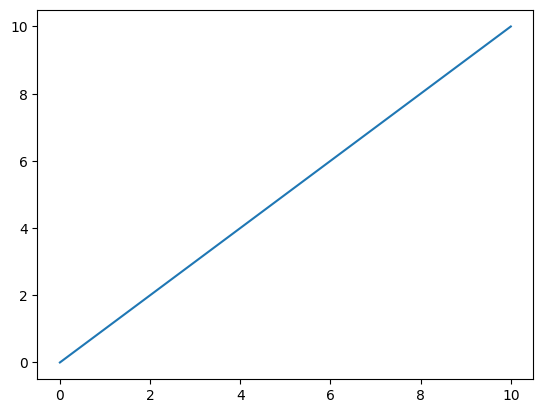

In [17]:
# Simple differential equation for increasing speed with constant rate (constant acceleration)
# dX = X0 + t * dt
def dX(dt: float, X0: float, t: float, a: float = 1, **params) -> float:
    return X0 + t * a * dt 

# We can plot the function to see how dX changes with time
t = jnp.linspace(0, 10, 1000)
X0 = 0
dt = 1
a = 1
plt.plot(t, dX(dt, X0, t, a))
# We should get a straight line with slope a to signify that the speed is increasing linearly

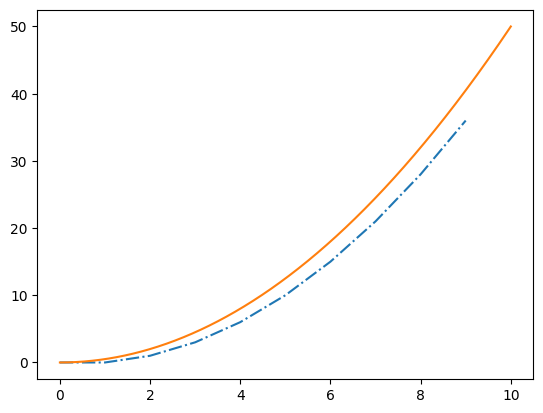

In [18]:
# Now let us integrate this linear function to get the position
def eulerIntegrate(dX: Callable, X0: float, dt: float, max_t:float = 1000, **params):
    steps = int(max_t / dt)
    X = []
    t = []
    t0 = 0
    Xval = X0
    tVal = t0
    for i in jnp.linspace(0, max_t, steps):
        t.append(tVal)
        X.append(Xval)
        Xval += dX(X0=X0, dt=dt, X=Xval, t=tVal, **params) * dt
        tVal += dt
    return jnp.array(t), jnp.array(X)

def plotDiff(dX: Callable, X0: float, dt: float, max_t:float = 1000, **params):
    # Integrate the system
    t, X = eulerIntegrate(dX, X0, dt, max_t, **params)
    plt.plot(t, X, linestyle='dashdot')
    
    
plotDiff(dX=dX, X0=X0, dt=dt, a=a, max_t=10)
# We should get a parabolic curve to signify that the position is increasing quadratically

# Now let us plot the actual X(t) = X0 + V0 * t + 0.5 * a * t^2
def X(t: float, X0: float, V0: float, a: float) -> float:
    return X0 + V0 * t + 0.5 * a * t ** 2

# We can plot the function to see how X changes with time
plt.plot(t, X(t, X0, 0, a), linestyle='solid')

From the above demonstration, we can see that the euler method does give us an approximation of the actual solution to the differential equation. But the approximation is not perfect because the timesteps are not infinitesimally small. There are other more advanced numerical solvers that can integrate even better than this with the same imperfect timesteps as well such as Heun's method, Runge-Kutta methods, etc. But the euler method is the simplest and easiest to understand and implement.

### The Euler Sampler

The Euler Sampler is basically our SDE/ODE solver that integrates the reverse diffusion process over given time steps and is implements our DiffusionSampler class.
In this notebook, we shall define the EulerSampler to be a solver of the corresponding probability flow ODE of our SDE diffusion process. This basically means that there would be no new randomness introduced in the integration process and is as simple as it can get i.e, just like the euler method for the constant acceleration example. EulerSampler is thus our implementation of the Euler method for solving the reverse diffusion probability flow ODE. If we were to use the Euler method for solving the reverse diffusion SDE, we would call it the Euler-A sampler (A for Ancestral). The idea is the same, but there is some stochasticity aka noise in that process.

This sampler is actually also equivalent and identical to the DDIM technique and yields the same results. As an exercise, you can try to find the algebraic equivalence between the two.

In [19]:
class EulerSampler(DiffusionSampler):
    # Basically a DDIM Sampler but parameterized as an ODE
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma         # Actually its not dt at all, but rather dsigma
        
        # We get the following X0 coefficient from simple algebra over trying to find the differential equation for 
        # our forward processes formulated as X_t = alpha * X_0 + sigma * epsilon. You can do the algebra bit yourself as 
        # an exercise.
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (dt)
        
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        
        next_samples = current_samples + dx * dt        # The Euler Integration Step
        return next_samples, state
    

100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


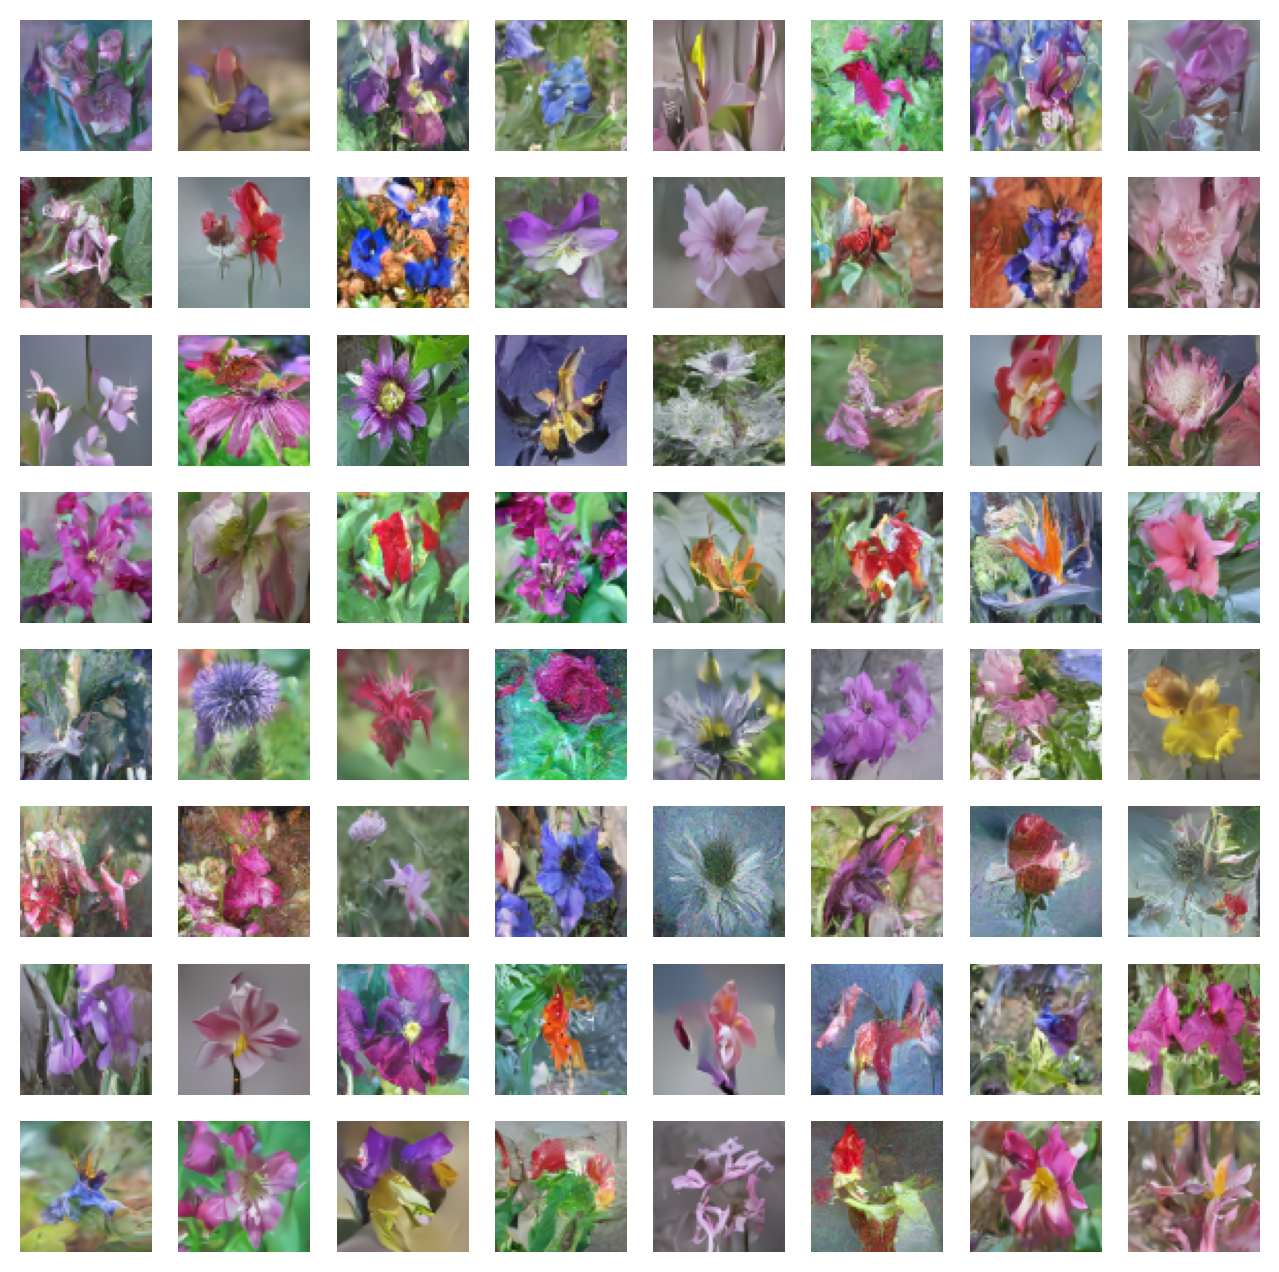

In [20]:
sampler = EulerSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=100, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=200)

## The (Denoising Diffusion Probabilistic Model) DDPM Sampler

Above, just for sake of simplicity and to have the essence of the concept, we defined the DDIMSampler EulerSampler, but now that we have seen that our model works and how to sample from it, lets talk about the DDPM sampler as presented in the original DDPM paper. In the introduction to this notebook, we discussed that the reverse diffusion process is defined as a markov chain of conditional distributions $p(x_{t−1}|x_t)$ as follows:

$p_\theta(x_{t−1}|x_t) := \mathcal{N}(x_{t−1};\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$

where:
- $x_{t−1}$ is the data sample at time $t-1$,
- $x_t$ is the data sample at time $t$,
- $\mu_\theta(x_t, t)$ is the mean of the reverse distribution,
- $\Sigma_\theta(x_t, t)$ is the covariance of the reverse distribution.

Therefore, If we want to generate images following the DDPM technique (which is actually equivalent to solving the reverse diffusion SDE via Euler method, also called Euler-Ancestral sampler), we need to follow the above markov chain of conditional distributions. This is what our DDPM Sampler does.

### The Implementation

The term $\mu_\theta(x_t, t)$ i.e, the mean of the conditional distribution is the term parameterized by our model (with weights $\theta$), But its not just the model. To be precise, In the DDPM paper, this term is defined as:

$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)$

where:
- $x_t$ is the data sample at time $t$,
- $\alpha_t$ is defined as $\alpha_t = 1 - \beta_t$, **This is not the same as our signal rate $\alpha_t$ that we use, so be careful with the notation**,
- $\bar{\alpha}_t$ is defined as $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s
- $\beta_t$ is the $\beta(t)$ parameter of the noise schedule at time $t$ which we discussed in our ![Noise Schedulers](#Cosine-Noise-Scheduler-in-terms-of-$\beta(t)$) sections,
- $\epsilon_\theta(x_t, t)$ is the denoising model (i.e, model trained in epsilon prediction model), and $\theta$ are the parameters of the denoising model.

Don't forget, the way forward diffusion is defined in DDPM is:

$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$

Thus, the signal term in DDPM is $\sqrt{\bar{\alpha}_t}$ and the noise term is $\sqrt{1 - \bar{\alpha}_t}$. Remember this to understand our DDPM sampler.

The term $\Sigma_\theta(x_t, t)$ i.e, the covariance of the conditional distribution is defined as:

$\Sigma_\theta(x_t, t) = \sigma_t^2 I 

and

$tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t$

where:
- $\sigma_t$ is the standard deviation of the new noise added at time $t$,
- $\beta_t$ is the $\beta(t)$ parameter of the noise schedule at time $t$ which we discussed 

We shall implement the DDPM Sampler in two variations: The exact formulation we discussed as DDPMSampler, and an algebraically equivalent but more simplified version as SimpleDDPMSampler. You can try to find the algebraic equivalence between the two as an exercise.

**As the DDPM paper uses sigma as the standard deviation of the new noise but we use it as the noise rate aka standard devitation of all the noise in general, we shall use the term $\gamma$ instead:**

$\Sigma_\theta(x_t, t) = \gamma_t^2 I$

**As we do not have access to the $\beta(t)$ parameter of the noise schedule, we can calculate it back from the current and next signal rates (or noise rates for that matter) as follows:**

$\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}$

**Fun Fact, DDIM is just a special case of DDPM where the new noise added is actually the original noise sample from which we started. This is to be expected as DDIM is the probability flow ODE of DDPM's SDE. You can try to find the algebraic equivalence between the two as an exercise.**

In [ ]:
class DDPMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        new_noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        
        betas = (1 - signal_ratio_squared)
        gamma = jnp.sqrt(noise_ratio_squared * betas)
        
        something_small = 1e-6 # To prevent division by zero
        
        next_samples = (1 / (jnp.sqrt(1 - betas) + something_small)) * (current_samples - betas * (pred_noise / current_noise_rate)) + new_noise * gamma
        
        return next_samples, state

In [ ]:
sampler = DDPMSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=1000, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=200)

An interesting thing about the SimpleDDPMSampler is that, unlike DDPMSampler where we need to take all the time steps to generate a sample, we can actually generate a sample in a fraction of the time steps as well, just like DDIMSampler. Don't ask me why, Its just something I realized after I implemented the simplified equations I derived on the backside of some bills.

In [ ]:
class SimpleDDPMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        # Compute noise rates and signal rates only once
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        pred_noise_coeff = ((next_noise_rate ** 2) * current_signal_rate) / (current_noise_rate * next_signal_rate)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        gamma = jnp.sqrt(noise_ratio_squared * (1 - signal_ratio_squared))
        
        next_samples = next_signal_rate * reconstructed_samples + pred_noise_coeff * pred_noise + noise * gamma
        return next_samples, state

In [ ]:
sampler = SimpleDDPMSampler(trainer.model, trainer.state.ema_params, cosine_schedule, model_output_transform=EpsilonPredictionTransform())
samples = sampler.generate_images(num_images=64, diffusion_steps=100, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=200)